# Data Science Class Project -Fraud Detection

In [1]:
import pandas as pd
import numpy as np
#import pylib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr
import warnings
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]



In [2]:
#pip install datatable
import datatable as dt

In [3]:
## using datatable
#source("C:/Data Sciene/DS-Git/Data Science GIT/DataScience/EDA/mechkar.R")

train_transaction  = dt.fread("C:/DS/ProjectDataSet/fruad-train_transaction.csv",sep=",")
test_transaction  =  dt.fread("C:/DS/ProjectDataSet/fraud-test_transaction.csv",sep=",")

train_identity = dt.fread("C:/DS/ProjectDataSet/fraud-train_identity.csv",sep=",")
test_identity = dt.fread("C:/DS/ProjectDataSet/fraud-test_identify.csv",sep=",")

ss = dt.fread("C:/DS/ProjectDataSet/fraud-sample_submission.csv",sep=",")

In [4]:
train_transaction.shape


(590540, 394)

In [5]:
test_transaction.shape

(506691, 393)

In [6]:
train_identity.shape

(144233, 41)

In [7]:
test_identity.shape

(141907, 41)

In [8]:
train_transaction  = pd.read_csv("C:/DS/ProjectDataSet/fruad-train_transaction.csv",sep=",")
test_transaction  =  pd.read_csv("C:/DS/ProjectDataSet/fraud-test_transaction.csv",sep=",")

train_identity = pd.read_csv("C:/DS/ProjectDataSet/fraud-train_identity.csv",sep=",")
test_identity = pd.read_csv("C:/DS/ProjectDataSet/fraud-test_identify.csv",sep=",")

ss = pd.read_csv("C:/DS/ProjectDataSet/fraud-sample_submission.csv",sep=",")

### Merging train transaction and identify as well as test

In [9]:
df_train = pd.merge(train_transaction,train_identity, on='TransactionID', how='left',left_index=True,right_index=True)
df_test = pd.merge(test_transaction,test_identity, on='TransactionID', how='left',left_index=True,right_index=True)

In [10]:
df_train.shape

(590540, 434)

In [11]:
df_test.shape

(506691, 433)

### Delete temporary storage to provide space to RAM or else session crashes due to shortage of RAM

In [1]:
import gc
import os

del train_transaction, train_identity, test_transaction, test_identity; x = gc.collect()

NameError: name 'train_transaction' is not defined

### using datatable

In [13]:
dt.Frame(df_train)

<Frame#21aaec160f0 590540x434>

In [14]:
print('train data memory in MB:', df_train.memory_usage().sum() / 1024**2) 
print('test data memory in MB:', df_test.memory_usage().sum() / 1024**2) 

train data memory in MB: 1955.3709106445312
test data memory in MB: 1673.8679428100586


In [15]:
# Most often used function to reduce dataset memory

def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            #print("******************************")
            #print("Column: ",col)
            #print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                      props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64) 
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            #print("dtype after: ",props[col].dtype)
            #print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props

In [16]:
reduce_mem_usage(df_test)
reduce_mem_usage(df_train)


Memory usage of properties dataframe is : 1673.8679428100586  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  459.05740547180176  MB
This is  27.42494755596697 % of the initial size
Memory usage of properties dataframe is : 1955.3709106445312  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  546.287467956543  MB
This is  27.937792517148328 % of the initial size


TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000        0          86400       68.500000         W   
1             2987001        0          86401       29.000000         W   
2             2987002        0          86469       59.000000         W   
3             2987003        0          86499       50.000000         W   
4             2987004        0          86506       50.000000         H   
...               ...      ...            ...             ...       ...   
590535        3577535        0       15811047       49.000000         W   
590536        3577536        0       15811049       39.500000         W   
590537        3577537        0       15811079       30.950001         W   
590538        3577538        0       15811088      117.000000         W   
590539        3577539        0       15811131      279.950012         W   

        card1  card2  card3       card4  card5  ...                id_31  \
0       13926     99    150    discover    142  ...  samsung browser 6.2   
1        2755    404    150  mastercard    102  ...   mobile safari 11.0   
2        4663    490    150        visa    166  ...          chrome 62.0   
3       18132    567    150  mastercard    117  ...          chrome 62.0   
4        4497    514    150  mastercard    102  ...          chrome 62.0   
...       ...    ...    ...         ...    ...  ...                  ...   
590535   6550     99    150        visa    226  ...                  NaN   
590536  10444    225    150  mastercard    224  ...                  NaN   
590537  12037    595    150  mastercard    224  ...                  NaN   
590538   7826    481    150  mastercard    224  ...                  NaN   
590539  15066    170    150  mastercard    102  ...                  NaN   

        id_32      id_33           id_34  id_35 id_36 id_37  id_38  \
0          32  2220x1080  match_status:2      T     F     T      T   
1          32   1334x750  match_status:1      T     F     F      T   
2         255        NaN             NaN      F     F     T      T   
3         255        NaN             NaN      F     F     T      T   
4          24   1280x800  match_status:2      T     F     T      T   
...       ...        ...             ...    ...   ...   ...    ...   
590535    255        NaN             NaN    NaN   NaN   NaN    NaN   
590536    255        NaN             NaN    NaN   NaN   NaN    NaN   
590537    255        NaN             NaN    NaN   NaN   NaN    NaN   
590538    255        NaN             NaN    NaN   NaN   NaN    NaN   
590539    255        NaN             NaN    NaN   NaN   NaN    NaN   

        DeviceType                     DeviceInfo  
0           mobile  SAMSUNG SM-G892A Build/NRD90M  
1           mobile                     iOS Device  
2          desktop                        Windows  
3          desktop                            NaN  
4          desktop                          MacOS  
...            ...                            ...  
590535         NaN                            NaN  
590536         NaN                            NaN  
590537         NaN                            NaN  
590538         NaN                            NaN  
590539         NaN                            NaN  

[590540 rows x 434 columns]

### Conclusion:
Train dataset memory reduced from '1955' MB to '546' MB
Test dataset memory reduced from '1673' MB to '459' MB

# EDA

In [17]:
print('train shape is {}'.format(df_train.shape))
print('test shape is {}'.format(df_test.shape))


train shape is (590540, 434)
test shape is (506691, 433)


#### Sweetviz report vs target variable

In [18]:
import sweetviz as sv

#analyzing the dataset
advert_report = sv.analyze([df_train,'Train'],target_feat='isFraud',pairwise_analysis='off')
#display the report
advert_report.show_html('df_train.html')

#### Profiling report

In [19]:
from pandas_profiling import ProfileReport

In [20]:
#profile = ProfileReport(df_train, title="Pandas Profiling Report")

In [21]:
#profile.to_file(output_file="full_output1.html")

In [22]:
df_train.head

<bound method NDFrame.head of         TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000        0          86400       68.500000         W   
1             2987001        0          86401       29.000000         W   
2             2987002        0          86469       59.000000         W   
3             2987003        0          86499       50.000000         W   
4             2987004        0          86506       50.000000         H   
...               ...      ...            ...             ...       ...   
590535        3577535        0       15811047       49.000000         W   
590536        3577536        0       15811049       39.500000         W   
590537        3577537        0       15811079       30.950001         W   
590538        3577538        0       15811088      117.000000         W   
590539        3577539        0       15811131      279.950012         W   

        card1  card2  card3       card4  card5  ...                id

In [23]:
df_train.dtypes

TransactionID      uint32
isFraud             uint8
TransactionDT      uint32
TransactionAmt    float32
ProductCD          object
                   ...   
id_36              object
id_37              object
id_38              object
DeviceType         object
DeviceInfo         object
Length: 434, dtype: object

In [24]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float32(80), int16(7), int8(9), object(31), uint16(63), uint32(3), uint8(241)
memory usage: 546.3+ MB


In [25]:
df_train.describe(include='all')

TransactionID        isFraud  TransactionDT  TransactionAmt ProductCD  \
count    5.905400e+05  590540.000000   5.905400e+05   590540.000000    590540   
unique            NaN            NaN            NaN             NaN         5   
top               NaN            NaN            NaN             NaN         W   
freq              NaN            NaN            NaN             NaN    439670   
mean     3.282270e+06       0.034990   7.372311e+06      134.849594       NaN   
std      1.704744e+05       0.183755   4.617224e+06      239.162689       NaN   
min      2.987000e+06       0.000000   8.640000e+04        0.251000       NaN   
25%      3.134635e+06       0.000000   3.027058e+06       43.320999       NaN   
50%      3.282270e+06       0.000000   7.306528e+06       68.769001       NaN   
75%      3.429904e+06       0.000000   1.124662e+07      125.000000       NaN   
max      3.577539e+06       1.000000   1.581113e+07    31937.390625       NaN   

                card1          card2          card3   card4          card5  \
count   590540.000000  590540.000000  590540.000000  588963  590540.000000   
unique            NaN            NaN            NaN       4            NaN   
top               NaN            NaN            NaN    visa            NaN   
freq              NaN            NaN            NaN  384767            NaN   
mean      9898.734658     358.568729     153.051302     NaN     198.555681   
std       4901.170153     159.865285      11.659219     NaN      41.962326   
min       1000.000000      99.000000      99.000000     NaN      99.000000   
25%       6019.000000     204.000000     150.000000     NaN     166.000000   
50%       9678.000000     360.000000     150.000000     NaN     226.000000   
75%      14184.000000     512.000000     150.000000     NaN     226.000000   
max      18396.000000     600.000000     231.000000     NaN     237.000000   

        ...        id_31          id_32      id_33           id_34   id_35  \
count   ...       140282  590540.000000      73289           77805  140985   
unique  ...          130            NaN        260               4       2   
top     ...  chrome 63.0            NaN  1920x1080  match_status:2       T   
freq    ...        22000            NaN      16874           60011   77814   
mean    ...          NaN     224.980469        NaN             NaN     NaN   
std     ...          NaN      77.200245        NaN             NaN     NaN   
min     ...          NaN       0.000000        NaN             NaN     NaN   
25%     ...          NaN     255.000000        NaN             NaN     NaN   
50%     ...          NaN     255.000000        NaN             NaN     NaN   
75%     ...          NaN     255.000000        NaN             NaN     NaN   
max     ...          NaN     255.000000        NaN             NaN     NaN   

         id_36   id_37   id_38  DeviceType  DeviceInfo  
count   140985  140985  140985      140810      118666  
unique       2       2       2           2        1786  
top          F       T       F     desktop     Windows  
freq    134066  110452   73922       85165       47722  
mean       NaN     NaN     NaN         NaN         NaN  
std        NaN     NaN     NaN         NaN         NaN  
min        NaN     NaN     NaN         NaN         NaN  
25%        NaN     NaN     NaN         NaN         NaN  
50%        NaN     NaN     NaN         NaN         NaN  
75%        NaN     NaN     NaN         NaN         NaN  
max        NaN     NaN     NaN         NaN         NaN  

[11 rows x 434 columns]

In [26]:
print(df_train.nunique())

TransactionID     590540
isFraud                2
TransactionDT     573349
TransactionAmt     20902
ProductCD              5
                   ...  
id_36                  2
id_37                  2
id_38                  2
DeviceType             2
DeviceInfo          1786
Length: 434, dtype: int64


In [27]:
## DF for numerical variables

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','uint32','uint8','uint16','int8']

df_train_numeric = df_train.select_dtypes(include=numerics)


In [28]:
df_train_numeric.head()

TransactionID  isFraud  TransactionDT  TransactionAmt  card1  card2  card3  \
0        2987000        0          86400            68.5  13926     99    150   
1        2987001        0          86401            29.0   2755    404    150   
2        2987002        0          86469            59.0   4663    490    150   
3        2987003        0          86499            50.0  18132    567    150   
4        2987004        0          86506            50.0   4497    514    150   

   card5  addr1  addr2  ...  id_17  id_18  id_19  id_20  id_21  id_22  id_24  \
0    142    315     87  ...    166      9    542    144     99      9     10   
1    102    325     87  ...    166      9    621    500     99      9     10   
2    166    330     87  ...    121      9    410    142     99      9     10   
3    117    476     87  ...    225      9    176    507     99      9     10   
4    102    420     87  ...    166     15    529    575     99      9     10   

   id_25  id_26  id_32  
0     99     99     32  
1     99     99     32  
2     99     99    255  
3     99     99    255  
4     99     99     24  

[5 rows x 403 columns]

In [29]:
## DF for categorial variables

category = ['object','O']

df_train_category= df_train.select_dtypes(include=category)

In [30]:
df_train_category.head()

ProductCD       card4   card6 P_emaildomain R_emaildomain   M1   M2   M3  \
0         W    discover  credit           NaN           NaN    T    T    T   
1         W  mastercard  credit     gmail.com           NaN  NaN  NaN  NaN   
2         W        visa   debit   outlook.com           NaN    T    T    T   
3         W  mastercard   debit     yahoo.com           NaN  NaN  NaN  NaN   
4         H  mastercard  credit     gmail.com           NaN  NaN  NaN  NaN   

    M4   M5  ...             id_30                id_31      id_33  \
0   M2    F  ...       Android 7.0  samsung browser 6.2  2220x1080   
1   M0    T  ...        iOS 11.1.2   mobile safari 11.0   1334x750   
2   M0    F  ...               NaN          chrome 62.0        NaN   
3   M0    T  ...               NaN          chrome 62.0        NaN   
4  NaN  NaN  ...  Mac OS X 10_11_6          chrome 62.0   1280x800   

            id_34 id_35 id_36 id_37 id_38 DeviceType  \
0  match_status:2     T     F     T     T     mobile   
1  match_status:1     T     F     F     T     mobile   
2             NaN     F     F     T     T    desktop   
3             NaN     F     F     T     T    desktop   
4  match_status:2     T     F     T     T    desktop   

                      DeviceInfo  
0  SAMSUNG SM-G892A Build/NRD90M  
1                     iOS Device  
2                        Windows  
3                            NaN  
4                          MacOS  

[5 rows x 31 columns]

In [31]:
df_train_card = df_train[df_train.columns[5:11]]
df_train_card.head()

card1  card2  card3       card4  card5   card6
0  13926     99    150    discover    142  credit
1   2755    404    150  mastercard    102  credit
2   4663    490    150        visa    166   debit
3  18132    567    150  mastercard    117   debit
4   4497    514    150  mastercard    102  credit

In [32]:
df_train_C = df_train[df_train.columns[17:31]]
df_train_C.head()

C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  C11  C12  C13  C14
0   1   1   0   0   0   1   0   0   1    0    2    0    1    1
1   1   1   0   0   0   1   0   0   0    0    1    0    1    1
2   1   1   0   0   0   1   0   0   1    0    1    0    1    1
3   2   5   0   0   0   4   0   0   1    0    1    0   25    1
4   1   1   0   0   0   1   0   1   0    1    1    0    1    1

In [33]:
df_train_D = df_train[df_train.columns[31:46]]
df_train_D.head()

D1     D2     D3   D4     D5  D6     D7   D8   D9    D10  D11  D12    D13  \
0   14  65535     13 -123  65535 -84  65535 -1.0 -1.0     13   13  -84  65535   
1    0  65535  65535    0  65535 -84  65535 -1.0 -1.0      0  -54  -84  65535   
2    0  65535  65535    0  65535 -84  65535 -1.0 -1.0      0  315  -84  65535   
3  112    112      0   94      0 -84  65535 -1.0 -1.0     84  -54  -84  65535   
4    0  65535  65535 -123  65535 -84  65535 -1.0 -1.0  65535  -54  -84  65535   

   D14  D15  
0 -194    0  
1 -194    0  
2 -194  315  
3 -194  111  
4 -194  -84

In [34]:
df_train_M = df_train[df_train.columns[46:55]]
df_train_M.head()

M1   M2   M3   M4   M5   M6   M7   M8   M9
0    T    T    T   M2    F    T  NaN  NaN  NaN
1  NaN  NaN  NaN   M0    T    T  NaN  NaN  NaN
2    T    T    T   M0    F    F    F    F    F
3  NaN  NaN  NaN   M0    T    F  NaN  NaN  NaN
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

In [35]:
df_train_V = df_train[df_train.columns[55:394]]
df_train_V.head()

V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  ...  V330  V331  V332  \
0    1    1    1    1    1    1    1    1    1    0  ...   255  -1.0  -1.0   
1  255  255  255  255  255  255  255  255  255  255  ...   255  -1.0  -1.0   
2    1    1    1    1    1    1    1    1    1    0  ...   255  -1.0  -1.0   
3  255  255  255  255  255  255  255  255  255  255  ...   255  -1.0  -1.0   
4  255  255  255  255  255  255  255  255  255  255  ...     0   0.0   0.0   

   V333  V334  V335  V336  V337  V338  V339  
0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  
1  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  
2  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  
3  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 339 columns]

In [36]:
df_train_id = df_train[df_train.columns[394:432]]
df_train_id.head()

id_01   id_02  id_03  id_04  id_05  id_06  id_07  id_08  id_09  id_10  ...  \
0      0   70787    -14    -29    -73   -101    -47   -101    -37   -101  ...   
1     -5   98945    -14    -29      0     -5    -47   -101    -37   -101  ...   
2     -5  191631      0      0      0      0    -47   -101      0      0  ...   
3     -5  221832    -14    -29      0     -6    -47   -101    -37   -101  ...   
4      0    7460      0      0      1      0    -47   -101      0      0  ...   

      id_29             id_30                id_31  id_32      id_33  \
0  NotFound       Android 7.0  samsung browser 6.2     32  2220x1080   
1  NotFound        iOS 11.1.2   mobile safari 11.0     32   1334x750   
2     Found               NaN          chrome 62.0    255        NaN   
3  NotFound               NaN          chrome 62.0    255        NaN   
4     Found  Mac OS X 10_11_6          chrome 62.0     24   1280x800   

            id_34  id_35  id_36  id_37  id_38  
0  match_status:2      T      F      T      T  
1  match_status:1      T      F      F      T  
2             NaN      F      F      T      T  
3             NaN      F      F      T      T  
4  match_status:2      T      F      T      T  

[5 rows x 38 columns]

In [37]:
df_train.head

<bound method NDFrame.head of         TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000        0          86400       68.500000         W   
1             2987001        0          86401       29.000000         W   
2             2987002        0          86469       59.000000         W   
3             2987003        0          86499       50.000000         W   
4             2987004        0          86506       50.000000         H   
...               ...      ...            ...             ...       ...   
590535        3577535        0       15811047       49.000000         W   
590536        3577536        0       15811049       39.500000         W   
590537        3577537        0       15811079       30.950001         W   
590538        3577538        0       15811088      117.000000         W   
590539        3577539        0       15811131      279.950012         W   

        card1  card2  card3       card4  card5  ...                id

In [38]:
df_train_restvar = df_train[['isFraud','TransactionAmt','ProductCD','DeviceInfo','DeviceType','P_emaildomain','R_emaildomain','addr1','addr2']]

df_train_restvar.head()


isFraud  TransactionAmt ProductCD                     DeviceInfo  \
0        0            68.5         W  SAMSUNG SM-G892A Build/NRD90M   
1        0            29.0         W                     iOS Device   
2        0            59.0         W                        Windows   
3        0            50.0         W                            NaN   
4        0            50.0         H                          MacOS   

  DeviceType P_emaildomain R_emaildomain  addr1  addr2  
0     mobile           NaN           NaN    315     87  
1     mobile     gmail.com           NaN    325     87  
2    desktop   outlook.com           NaN    330     87  
3    desktop     yahoo.com           NaN    476     87  
4    desktop     gmail.com           NaN    420     87

In [155]:
df_train_numeric.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25',
       'id_26', 'id_32'],
      dtype='object', length=403)

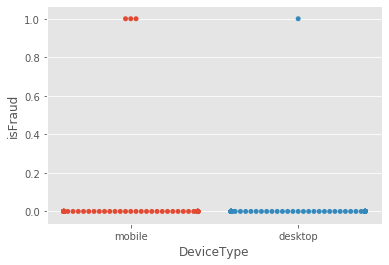

In [166]:
sns.swarmplot(x="DeviceType", y="isFraud", data=df_train[1:250])

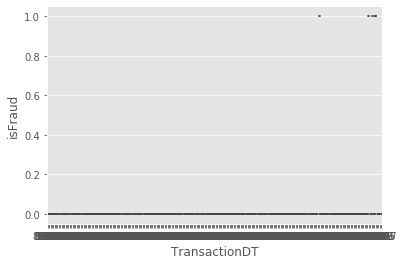

In [164]:
sns.boxplot(x="TransactionDT", y="isFraud", data=df_train[1:250])

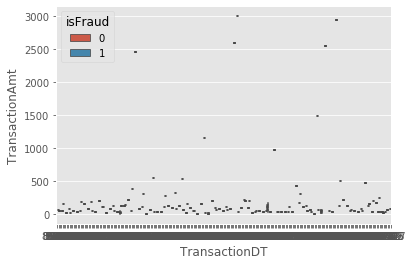

In [170]:
sns.boxplot('TransactionDT', 'TransactionAmt', 'isFraud', data=df_train[1:250])

## Analyzing Relationships Between Numerical and Categorical Variables
Box Plot for Numeric via categorial

C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may cons

C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may cons

C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may cons

C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may cons

C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may cons

C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may cons

C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may cons

C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may cons

C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may cons

C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may cons

C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may cons

C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may cons

C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may cons

C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may cons

C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may cons

C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may cons

C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\ELADL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may cons

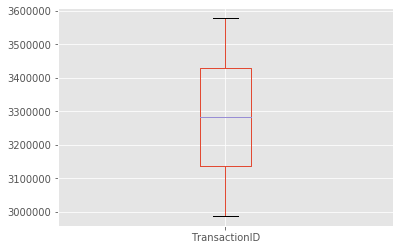

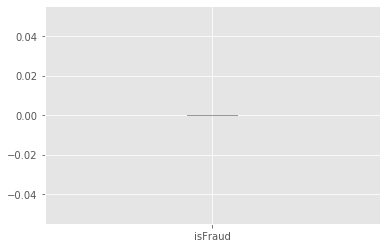

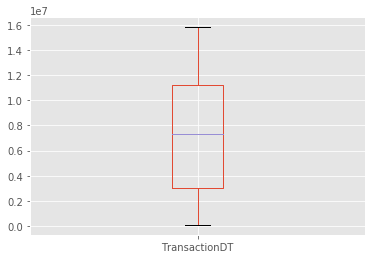

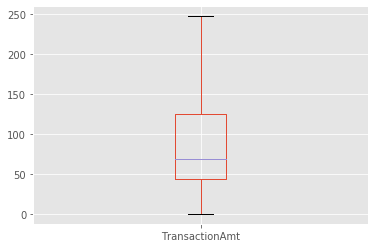

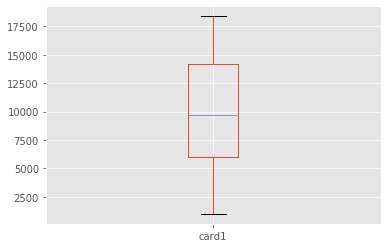

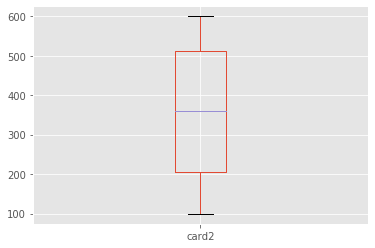

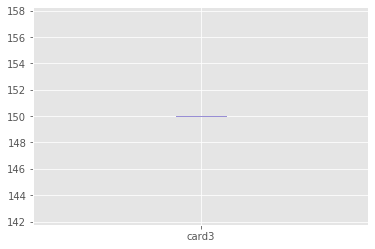

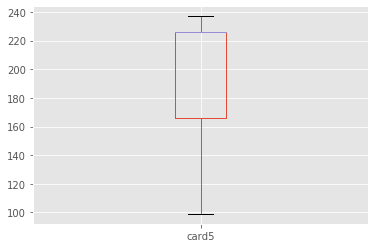

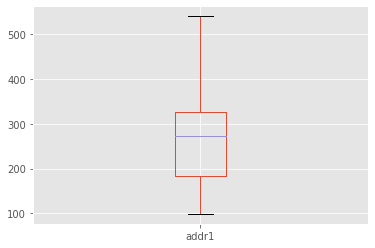

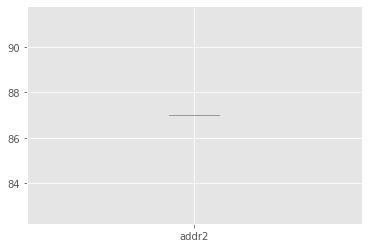

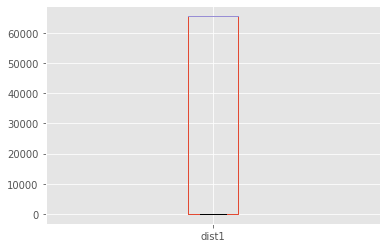

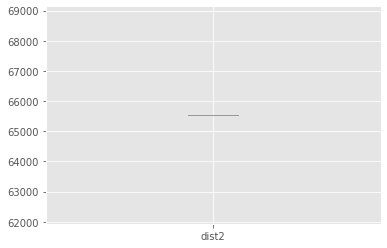

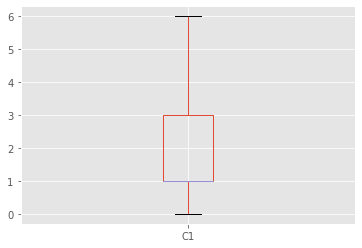

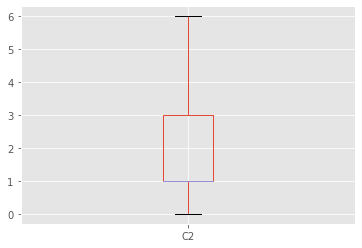

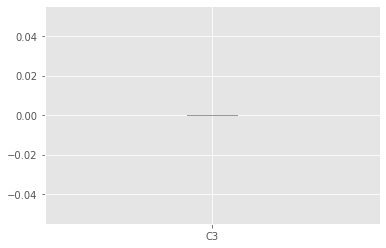

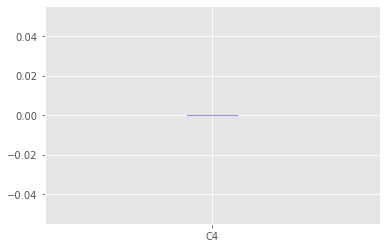

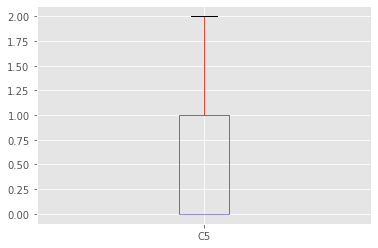

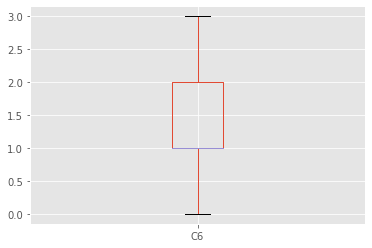

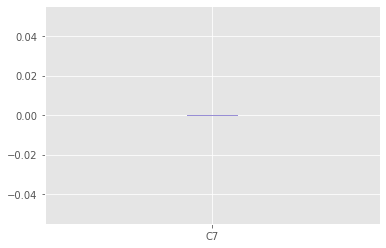

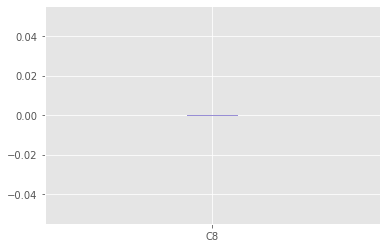

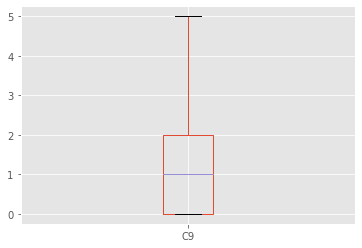

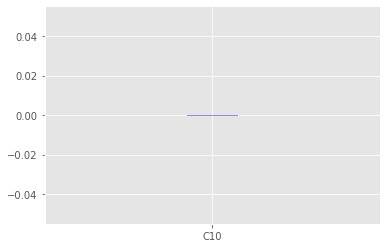

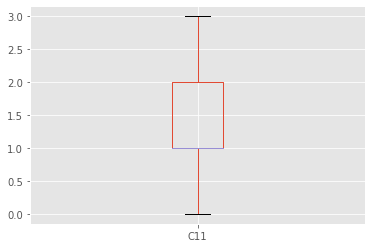

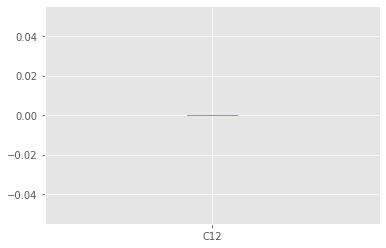

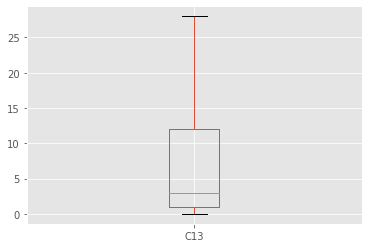

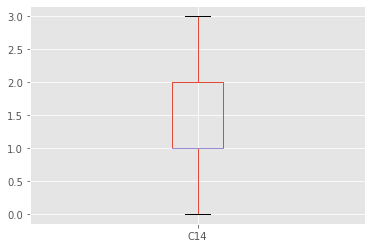

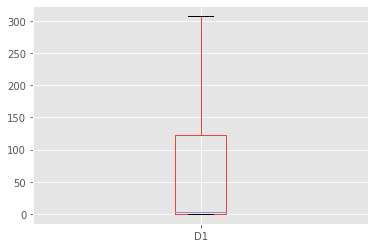

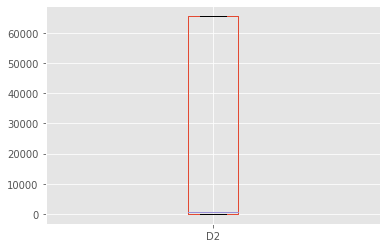

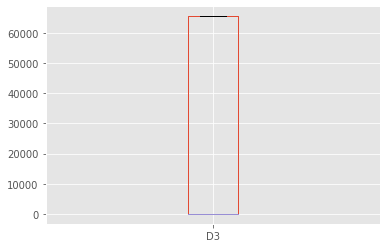

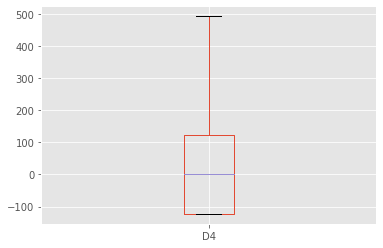

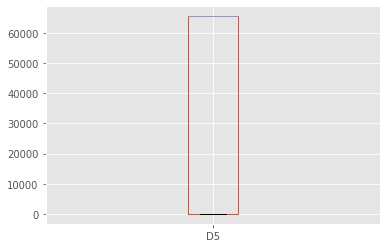

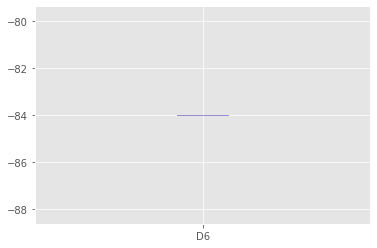

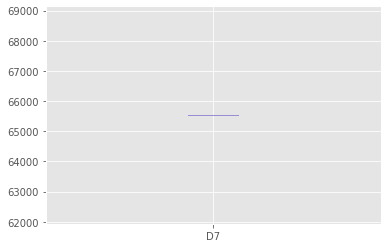

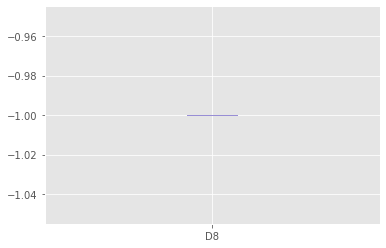

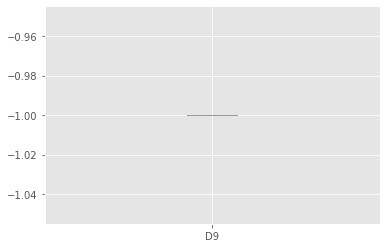

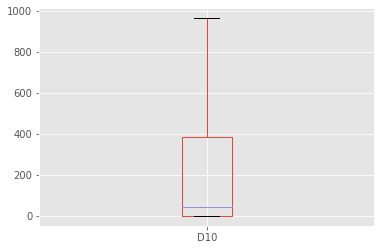

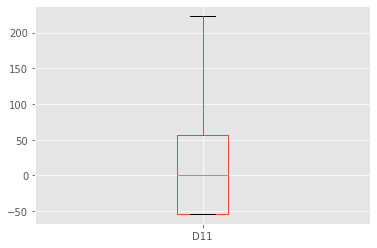

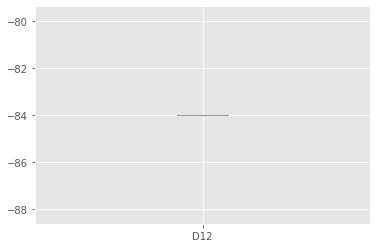

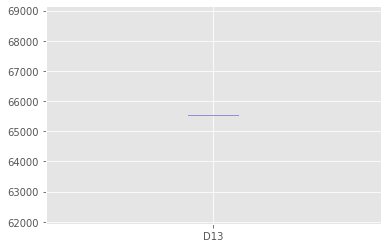

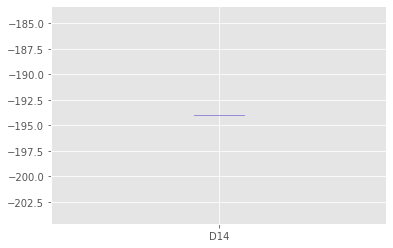

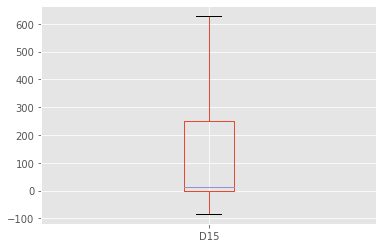

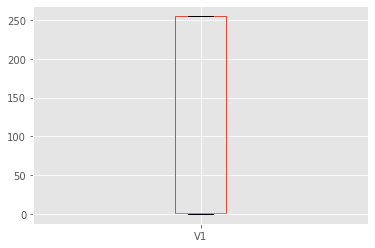

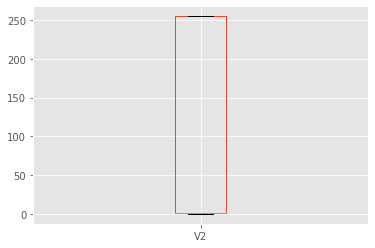

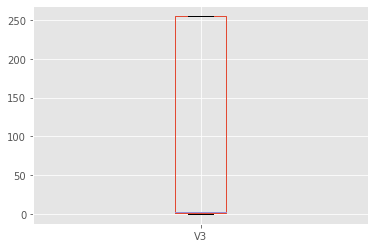

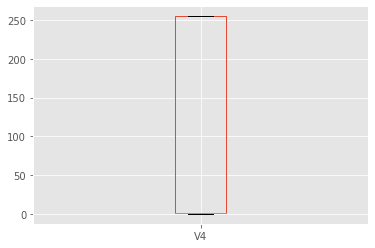

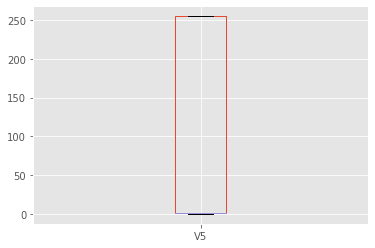

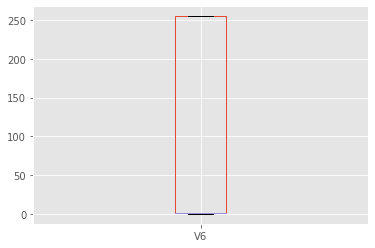

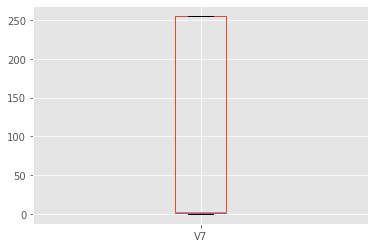

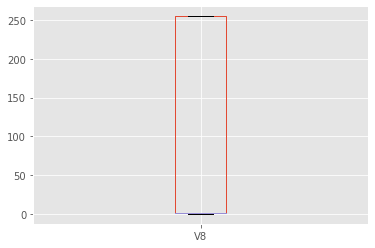

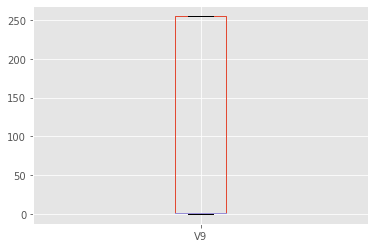

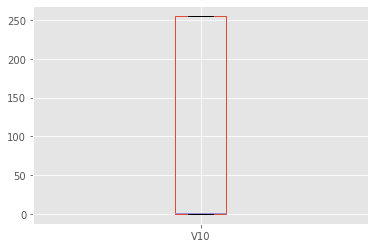

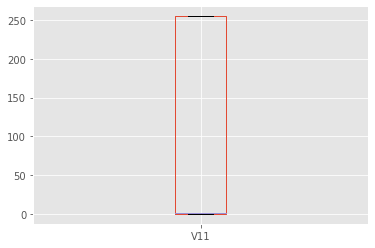

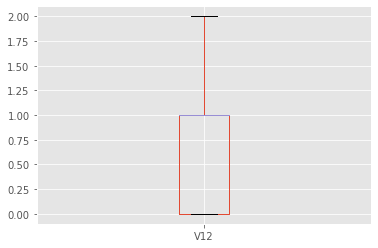

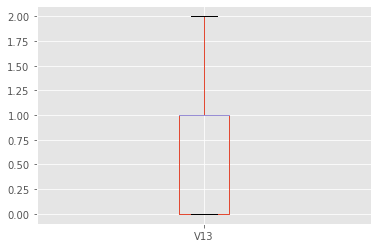

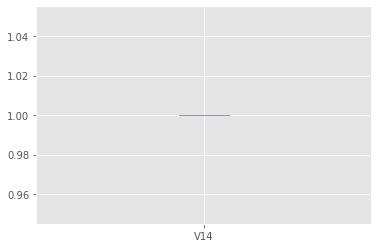

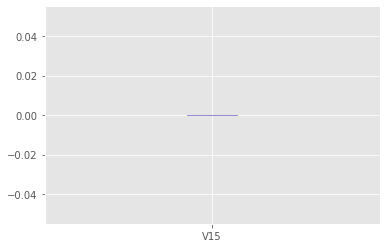

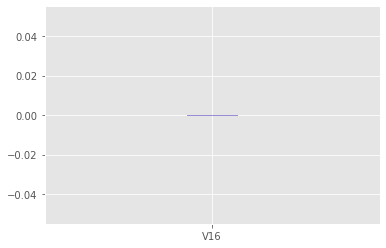

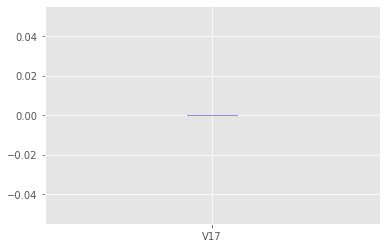

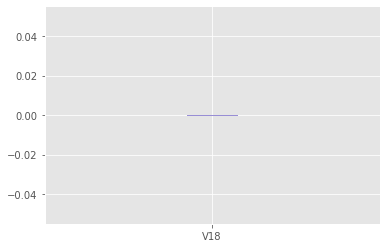

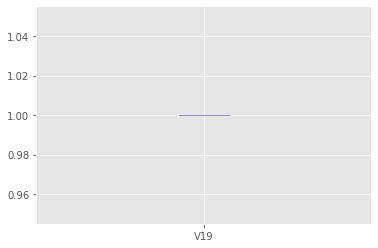

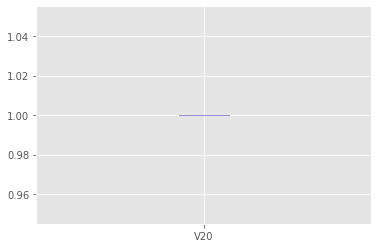

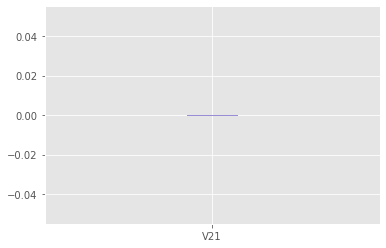

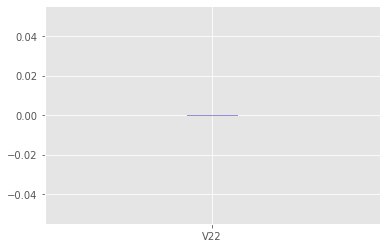

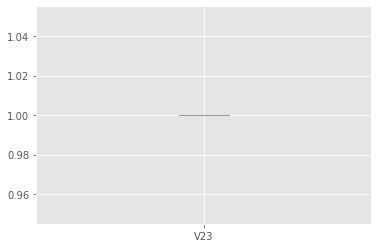

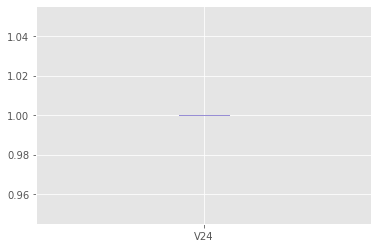

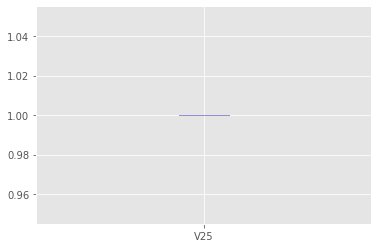

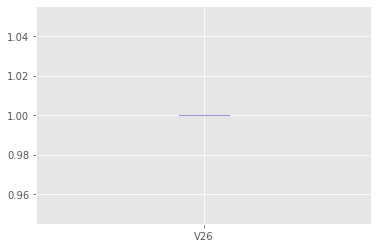

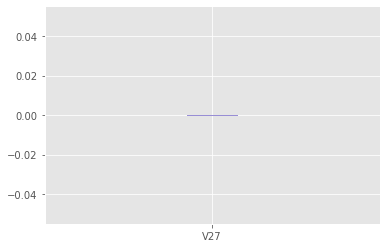

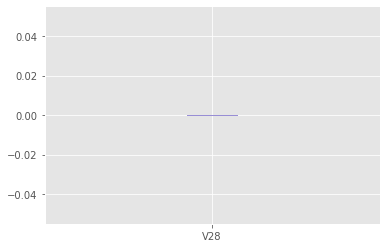

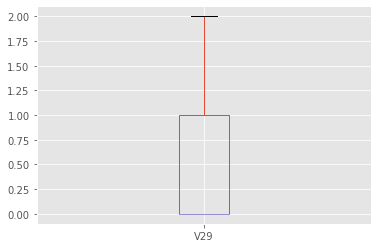

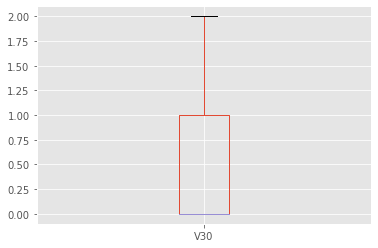

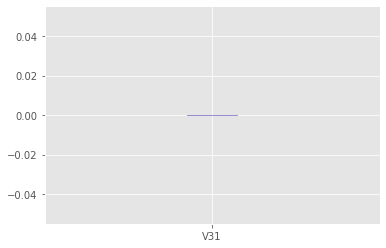

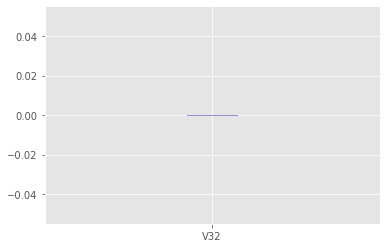

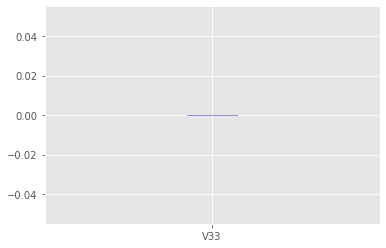

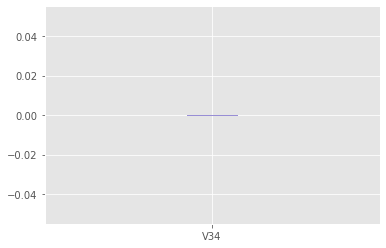

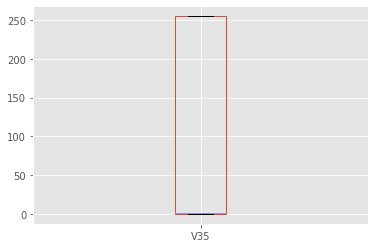

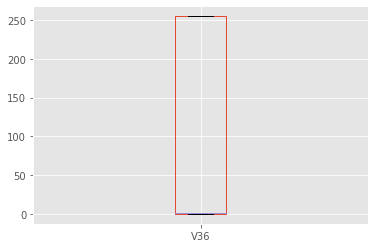

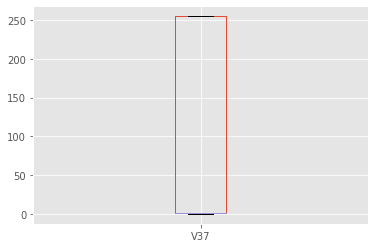

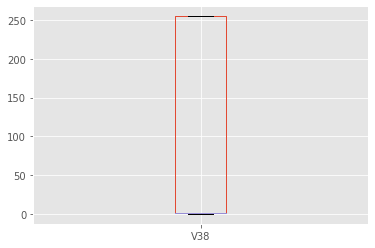

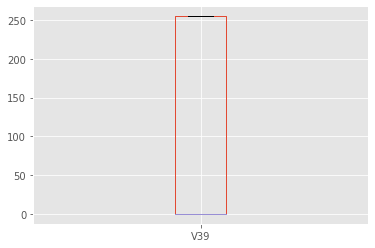

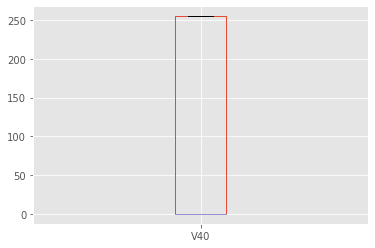

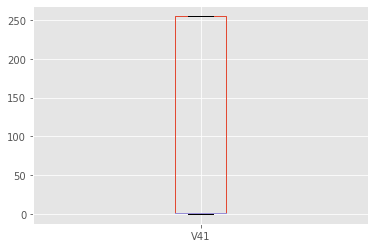

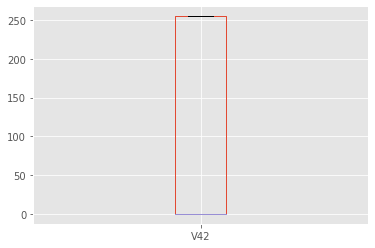

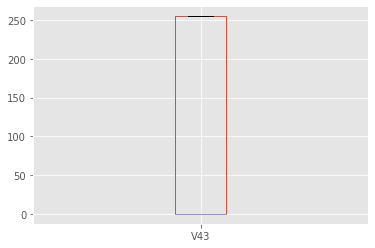

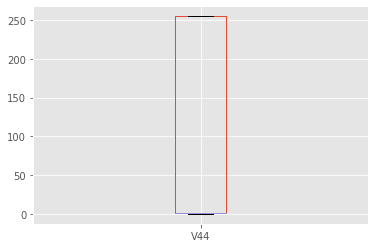

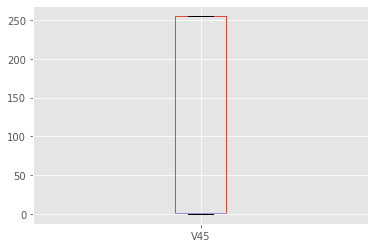

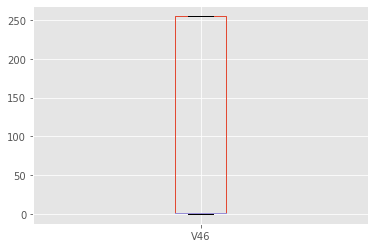

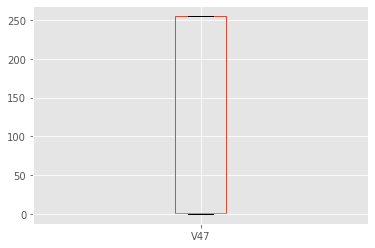

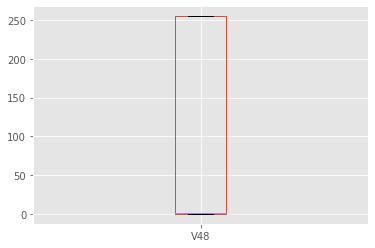

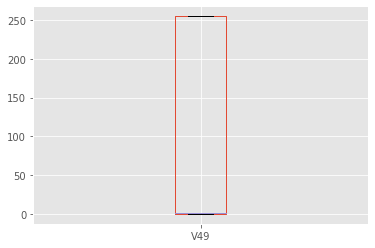

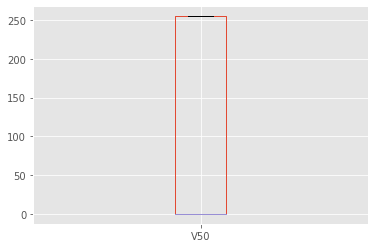

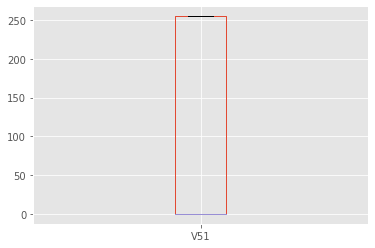

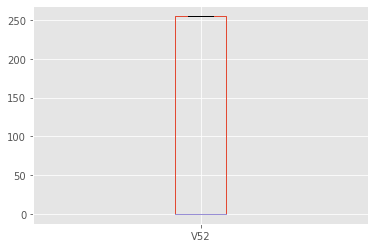

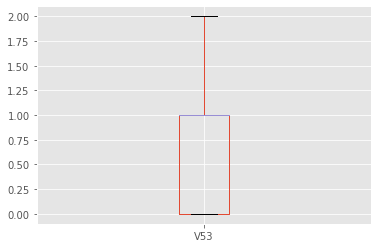

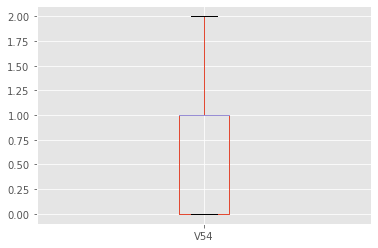

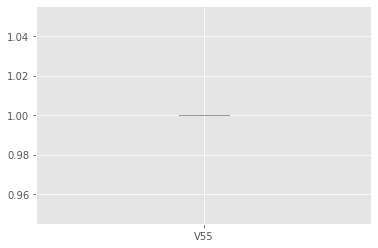

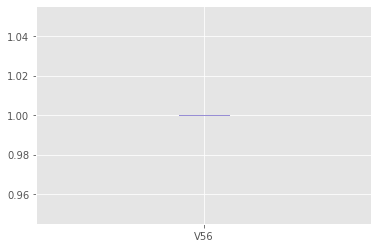

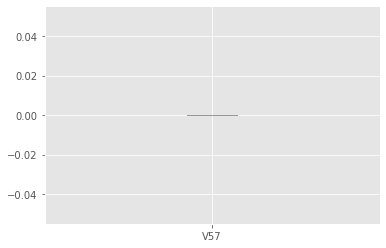

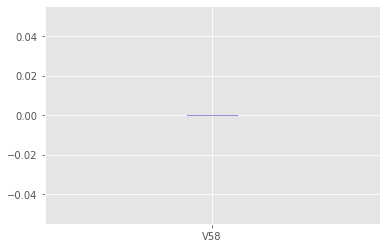

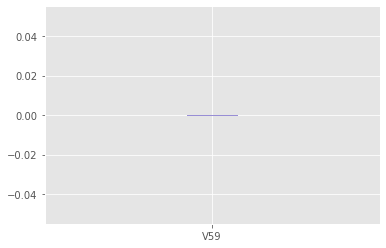

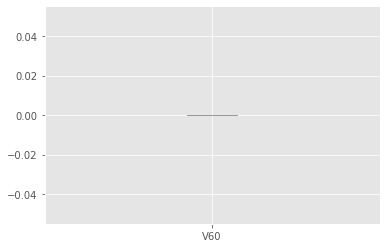

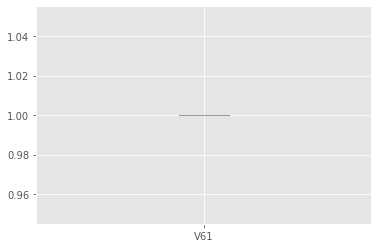

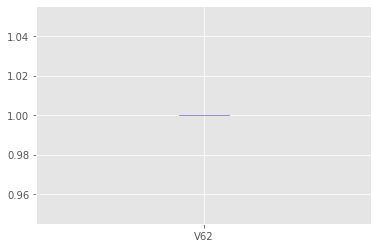

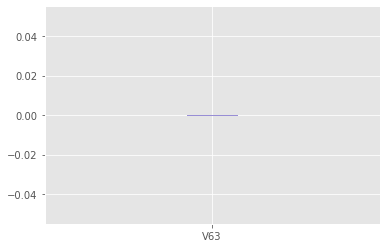

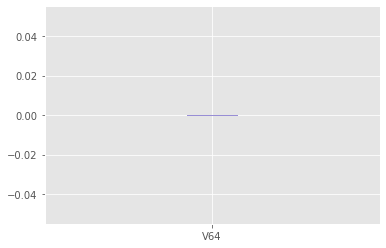

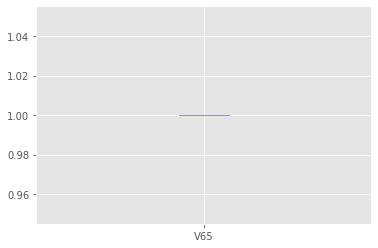

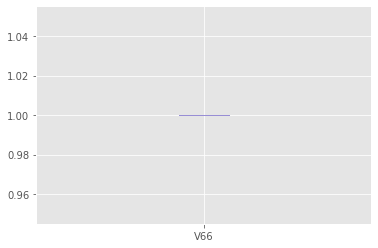

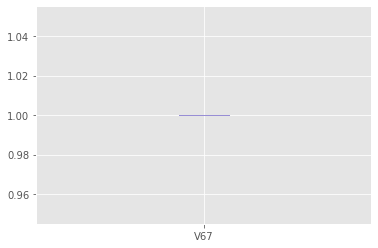

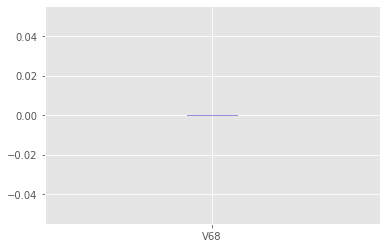

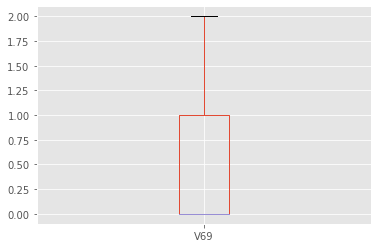

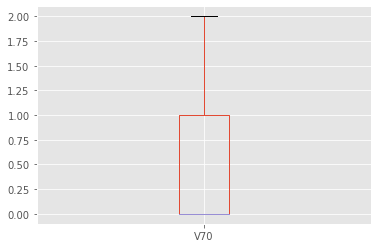

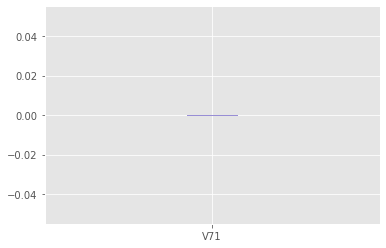

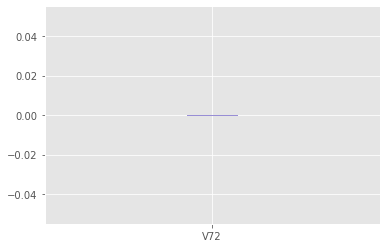

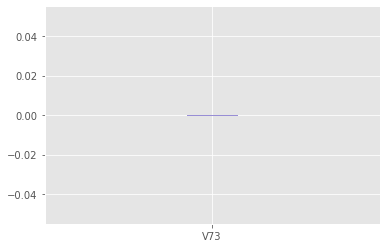

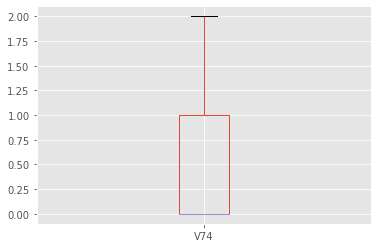

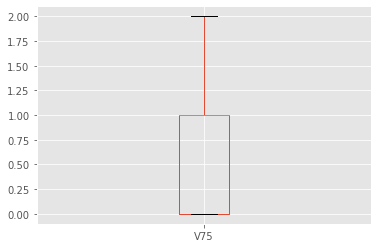

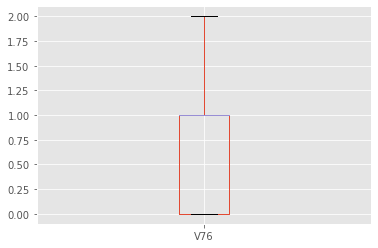

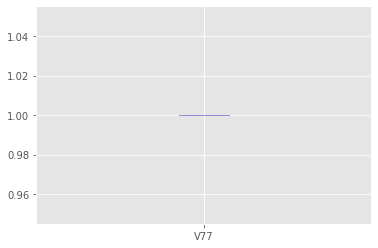

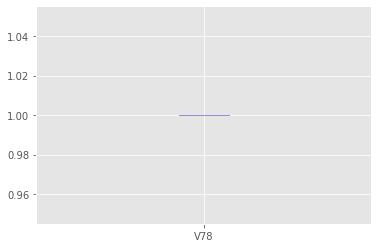

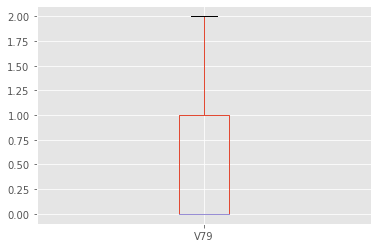

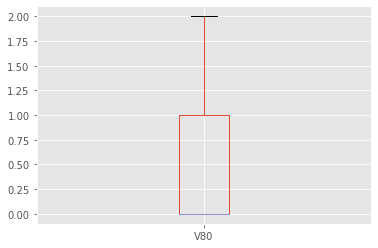

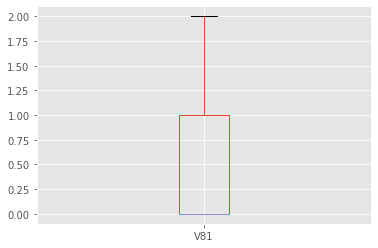

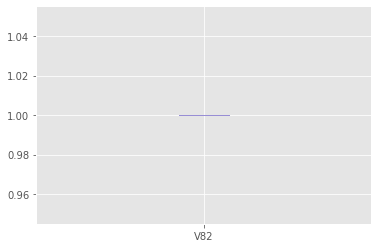

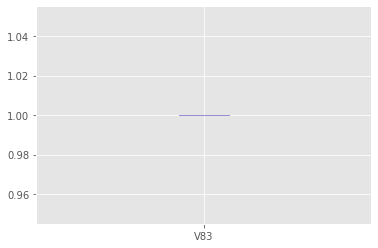

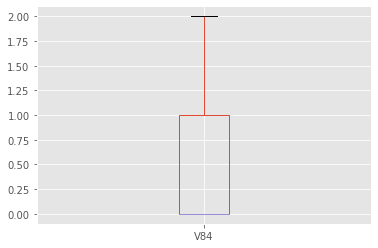

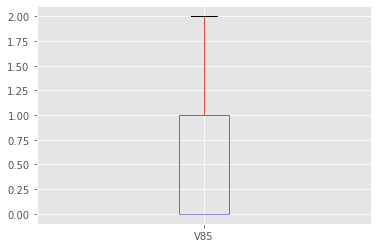

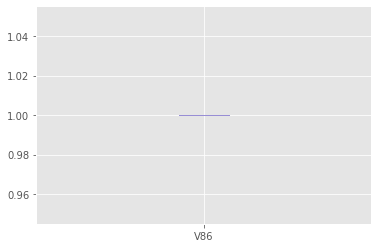

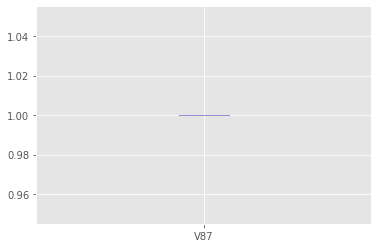

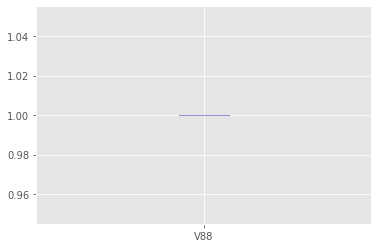

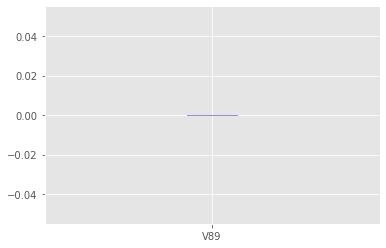

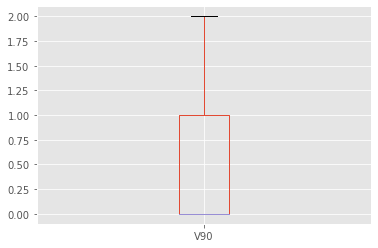

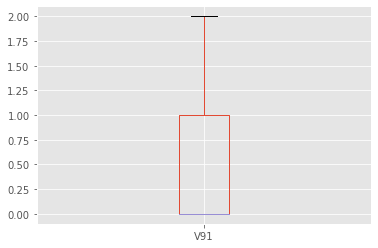

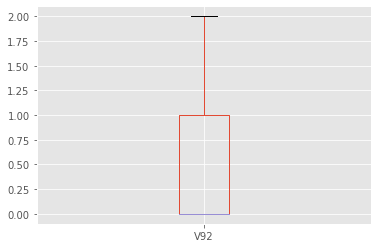

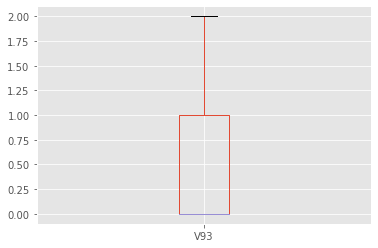

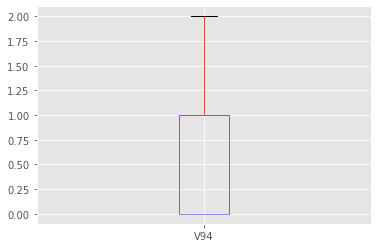

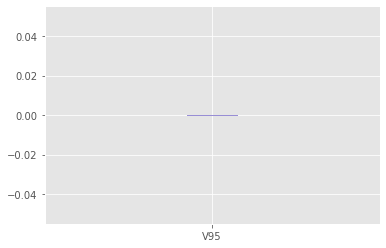

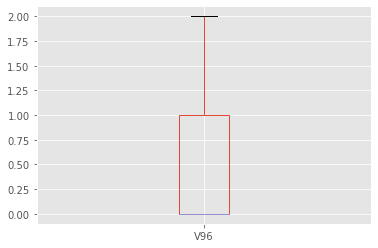

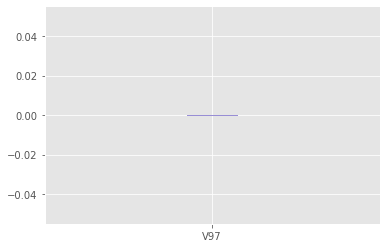

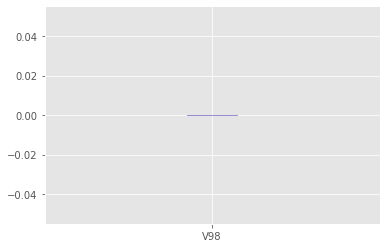

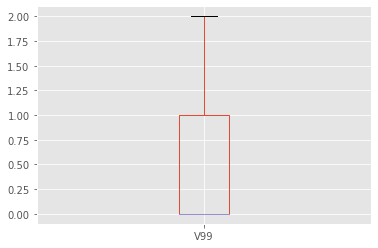

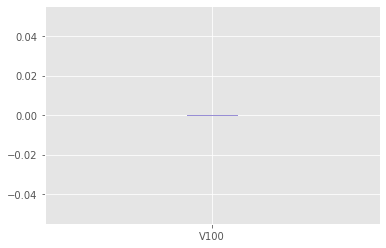

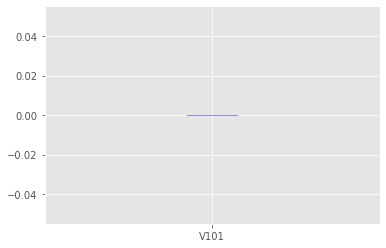

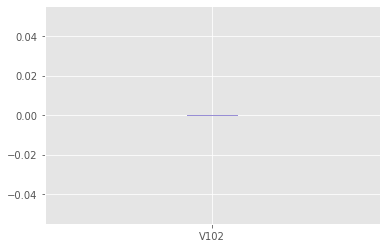

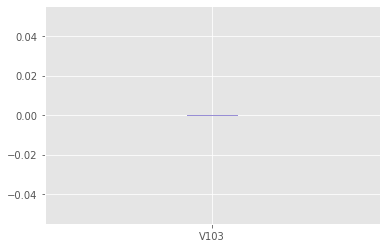

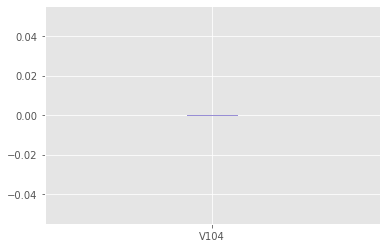

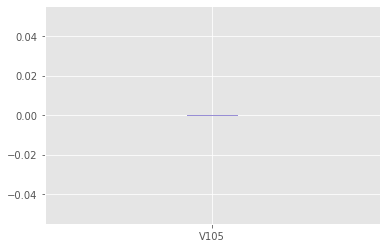

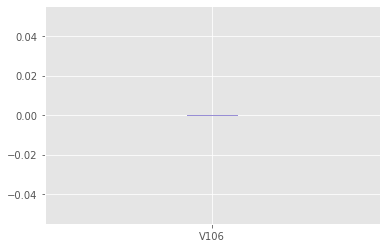

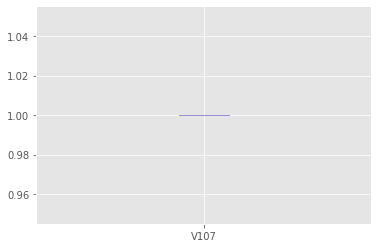

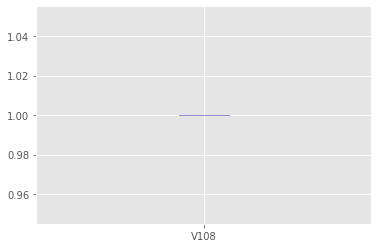

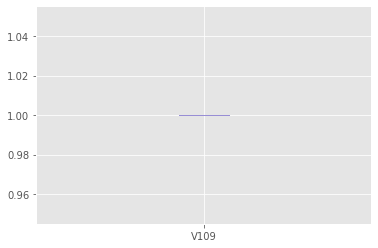

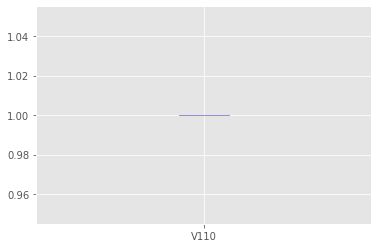

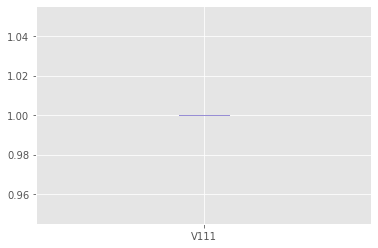

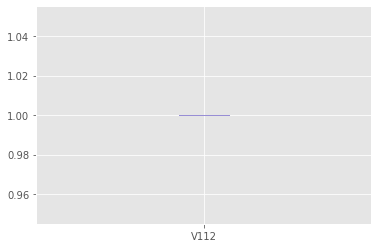

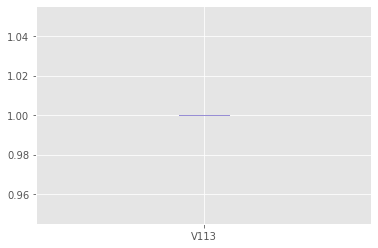

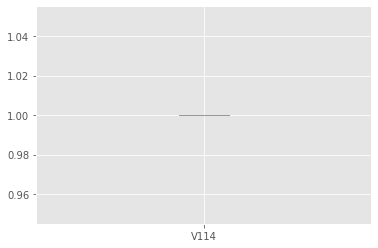

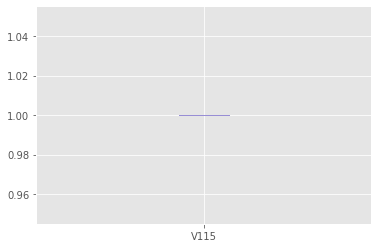

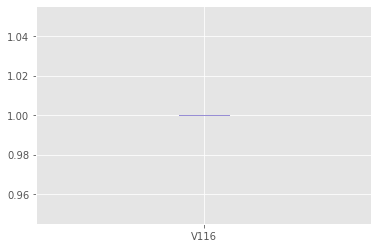

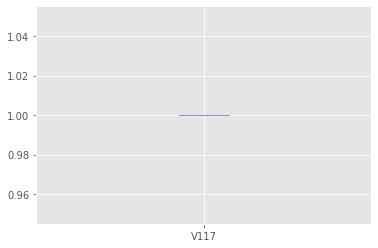

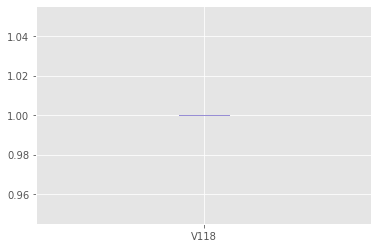

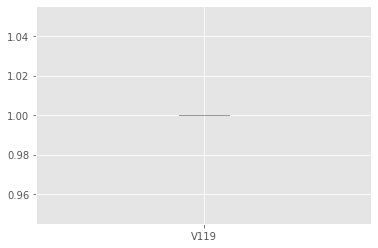

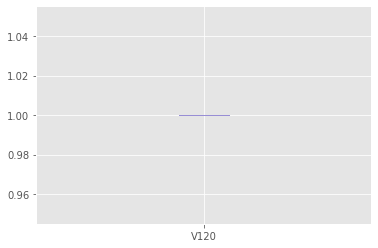

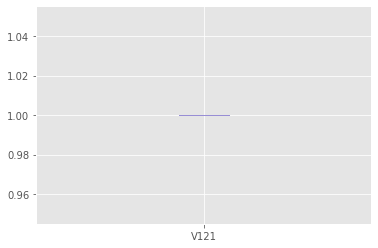

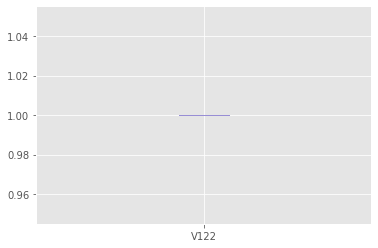

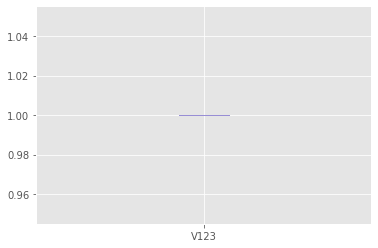

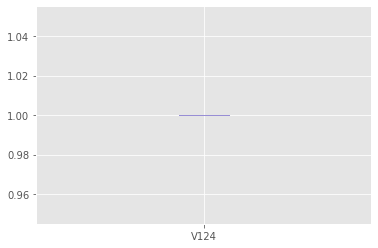

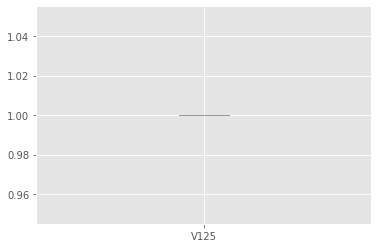

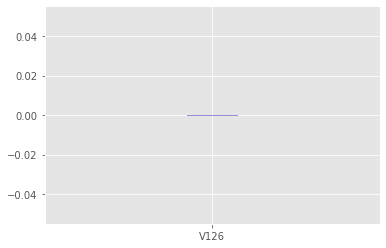

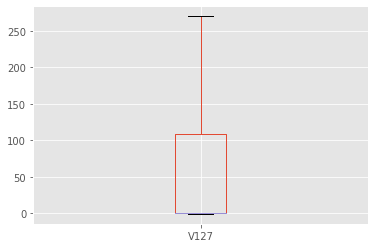

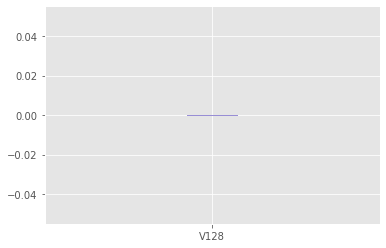

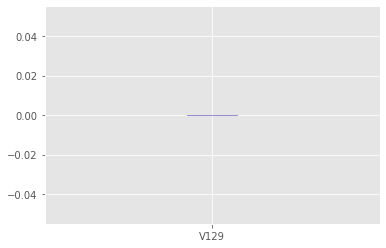

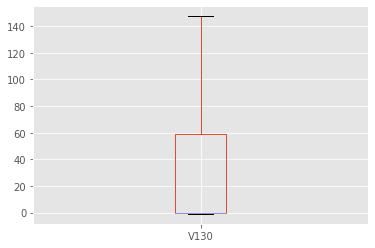

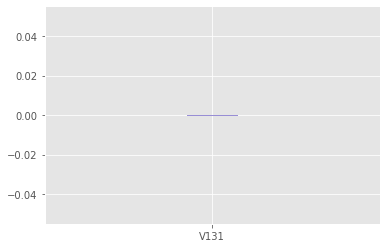

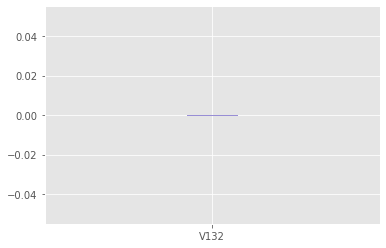

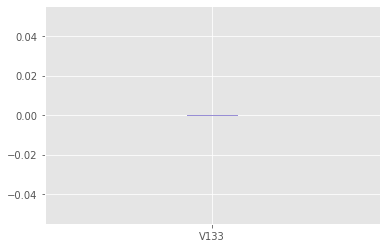

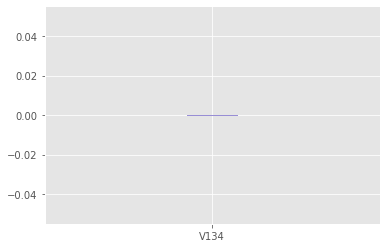

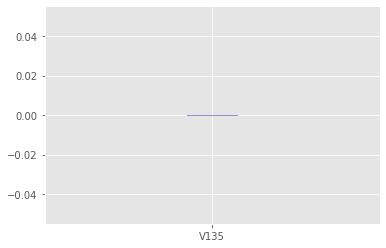

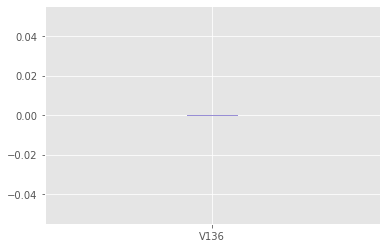

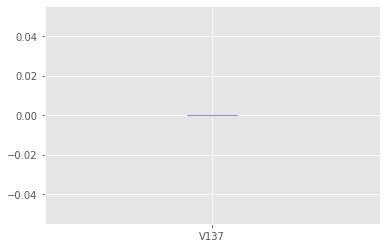

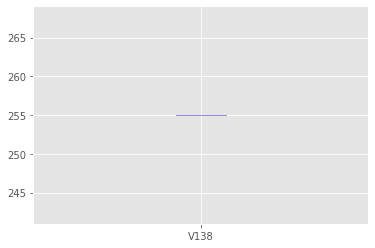

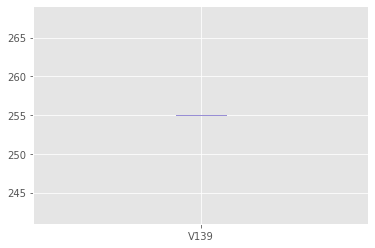

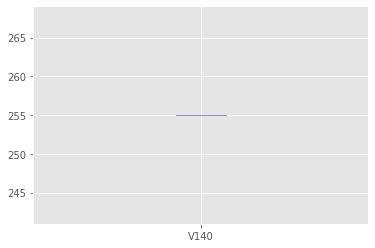

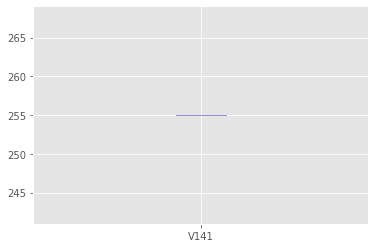

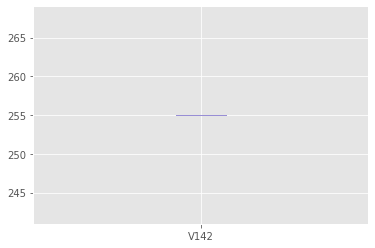

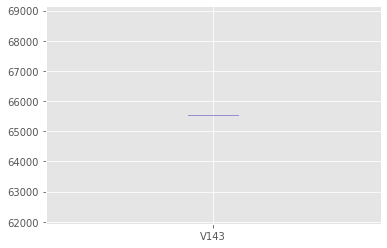

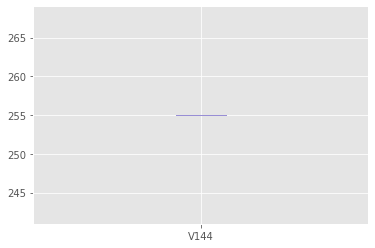

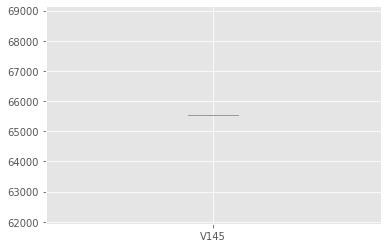

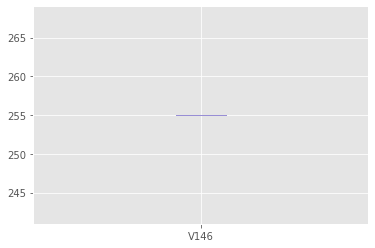

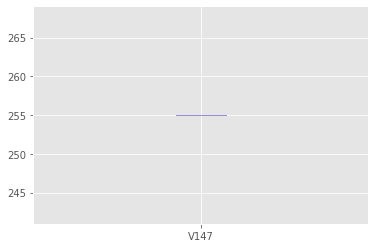

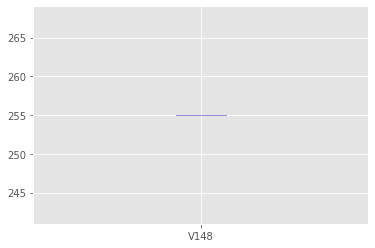

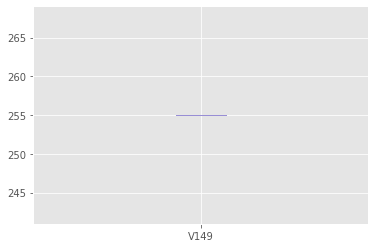

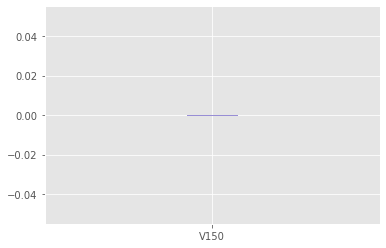

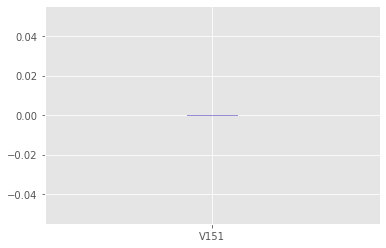

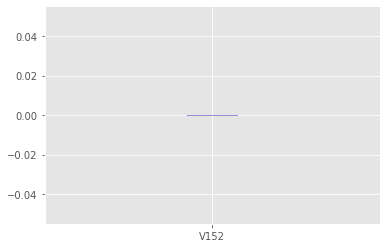

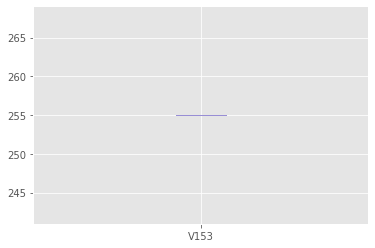

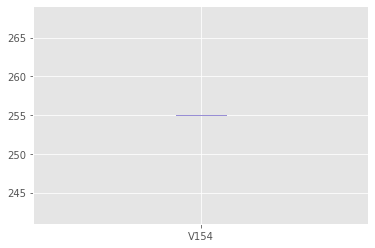

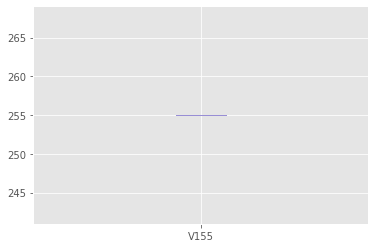

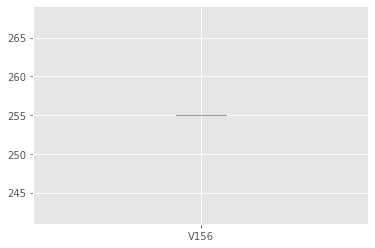

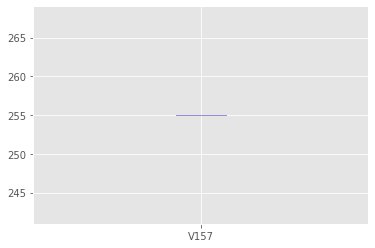

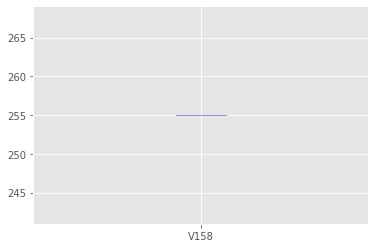

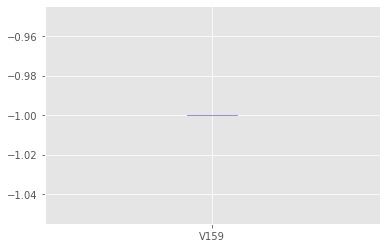

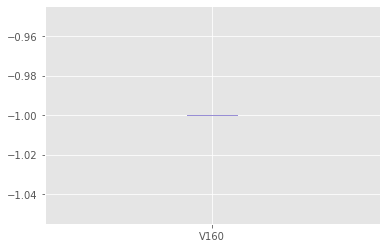

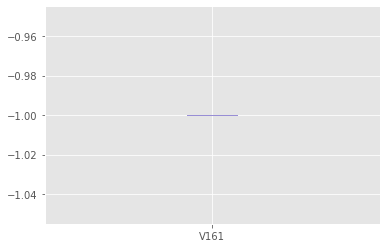

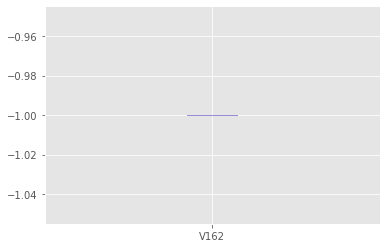

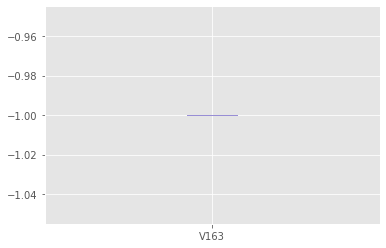

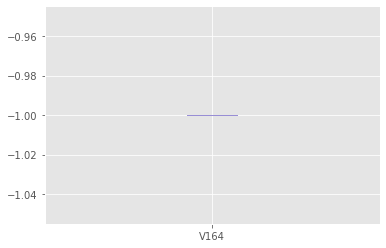

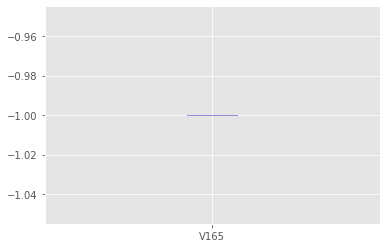

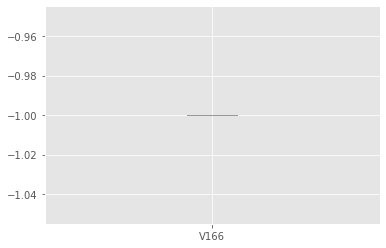

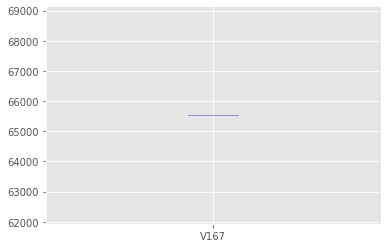

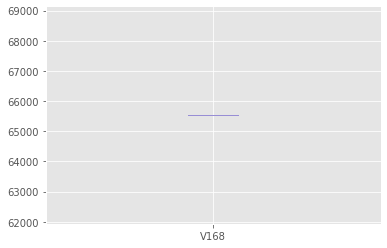

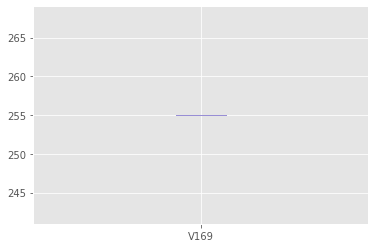

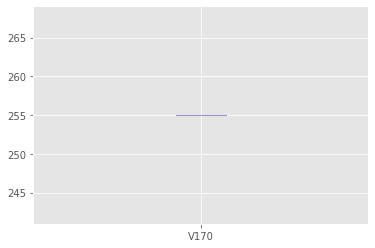

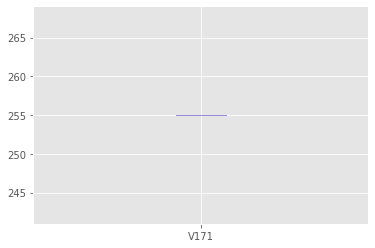

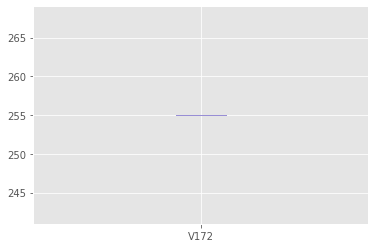

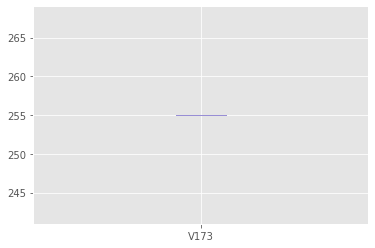

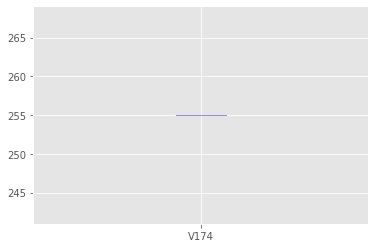

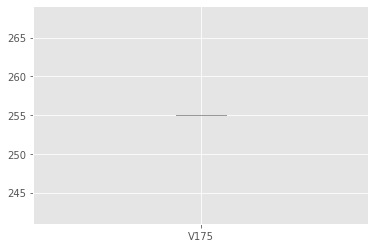

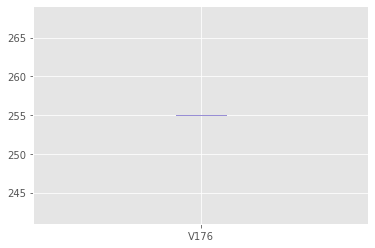

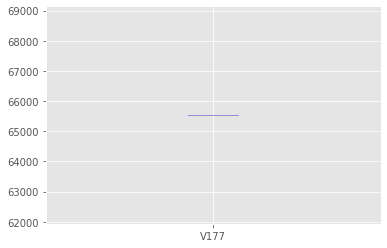

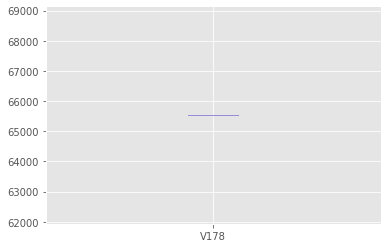

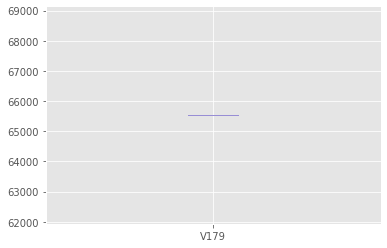

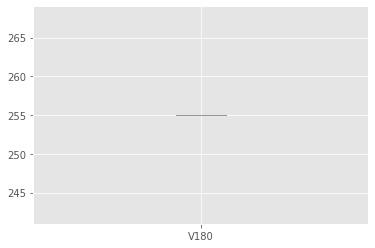

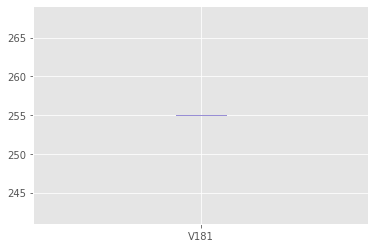

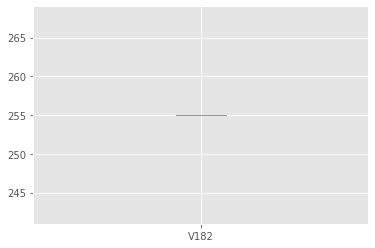

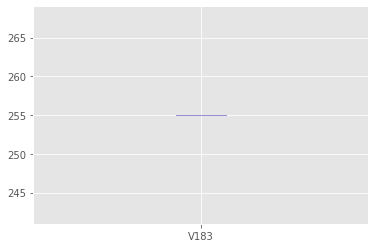

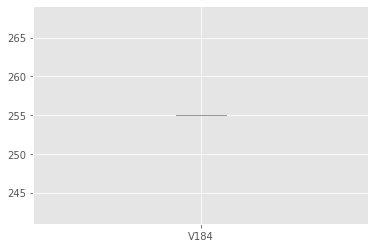

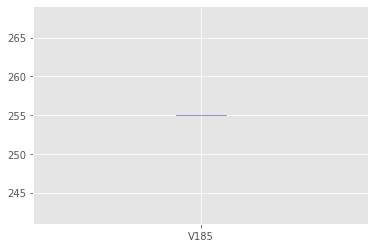

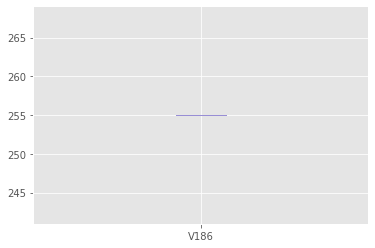

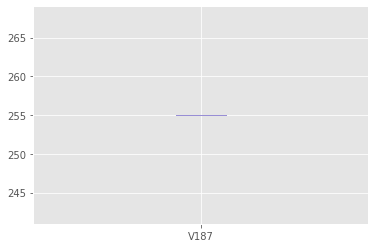

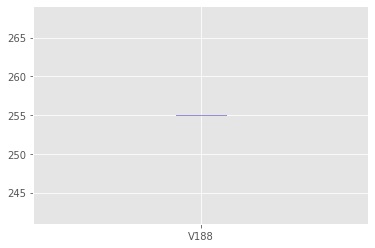

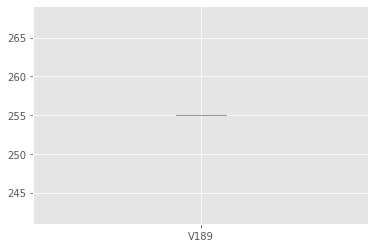

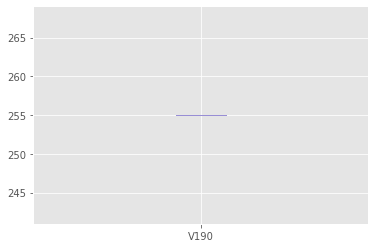

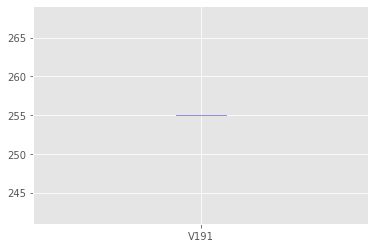

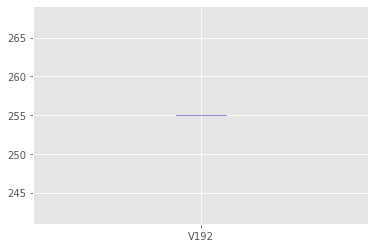

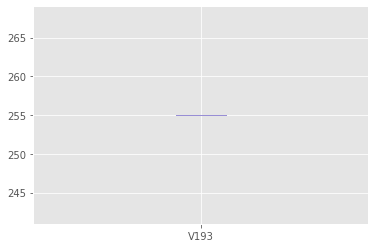

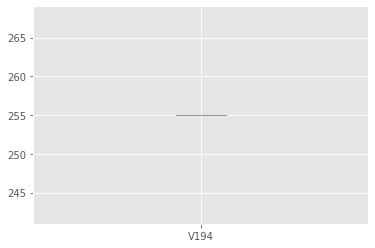

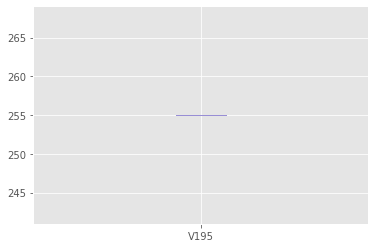

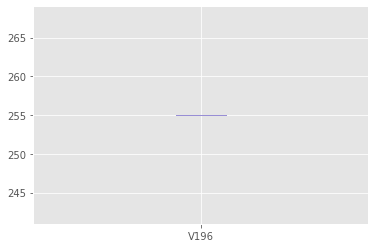

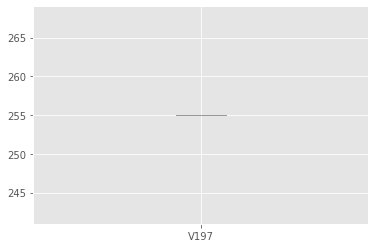

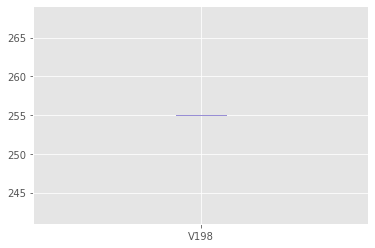

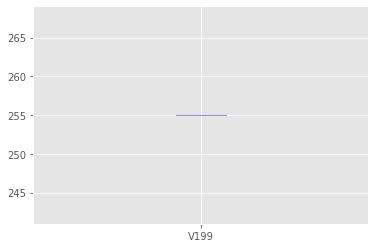

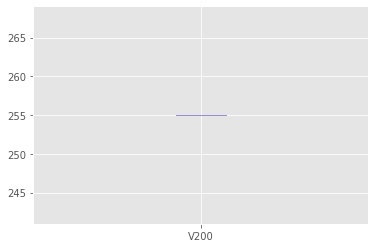

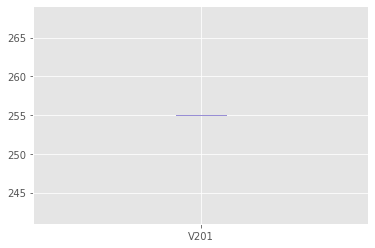

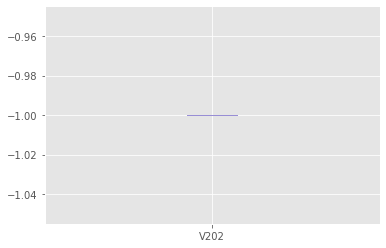

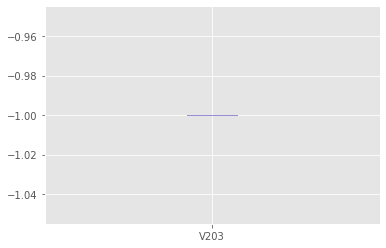

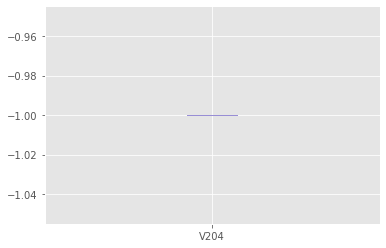

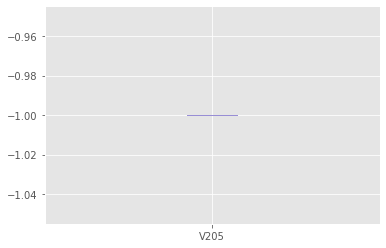

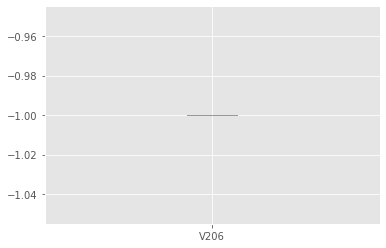

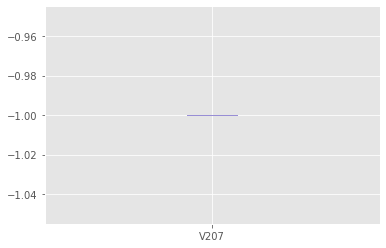

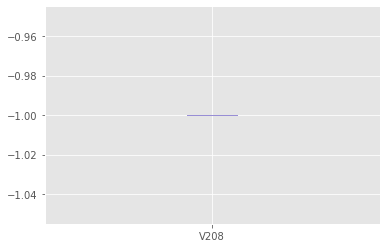

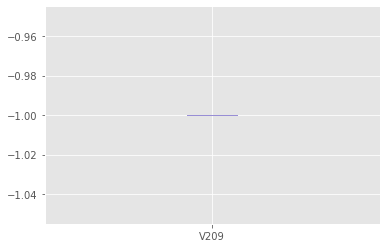

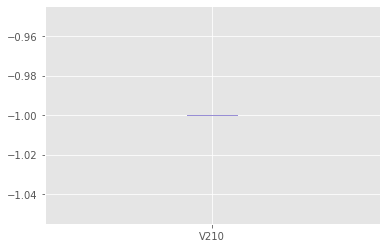

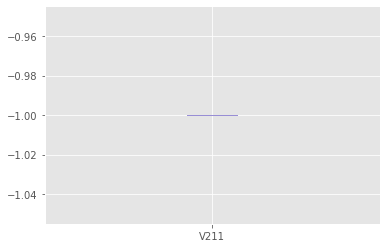

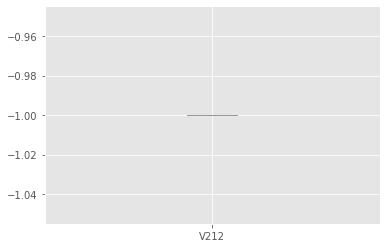

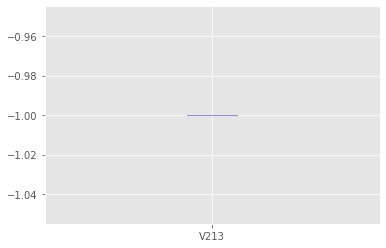

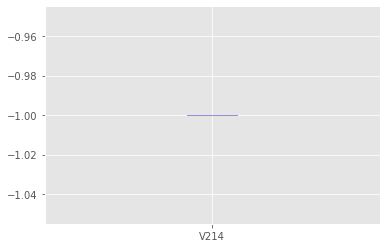

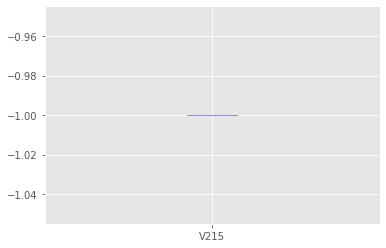

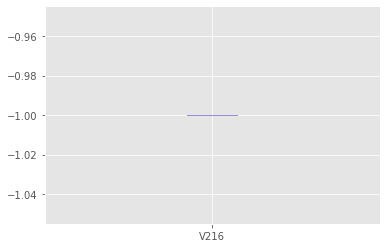

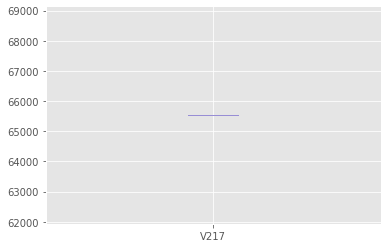

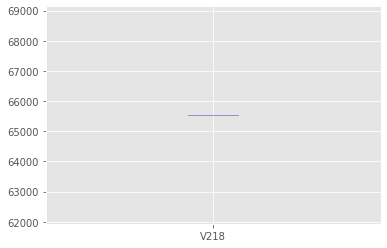

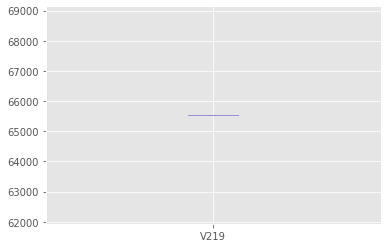

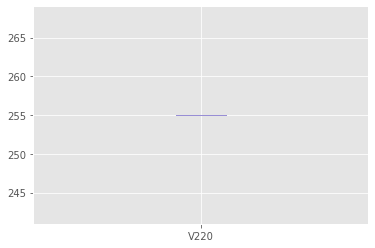

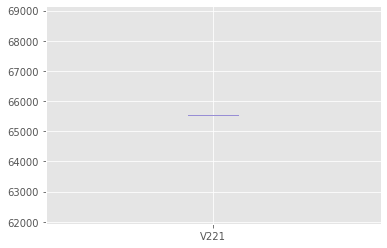

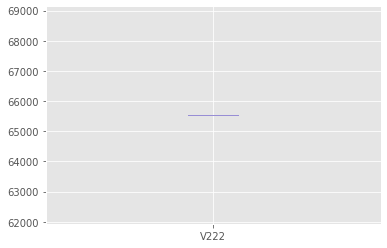

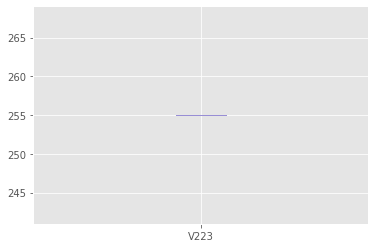

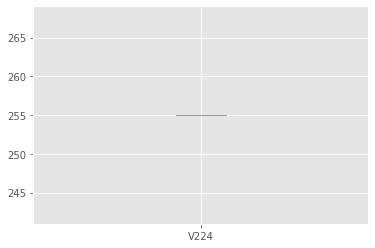

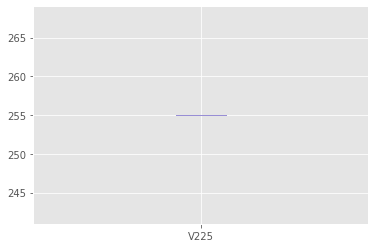

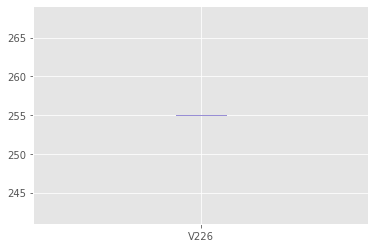

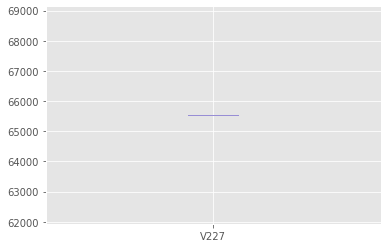

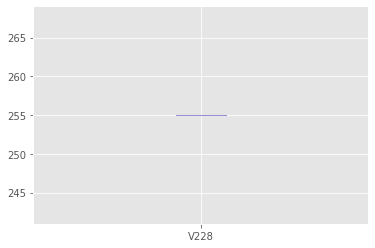

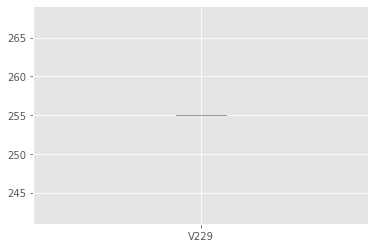

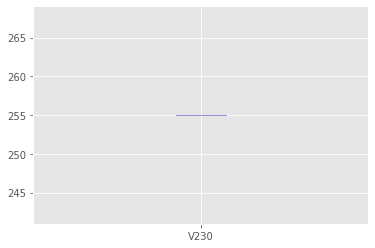

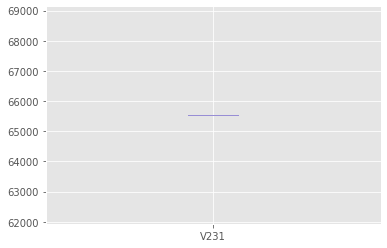

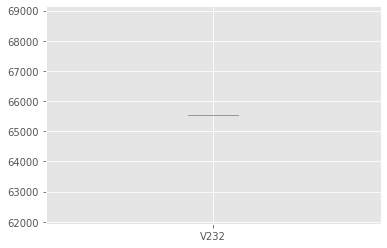

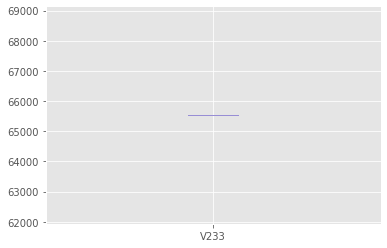

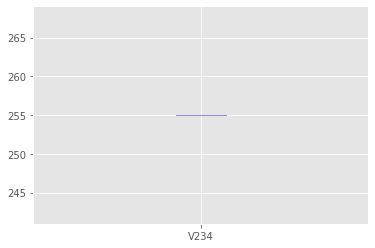

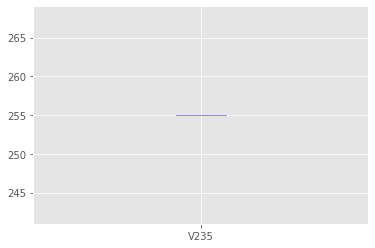

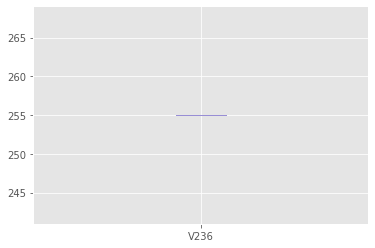

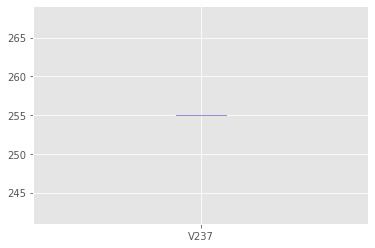

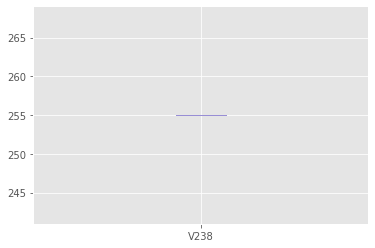

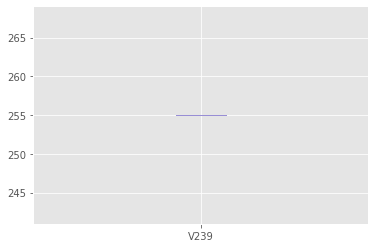

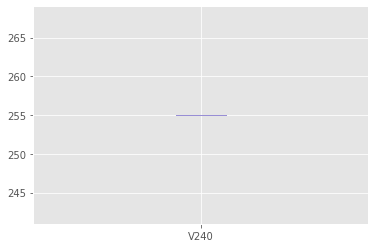

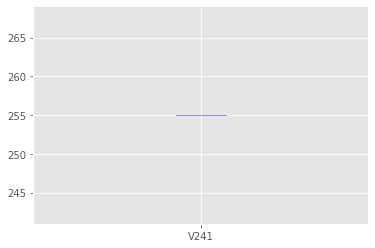

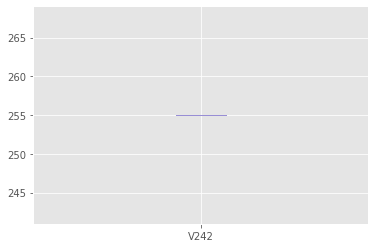

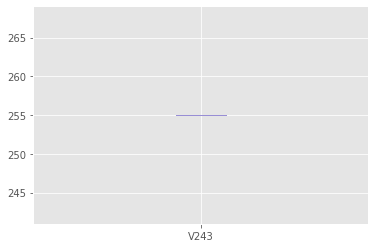

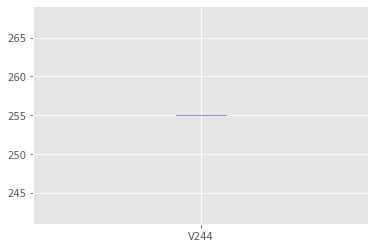

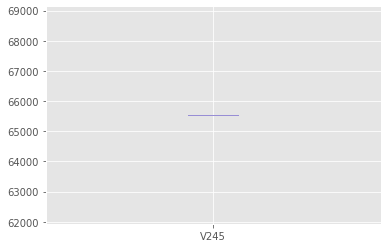

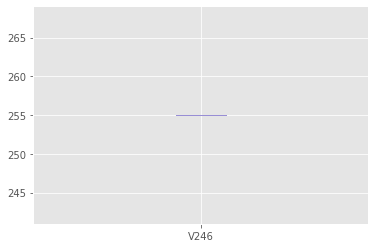

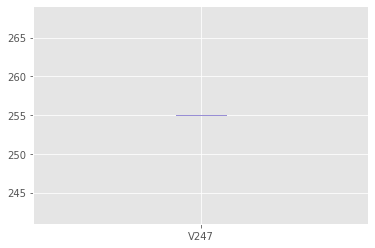

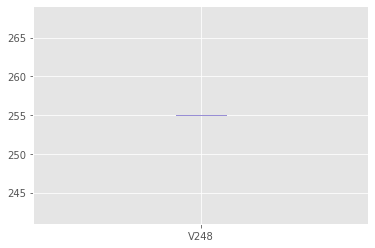

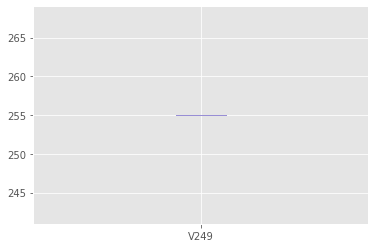

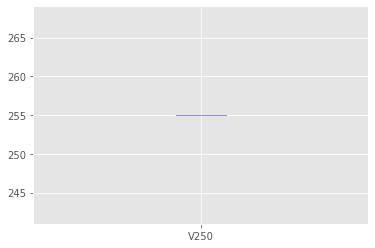

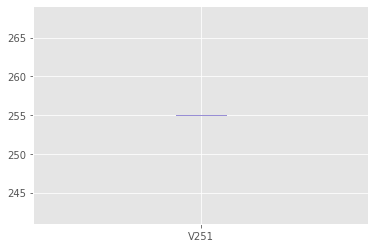

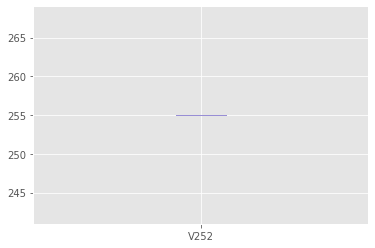

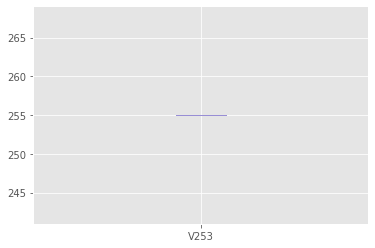

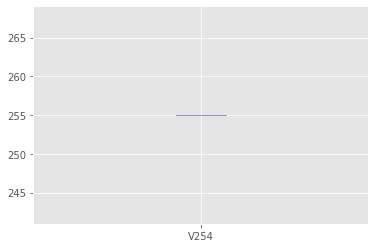

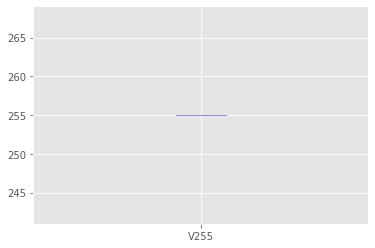

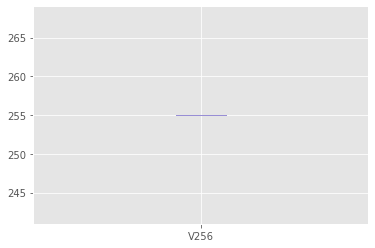

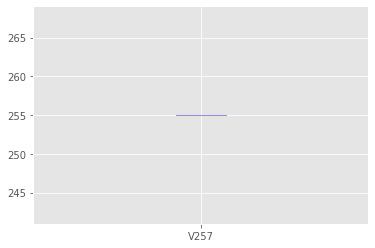

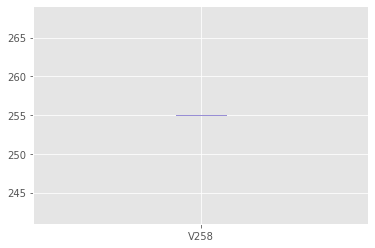

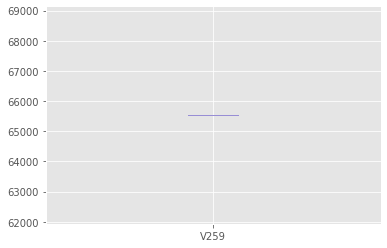

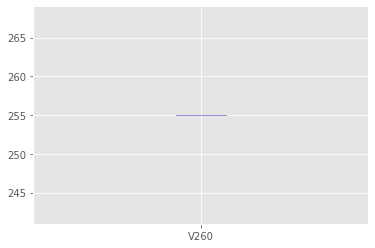

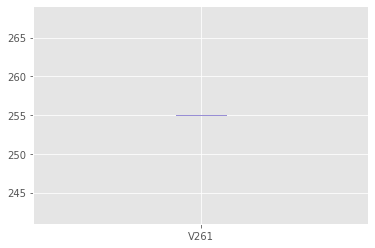

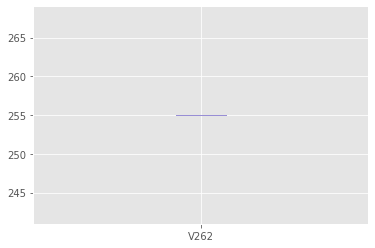

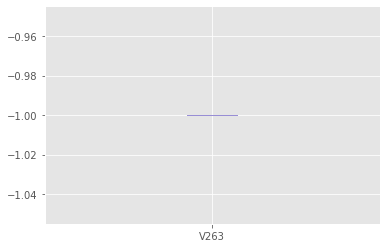

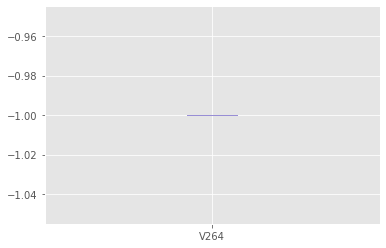

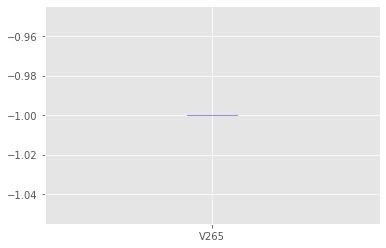

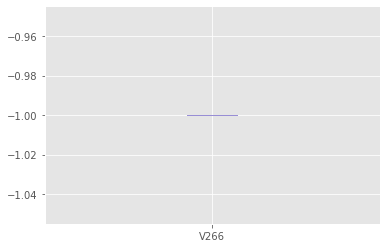

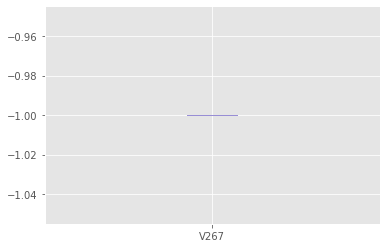

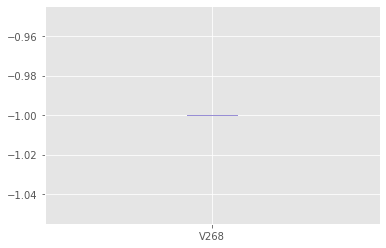

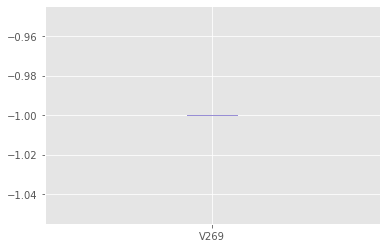

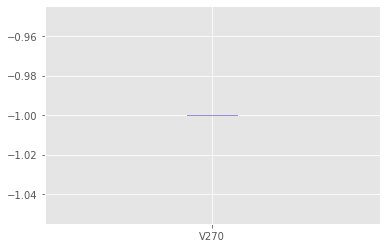

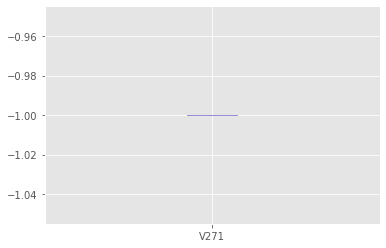

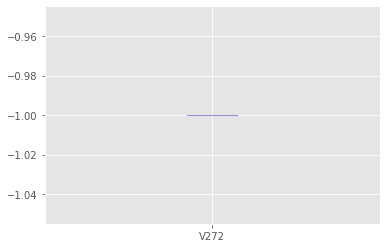

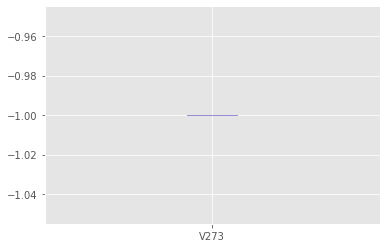

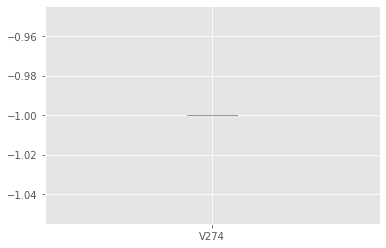

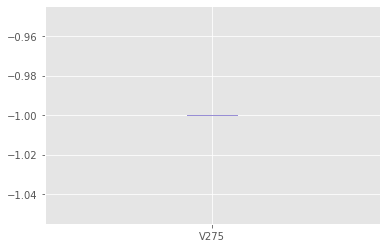

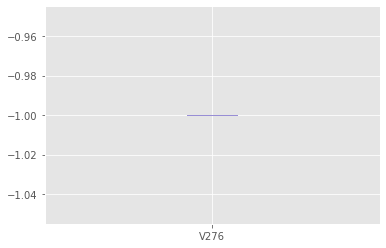

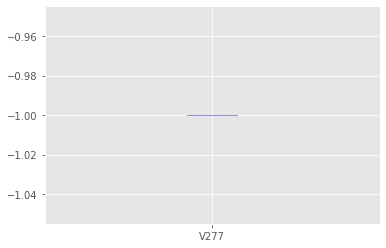

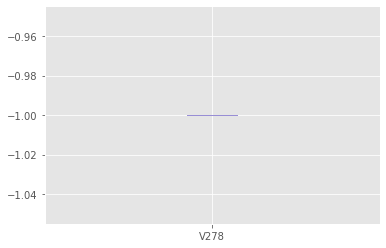

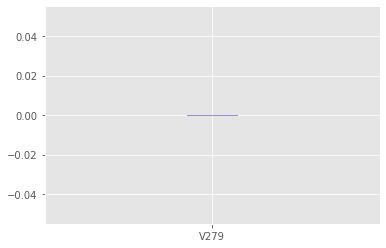

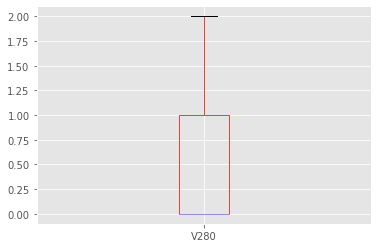

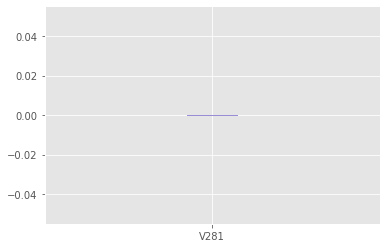

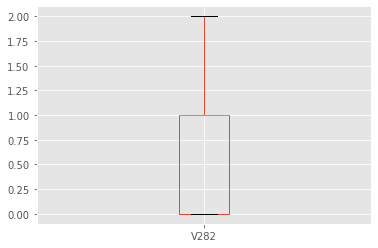

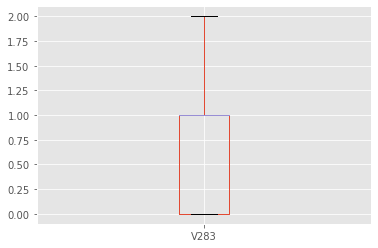

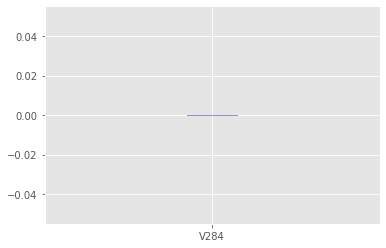

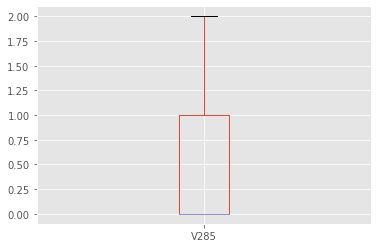

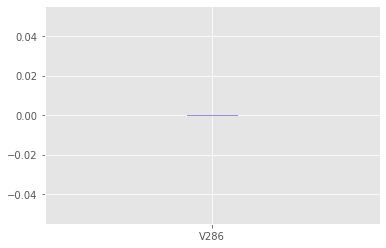

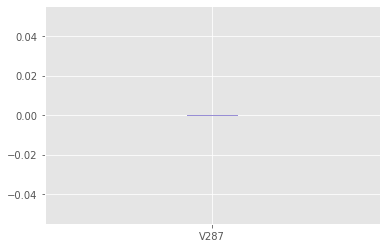

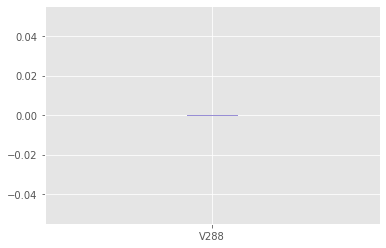

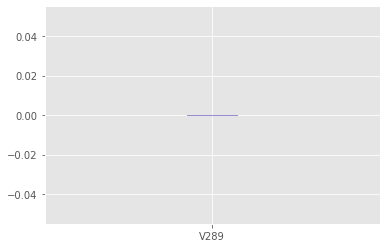

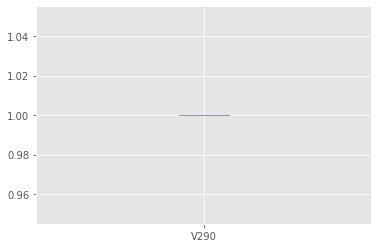

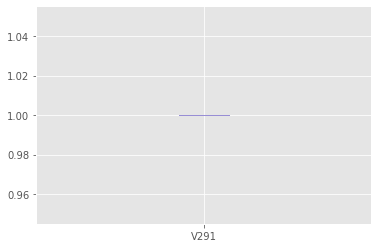

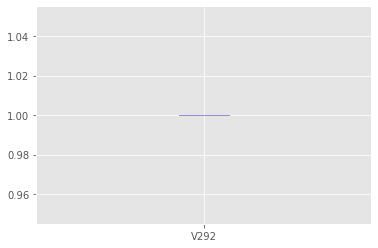

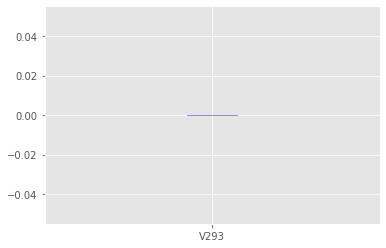

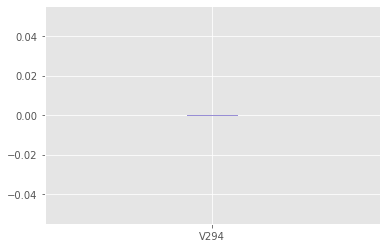

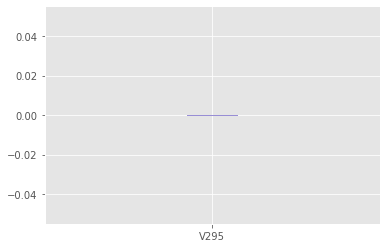

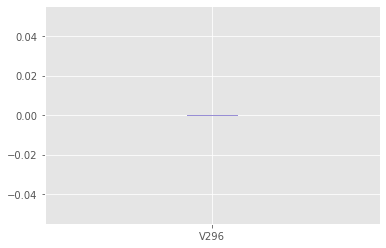

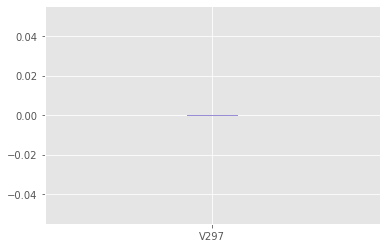

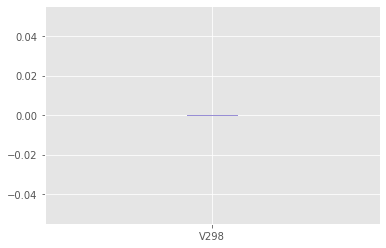

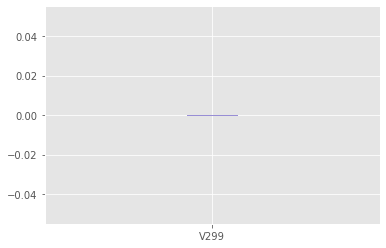

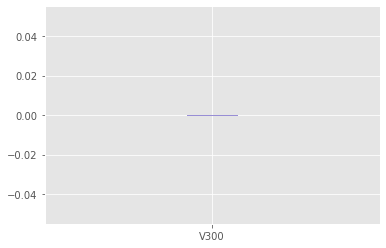

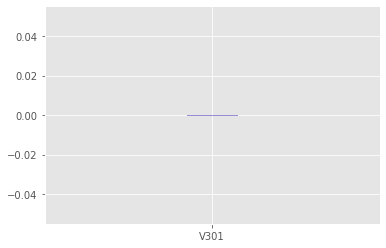

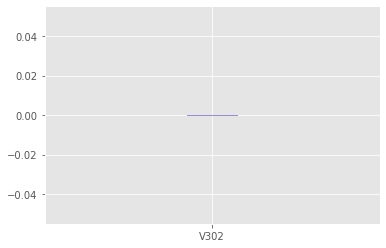

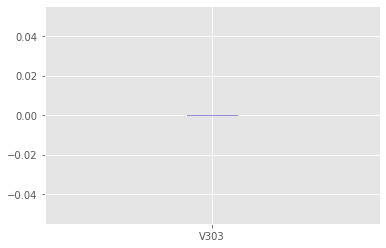

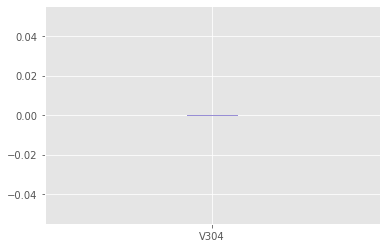

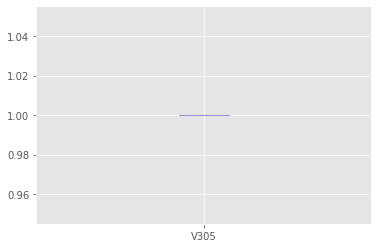

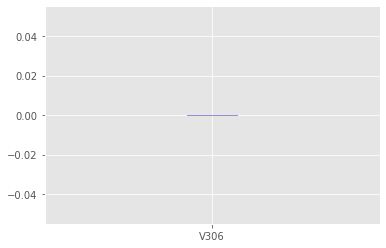

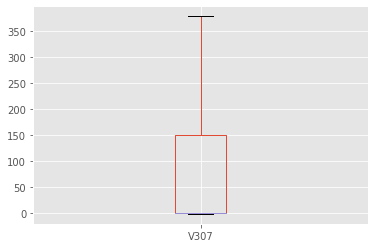

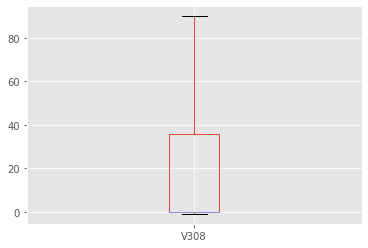

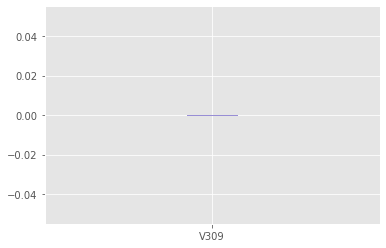

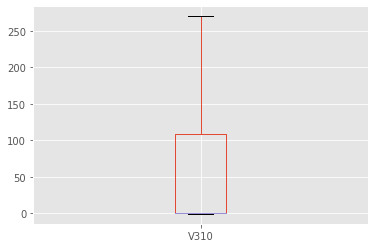

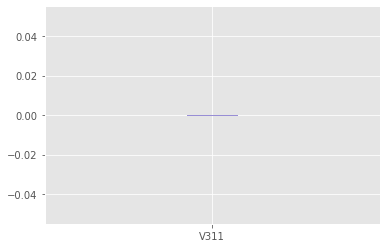

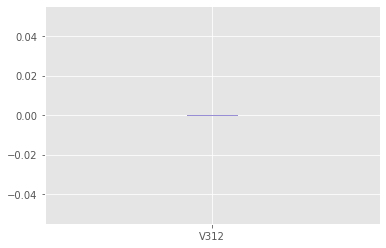

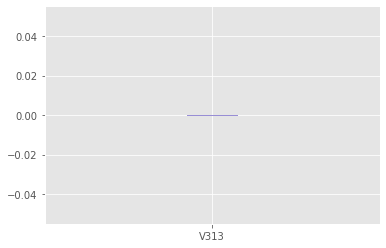

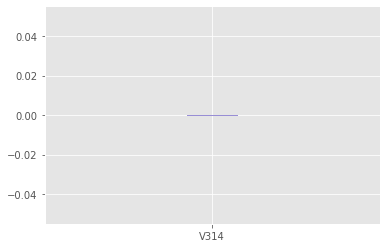

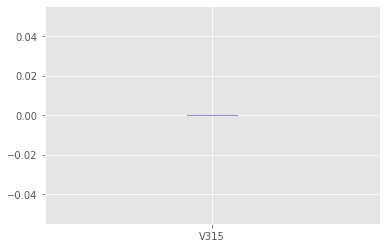

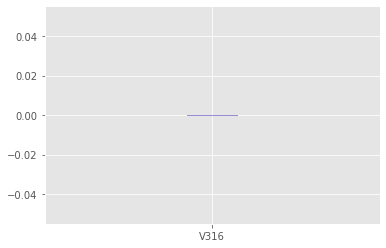

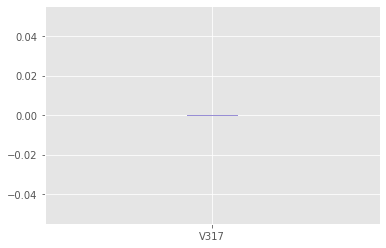

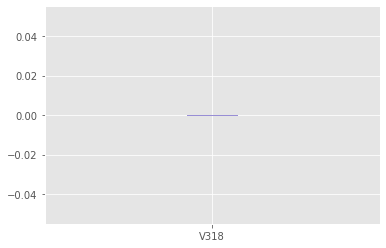

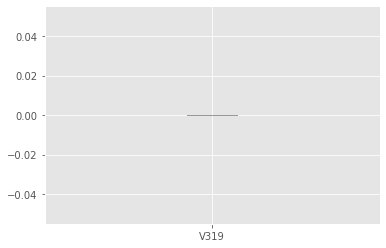

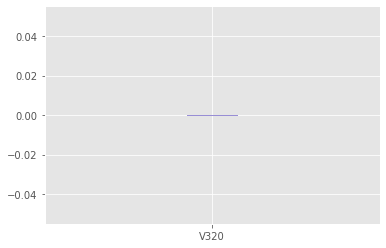

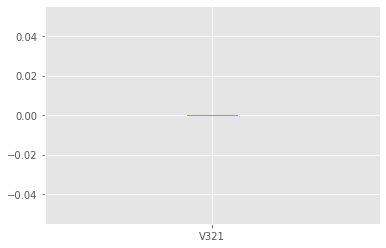

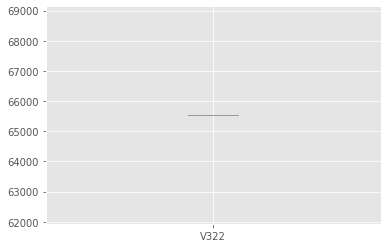

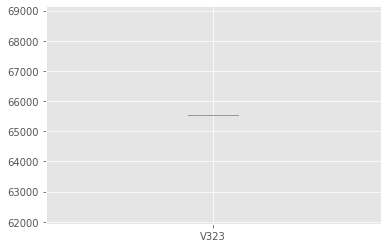

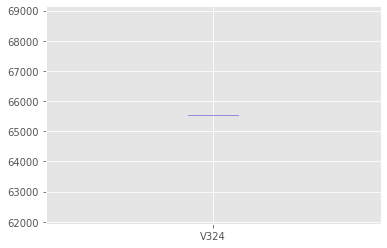

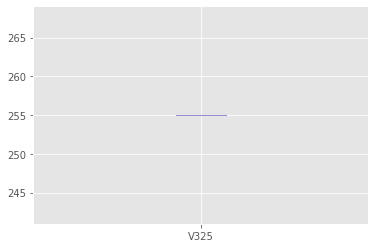

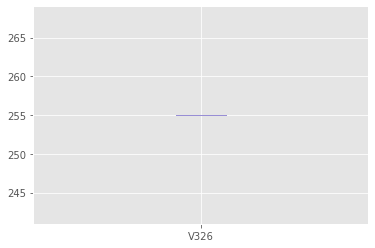

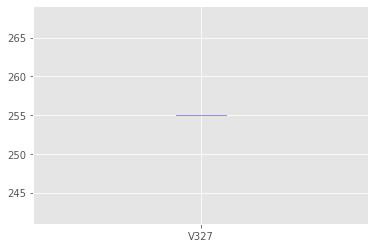

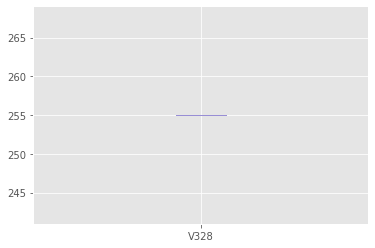

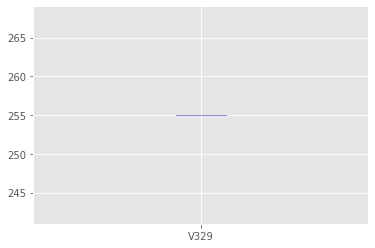

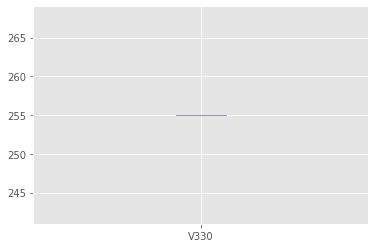

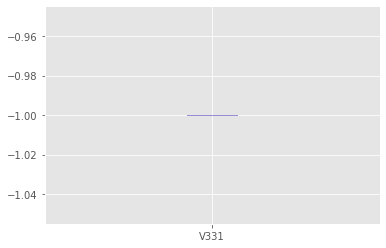

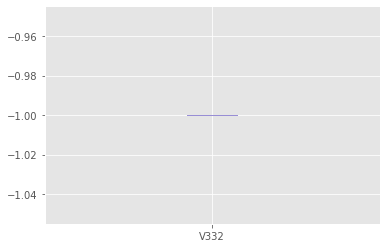

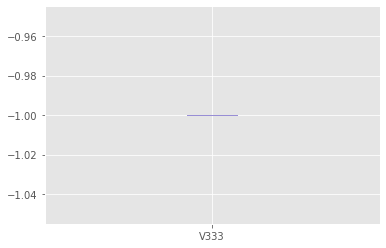

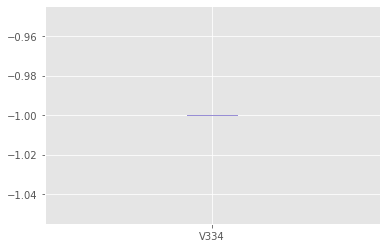

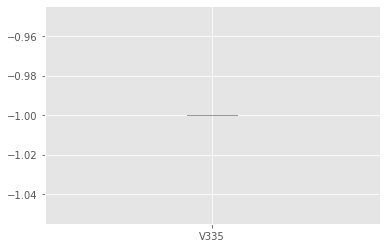

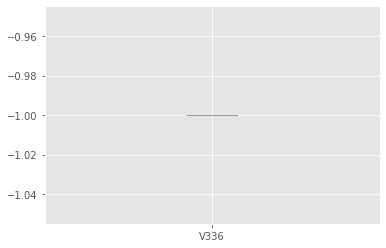

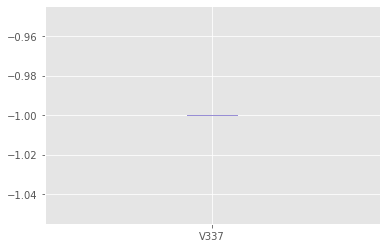

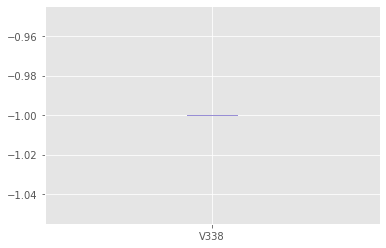

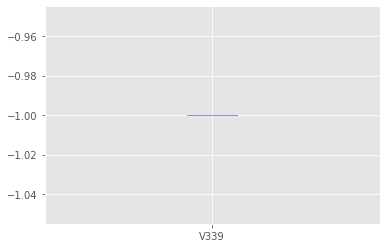

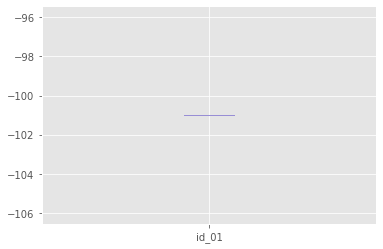

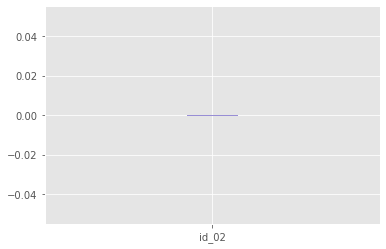

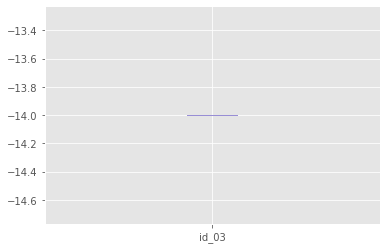

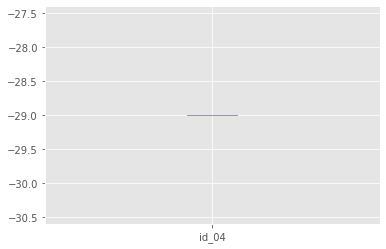

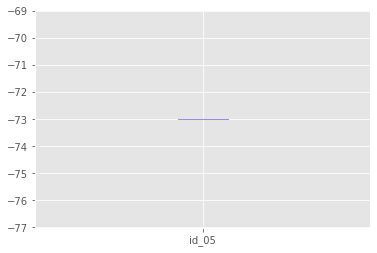

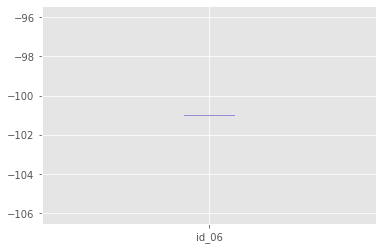

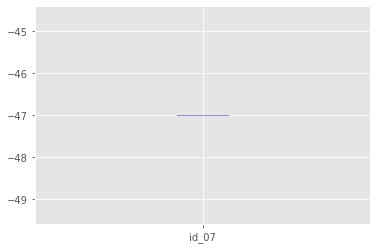

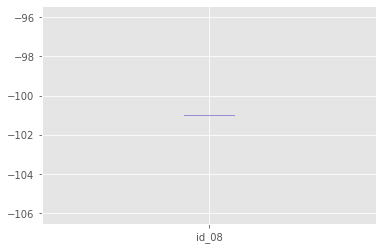

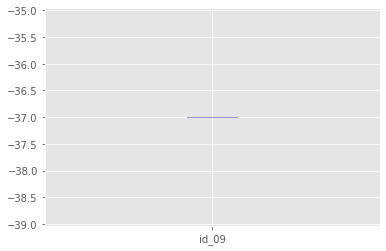

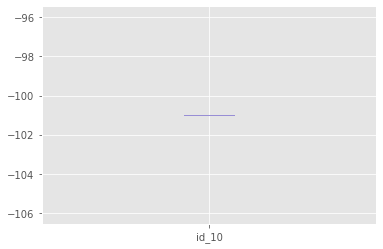

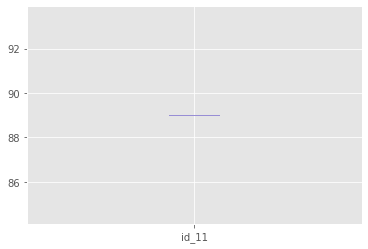

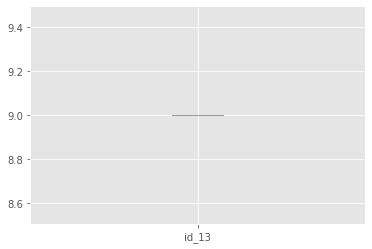

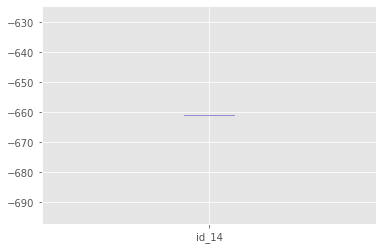

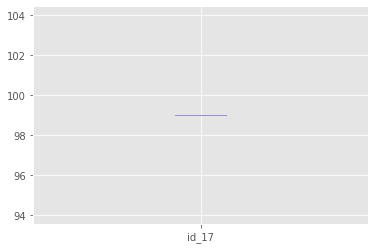

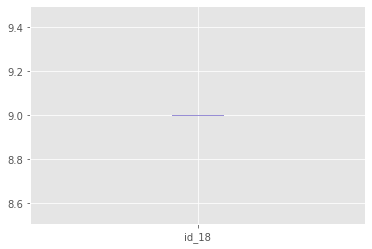

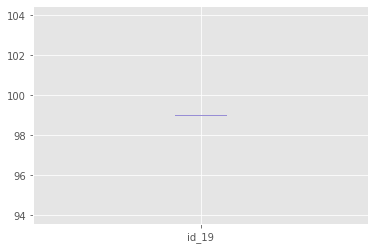

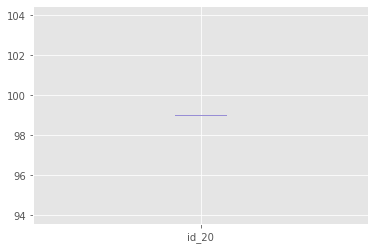

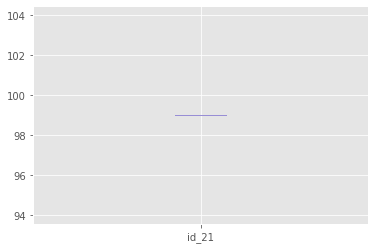

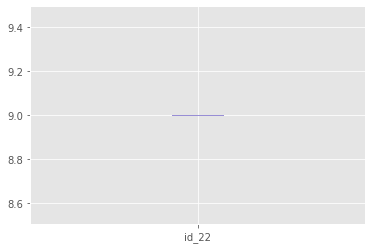

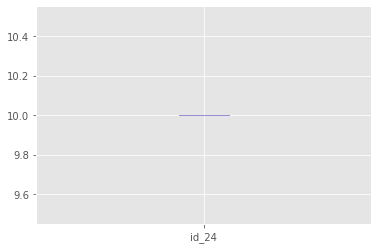

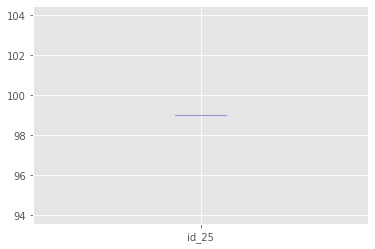

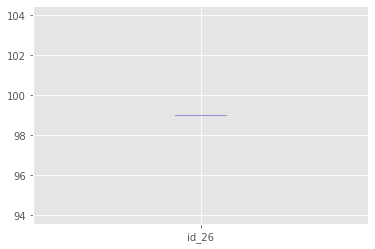

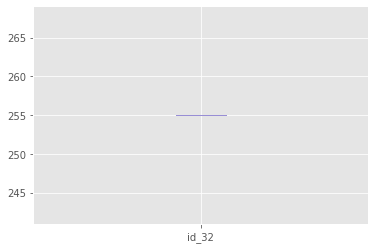

In [127]:
## Box Plot for Numeric via categorial

import matplotlib.pyplot as plt

for column in df_train_numeric:
    plt.figure()
    #df_train_numeric.boxplot([column])
    sns.boxplot(x='column', y=isFraud, data=df_train_numeric)

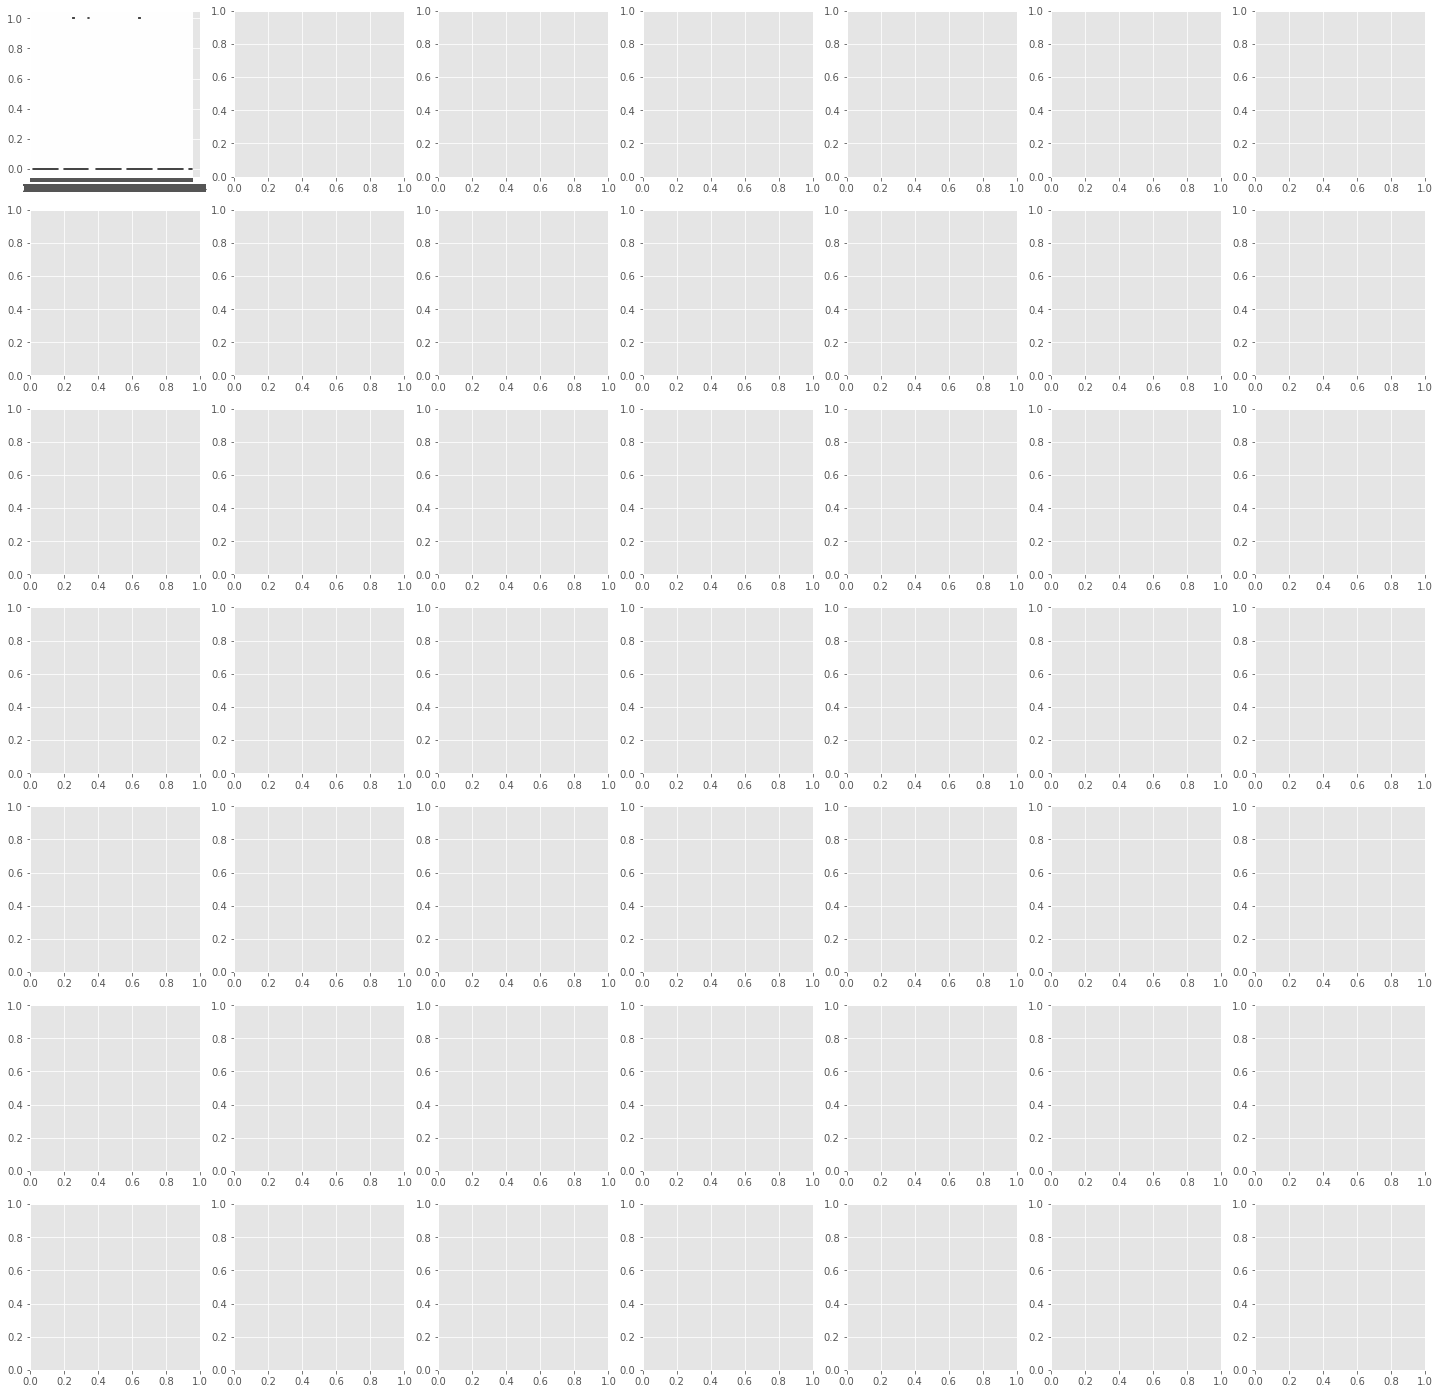

In [209]:
fig, ax = plt.subplots(7, 7, figsize=(25, 25))
for var, subplot in zip(df_train_numeric.columns, ax.flatten()):
    sns.boxplot(x=var, y='isFraud', data=df_train, ax=subplot)

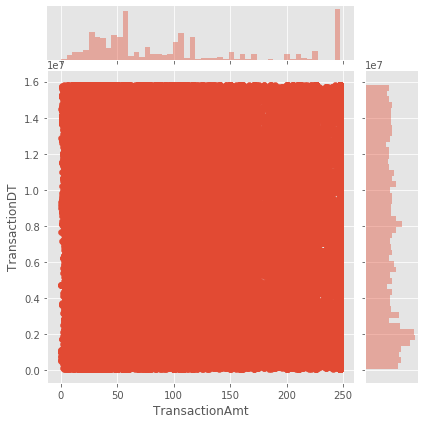

In [178]:
sns.jointplot(x=df_train_numeric['TransactionAmt'], y=df_train_numeric['TransactionDT']);

## Analyzing Relationships Between Numerical Variables
Scatter Plot for Numeric via numeric

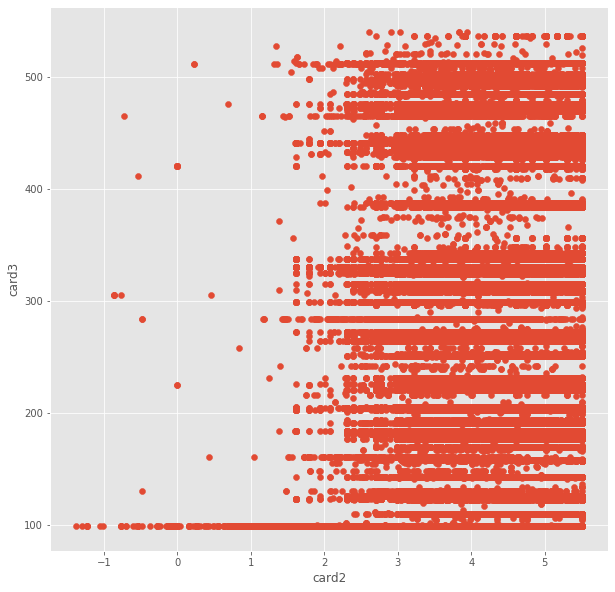

In [126]:
## Scatter plots numeric via numeric

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df_train_numeric['TransactionAmt'], df_train_numeric['addr1'])
ax.set_xlabel('card2')
ax.set_ylabel('card3')
plt.show()

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(15, 10))
for var, subplot in zip(categorical, ax.flatten()):
    sns.scatterplot(x=var, y='SalePrice', data=housing, ax=subplot)

In [41]:
df_train[df_train.isFraud==1].sum()['isFraud']


20663

In [42]:
df_train[df_train.isFraud==0].count()['isFraud']

569877

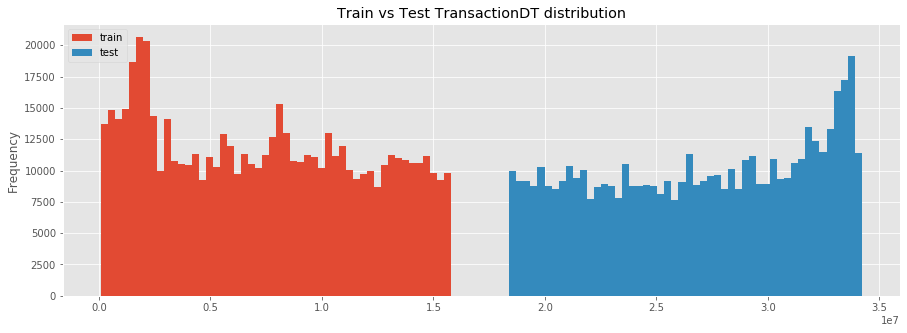

In [43]:
df_train['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
df_test['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

In [44]:
def make_day_feature(df, offset=0, tname='TransactionDT'):
    """
    Creates a day of the week feature, encoded as 0-6. 
    
    Parameters:
    -----------
    df : pd.DataFrame
        df to manipulate.
    offset : float (default=0)
        offset (in days) to shift the start/end of a day.
    tname : str
        Name of the time column in df.
    """
    # found a good offset is 0.58
    days = df[tname] / (3600*24)        
    encoded_days = np.floor(days-1+offset) % 7
    return encoded_days

def make_hour_feature(df, tname='TransactionDT'):
    """
    Creates an hour of the day feature, encoded as 0-23. 
    
    Parameters:
    -----------
    df : pd.DataFrame
        df to manipulate.
    tname : str
        Name of the time column in df.
    """
    hours = df[tname] / (3600)        
    encoded_hours = np.floor(hours) % 24
    return encoded_hours

## Feature Extraction

### df_train

Text(0, 0.5, 'Number of transactions')

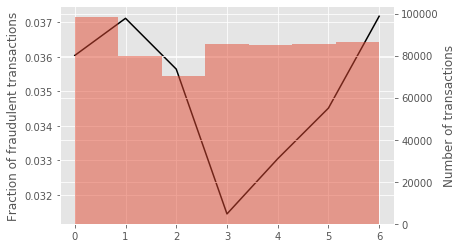

In [45]:
df_train['weekday'] = make_day_feature(df_train)
plt.plot(df_train[:590540].groupby('weekday').mean()['isFraud'], color='k')
ax = plt.gca()
ax2 = ax.twinx()
ax2.hist(df_train[:590540]['weekday'], alpha=0.5, bins=7)
ax.set_ylabel('Fraction of fraudulent transactions')
ax2.set_ylabel('Number of transactions')

Text(0, 0.5, 'Number of transactions')

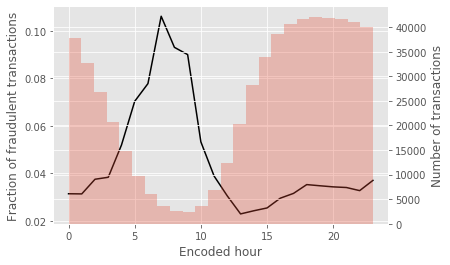

In [46]:
df_train['hours'] = make_hour_feature(df_train)
plt.plot(df_train.groupby('hours').mean()['isFraud'], color='k')
ax = plt.gca()
ax2 = ax.twinx()
_ = ax2.hist(df_train['hours'], alpha=0.3, bins=24)
ax.set_xlabel('Encoded hour')
ax.set_ylabel('Fraction of fraudulent transactions')

ax2.set_ylabel('Number of transactions')

### Conclusion
The day of the week does not seem like a very powerful feature, however the hour of the day is very likely to be a useful feature to include in models.

## Adding weekday and hour variables to df_test

In [198]:
df_test['weekday'] = make_day_feature(df_test)
df_test['weekday'].describe()

count    506691.000000
mean          2.996651
std           2.018955
min           0.000000
25%           1.000000
50%           3.000000
75%           5.000000
max           6.000000
Name: weekday, dtype: float64

(array([81242., 66389., 61058., 77145., 76695., 73316., 70846.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

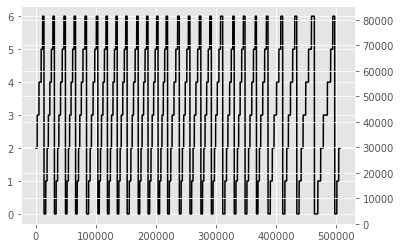

In [204]:
plt.plot(df_test[:506691]['weekday'], color='k')
ax = plt.gca()
ax2 = ax.twinx()
ax2.hist(df_test[:506691]['weekday'], alpha=0.5, bins=7)


In [197]:
df_test['hours'] = make_hour_feature(df_test)
df_test['hours'].describe()

count    506691.000000
mean         13.961448
std           7.475648
min           0.000000
25%           8.000000
50%          16.000000
75%          20.000000
max          23.000000
Name: hours, dtype: float64

Text(0.5, 0, 'Encoded hour')

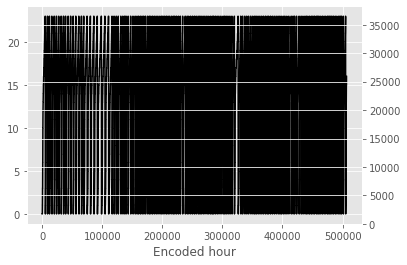

In [205]:
df_test['hours'] = make_hour_feature(df_train)
plt.plot(df_test['hours'], color='k')
ax = plt.gca()
ax2 = ax.twinx()
_ = ax2.hist(df_test['hours'], alpha=0.3, bins=24)
ax.set_xlabel('Encoded hour')


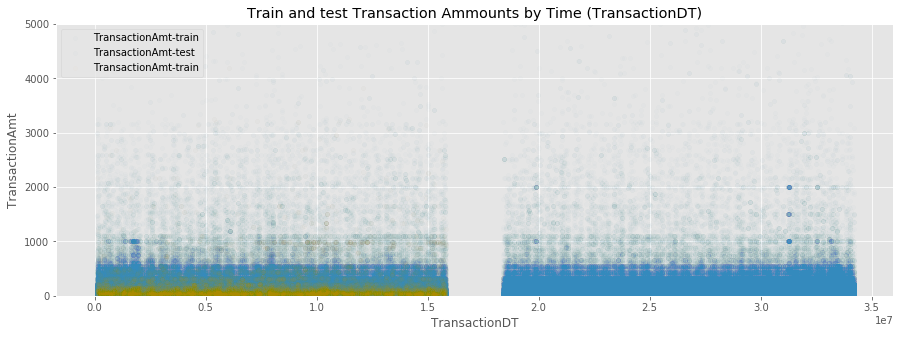

In [47]:
ax = df_train.plot(x='TransactionDT',
                       y='TransactionAmt',
                       kind='scatter',
                       alpha=0.01,
                       label='TransactionAmt-train',
                       title='Train and test Transaction Ammounts by Time (TransactionDT)',
                       ylim=(0, 5000),
                       figsize=(15, 5))
df_test.plot(x='TransactionDT',
                      y='TransactionAmt',
                      kind='scatter',
                      label='TransactionAmt-test',
                      alpha=0.01,
                      color=color_pal[1],
                       ylim=(0, 5000),
                      ax=ax)
# Plot Fraud as Orange
df_train.loc[df_train['isFraud'] == 1] \
    .plot(x='TransactionDT',
         y='TransactionAmt',
         kind='scatter',
         alpha=0.01,
         label='TransactionAmt-train',
         title='Train and test Transaction Ammounts by Time (TransactionDT)',
         ylim=(0, 5000),
         color='orange',
         figsize=(15, 5),
         ax=ax)
plt.show()

## Distribution of Target in Training Set
### 3.5% of transacations are fraud

In [48]:
print('  {:.4f}% of Transactions that are fraud in train '.format(df_train['isFraud'].mean() * 100))

  3.4990% of Transactions that are fraud in train 


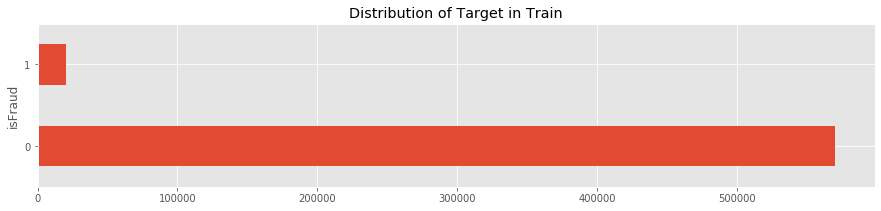

In [49]:
df_train.groupby('isFraud') \
    .count()['TransactionID'] \
    .plot(kind='barh',
          title='Distribution of Target in Train',
          figsize=(15, 3))
plt.show()

TransactionAmt
The ammount of transaction. I've taken a log transform in some of these plots to better show the distribution- otherwise the few, very large transactions skew the distribution. Because of the log transfrom, any values between 0 and 1 will appear to be negative.

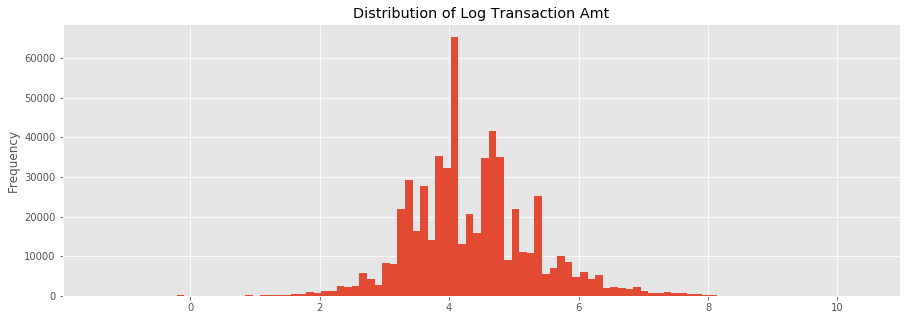

In [50]:
df_train['TransactionAmt'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          figsize=(15, 5),
          title='Distribution of Log Transaction Amt')
plt.show()

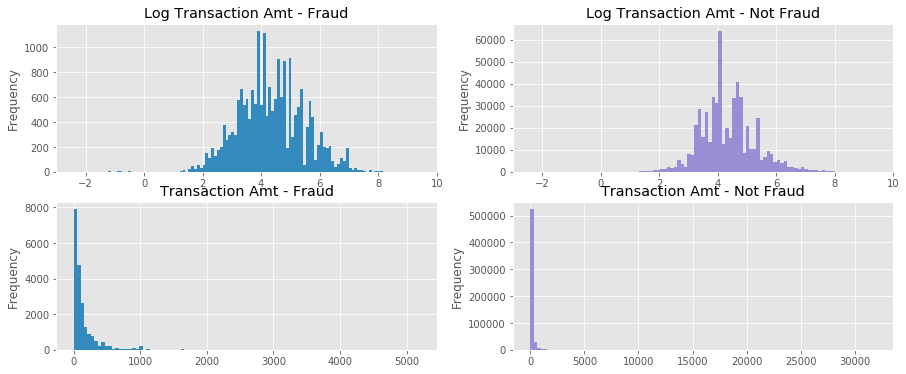

In [51]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))
df_train.loc[df_train['isFraud'] == 1] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Fraud',
          color=color_pal[1],
          xlim=(-3, 10),
         ax= ax1)
df_train.loc[df_train['isFraud'] == 0] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Not Fraud',
          color=color_pal[2],
          xlim=(-3, 10),
         ax=ax2)
df_train.loc[df_train['isFraud'] == 1] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Fraud',
          color=color_pal[1],
         ax= ax3)
df_train.loc[df_train['isFraud'] == 0] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Not Fraud',
          color=color_pal[2],
         ax=ax4)
plt.show()

## Checking for differences in the distribution
We will compare if there are a difference between the distribution of the variable when having the outliers and when the outliers are removed. We do so using the Kolmogorov–Smirnov statistic. This is a non-parametric statistic that can be used on variables without outliers.

In [143]:
from scipy.stats import ks_2samp
import numpy as np

ks = ks_2samp(df_train['TransactionAmt'], df_train['isFraud'])

In [144]:
ks

Ks_2sampResult(statistic=0.9997239814407153, pvalue=0.0)

We will iterate on each variable with a loop, and will save the results in a data frame. If the difference (p-value) is significant we will add a plus, while when the p-value is not significant, we will add a minus.

## Correlation ##

### Correlation for numeric variables

In [52]:

corrMatrix_card = df_train_card.corr()

In [53]:
corrMatrix_card

card1     card2     card3     card5
card1  1.000000  0.011555  0.002960 -0.090039
card2  0.011555  1.000000  0.048674  0.048501
card3  0.002960  0.048674  1.000000 -0.117672
card5 -0.090039  0.048501 -0.117672  1.000000

In [54]:
corrMatrix_card.head()

card1     card2     card3     card5
card1  1.000000  0.011555  0.002960 -0.090039
card2  0.011555  1.000000  0.048674  0.048501
card3  0.002960  0.048674  1.000000 -0.117672
card5 -0.090039  0.048501 -0.117672  1.000000

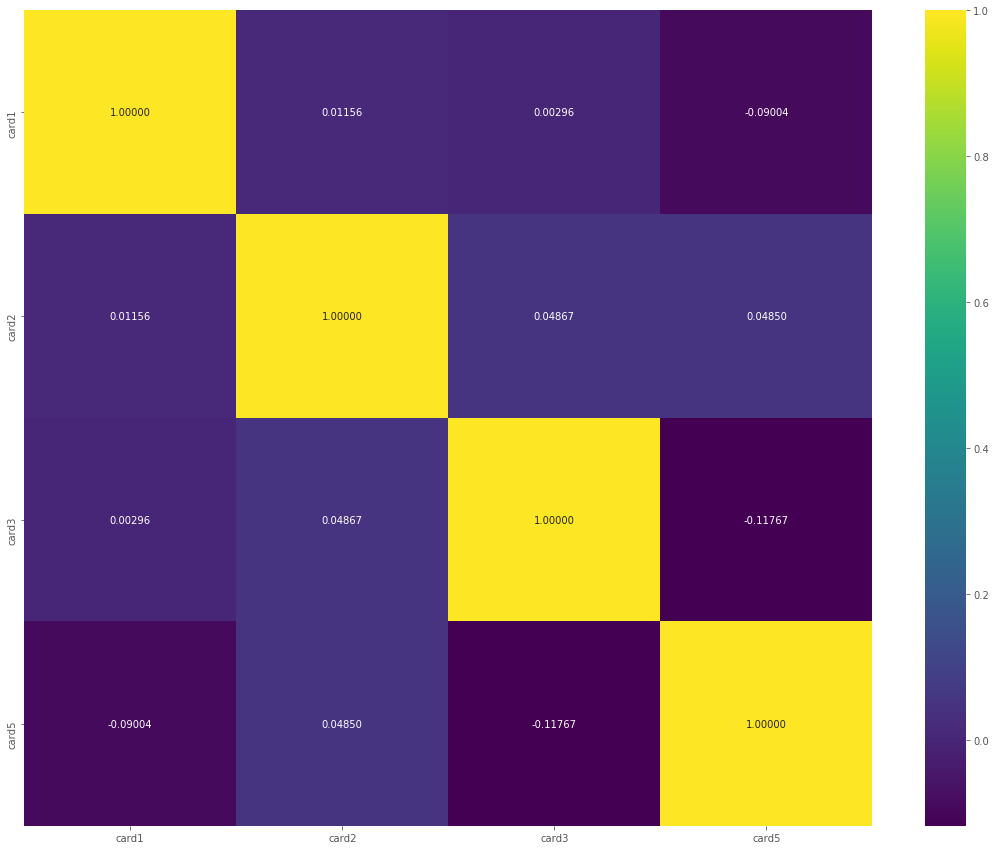

In [55]:
plt.figure(figsize=(19, 15))
sns.heatmap(corrMatrix_card,annot=True, fmt=".5f", cmap='viridis')

In [56]:
high_corr_var_card=np.where(corrMatrix_card > 0.8)
high_corr_var_card=[(corrMatrix_card.index[x],corrMatrix_card.columns[y]) for x,y in zip(*high_corr_var_card) if x!=y and x<y]

In [57]:
high_corr_var_card

[]

In [58]:

corrMatrix_c = df_train_C.corr()

In [59]:
corrMatrix_c

C1        C2        C3        C4        C5        C6        C7  \
C1   1.000000  0.995089 -0.003467  0.967800  0.165862  0.982238  0.926258   
C2   0.995089  1.000000 -0.003339  0.972134  0.126540  0.974845  0.938867   
C3  -0.003467 -0.003339  1.000000 -0.001720 -0.008101 -0.004711 -0.001730   
C4   0.967800  0.972134 -0.001720  1.000000 -0.012842  0.962319  0.895092   
C5   0.165862  0.126540 -0.008101 -0.012842  1.000000  0.232409 -0.009970   
C6   0.982238  0.974845 -0.004711  0.962319  0.232409  1.000000  0.858583   
C7   0.926258  0.938867 -0.001730  0.895092 -0.009970  0.858583  1.000000   
C8   0.967746  0.975863 -0.001203  0.959995 -0.011654  0.921972  0.982983   
C9   0.175999  0.133566 -0.010074 -0.015970  0.925786  0.250695 -0.012399   
C10  0.958202  0.970624 -0.001494  0.952466 -0.011846  0.914440  0.985062   
C11  0.996515  0.993898 -0.003583  0.974547  0.168862  0.991105  0.915209   
C12  0.927939  0.940258 -0.001763  0.894619 -0.009875  0.858182  0.999489   
C13  0.774603  0.751221 -0.007747  0.644549  0.717509  0.808531  0.632394   
C14  0.951761  0.936148 -0.005091  0.907676  0.378950  0.984201  0.794701   

           C8        C9       C10       C11       C12       C13       C14  
C1   0.967746  0.175999  0.958202  0.996515  0.927939  0.774603  0.951761  
C2   0.975863  0.133566  0.970624  0.993898  0.940258  0.751221  0.936148  
C3  -0.001203 -0.010074 -0.001494 -0.003583 -0.001763 -0.007747 -0.005091  
C4   0.959995 -0.015970  0.952466  0.974547  0.894619  0.644549  0.907676  
C5  -0.011654  0.925786 -0.011846  0.168862 -0.009875  0.717509  0.378950  
C6   0.921972  0.250695  0.914440  0.991105  0.858182  0.808531  0.984201  
C7   0.982983 -0.012399  0.985062  0.915209  0.999489  0.632394  0.794701  
C8   1.000000 -0.014492  0.996970  0.962722  0.983027  0.653245  0.860246  
C9  -0.014492  1.000000 -0.014731  0.182446 -0.012212  0.704056  0.397396  
C10  0.996970 -0.014731  1.000000  0.956056  0.983817  0.653941  0.853009  
C11  0.962722  0.182446  0.956056  1.000000  0.915693  0.779286  0.962465  
C12  0.983027 -0.012212  0.983817  0.915693  1.000000  0.631704  0.793936  
C13  0.653245  0.704056  0.653941  0.779286  0.631704  1.000000  0.880722  
C14  0.860246  0.397396  0.853009  0.962465  0.793936  0.880722  1.000000

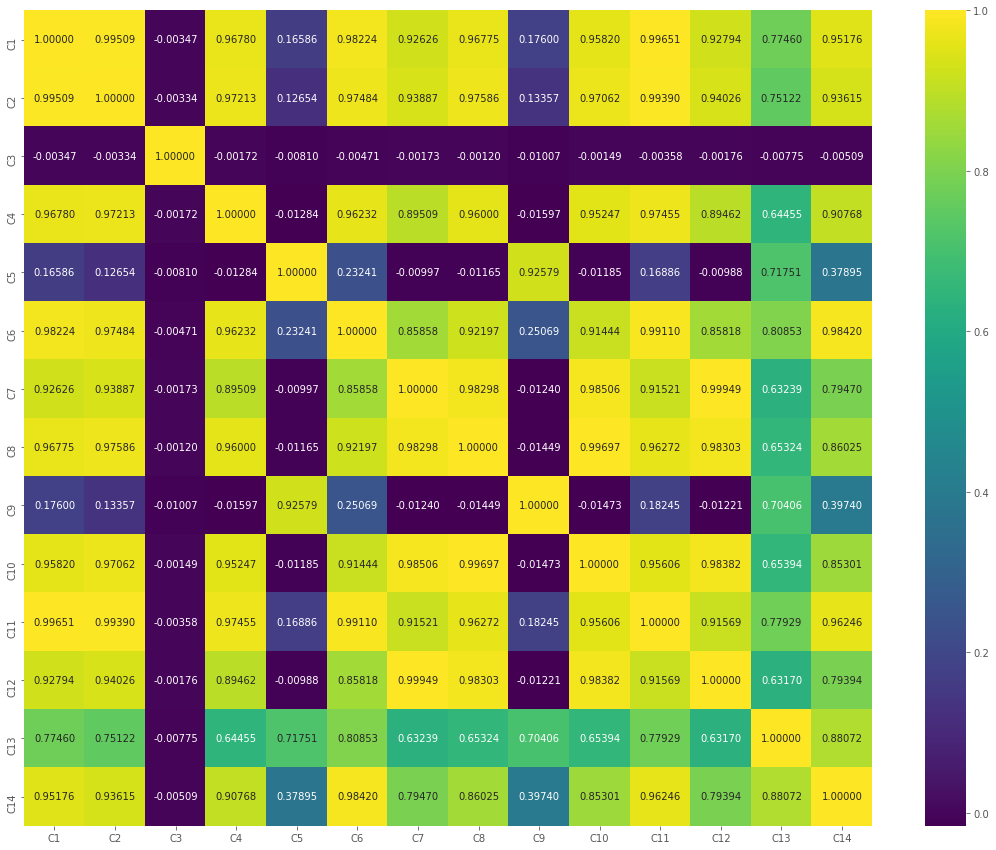

In [60]:
plt.figure(figsize=(19, 15))
sns.heatmap(corrMatrix_c,annot=True, fmt=".5f", cmap='viridis')

In [61]:
high_corr_var_c=np.where(corrMatrix_c > 0.8)
high_corr_var_c=[(corrMatrix_c.index[x],corrMatrix_c.columns[y]) for x,y in zip(*high_corr_var_c) if x!=y and x<y]

In [62]:
high_corr_var_c

[('C1', 'C2'),
 ('C1', 'C4'),
 ('C1', 'C6'),
 ('C1', 'C7'),
 ('C1', 'C8'),
 ('C1', 'C10'),
 ('C1', 'C11'),
 ('C1', 'C12'),
 ('C1', 'C14'),
 ('C2', 'C4'),
 ('C2', 'C6'),
 ('C2', 'C7'),
 ('C2', 'C8'),
 ('C2', 'C10'),
 ('C2', 'C11'),
 ('C2', 'C12'),
 ('C2', 'C14'),
 ('C4', 'C6'),
 ('C4', 'C7'),
 ('C4', 'C8'),
 ('C4', 'C10'),
 ('C4', 'C11'),
 ('C4', 'C12'),
 ('C4', 'C14'),
 ('C5', 'C9'),
 ('C6', 'C7'),
 ('C6', 'C8'),
 ('C6', 'C10'),
 ('C6', 'C11'),
 ('C6', 'C12'),
 ('C6', 'C13'),
 ('C6', 'C14'),
 ('C7', 'C8'),
 ('C7', 'C10'),
 ('C7', 'C11'),
 ('C7', 'C12'),
 ('C8', 'C10'),
 ('C8', 'C11'),
 ('C8', 'C12'),
 ('C8', 'C14'),
 ('C10', 'C11'),
 ('C10', 'C12'),
 ('C10', 'C14'),
 ('C11', 'C12'),
 ('C11', 'C14'),
 ('C13', 'C14')]

In [63]:

corrMatrix_d = df_train_D.corr()

In [64]:
corrMatrix_d

D1        D2        D3        D4        D5        D6        D7  \
D1   1.000000  0.020867  0.011360  0.005955  0.007317 -0.004118  0.007392   
D2   0.020867  1.000000  0.879818 -0.315953  0.470666  0.031270  0.014638   
D3   0.011360  0.879818  1.000000 -0.337076  0.540833  0.032862  0.055963   
D4   0.005955 -0.315953 -0.337076  1.000000 -0.690409  0.083371 -0.026069   
D5   0.007317  0.470666  0.540833 -0.690409  1.000000 -0.062391  0.214500   
D6  -0.004118  0.031270  0.032862  0.083371 -0.062391  1.000000 -0.727403   
D7   0.007392  0.014638  0.055963 -0.026069  0.214500 -0.727403  1.000000   
D8  -0.007187  0.116659  0.156052 -0.119514  0.121389  0.131220 -0.101928   
D9  -0.010794  0.171889  0.212608 -0.199674  0.130356  0.307436 -0.410427   
D10 -0.013978  0.310974  0.402211 -0.329905  0.338528 -0.029342  0.044232   
D11  0.011449 -0.333452 -0.337528  0.421334 -0.265422 -0.167412  0.167026   
D12 -0.003495  0.063950  0.029324  0.122064 -0.109196  0.774679 -0.633132   
D13  0.009768 -0.137294 -0.102187  0.040446 -0.006003 -0.567246  0.595477   
D14 -0.008711  0.116751  0.105067 -0.058428  0.034762  0.478756 -0.480704   
D15  0.011756 -0.461383 -0.467799  0.622297 -0.406630 -0.014887  0.068346   

           D8        D9       D10       D11       D12       D13       D14  \
D1  -0.007187 -0.010794 -0.013978  0.011449 -0.003495  0.009768 -0.008711   
D2   0.116659  0.171889  0.310974 -0.333452  0.063950 -0.137294  0.116751   
D3   0.156052  0.212608  0.402211 -0.337528  0.029324 -0.102187  0.105067   
D4  -0.119514 -0.199674 -0.329905  0.421334  0.122064  0.040446 -0.058428   
D5   0.121389  0.130356  0.338528 -0.265422 -0.109196 -0.006003  0.034762   
D6   0.131220  0.307436 -0.029342 -0.167412  0.774679 -0.567246  0.478756   
D7  -0.101928 -0.410427  0.044232  0.167026 -0.633132  0.595477 -0.480704   
D8   1.000000  0.510601  0.325273 -0.122293  0.076637 -0.094335  0.126595   
D9   0.510601  1.000000  0.459399 -0.234249  0.246728 -0.364742  0.354665   
D10  0.325273  0.459399  1.000000 -0.237296 -0.071056  0.088375  0.015509   
D11 -0.122293 -0.234249 -0.237296  1.000000 -0.159617  0.215281 -0.187226   
D12  0.076637  0.246728 -0.071056 -0.159617  1.000000 -0.629637  0.451391   
D13 -0.094335 -0.364742  0.088375  0.215281 -0.629637  1.000000 -0.701089   
D14  0.126595  0.354665  0.015509 -0.187226  0.451391 -0.701089  1.000000   
D15 -0.131399 -0.251495 -0.357879  0.621141 -0.050598  0.152212 -0.131418   

          D15  
D1   0.011756  
D2  -0.461383  
D3  -0.467799  
D4   0.622297  
D5  -0.406630  
D6  -0.014887  
D7   0.068346  
D8  -0.131399  
D9  -0.251495  
D10 -0.357879  
D11  0.621141  
D12 -0.050598  
D13  0.152212  
D14 -0.131418  
D15  1.000000

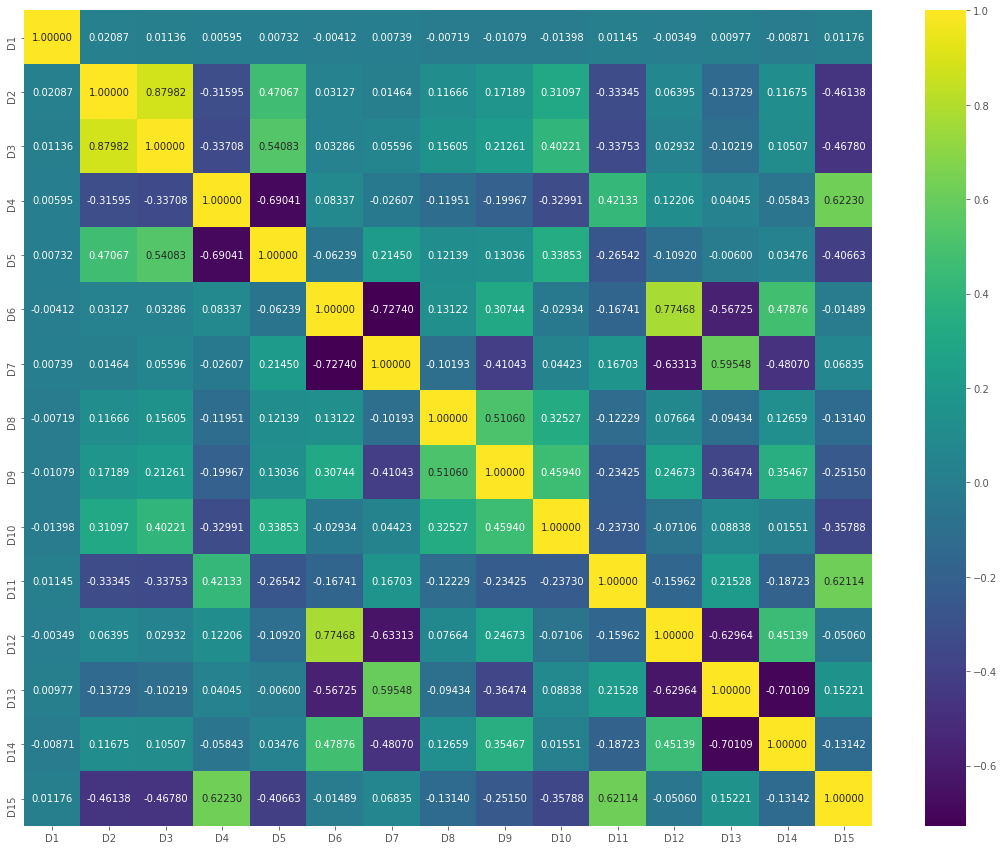

In [65]:
plt.figure(figsize=(25, 25))
sns.heatmap(corrMatrix_d,annot=True, fmt=".5f", cmap='viridis')

In [66]:
high_corr_var_d=np.where(corrMatrix_d > 0.8)
high_corr_var_d=[(corrMatrix_d.index[x],corrMatrix_d.columns[y]) for x,y in zip(*high_corr_var_d) if x!=y and x<y]

In [67]:
high_corr_var_d

[('D2', 'D3')]

In [68]:
corrMatrix_id = df_train_id.corr()

In [69]:
corrMatrix_id

id_01     id_02     id_03     id_04     id_05     id_06     id_07  \
id_01  1.000000  0.651972  0.623561  0.624008  0.950383  0.941811  0.111758   
id_02  0.651972  1.000000  0.364801  0.365494  0.672420  0.660680  0.067735   
id_03  0.623561  0.364801  1.000000  0.999049  0.626689  0.620740  0.108108   
id_04  0.624008  0.365494  0.999049  1.000000  0.626988  0.621098  0.107959   
id_05  0.950383  0.672420  0.626689  0.626988  1.000000  0.972962  0.128290   
id_06  0.941811  0.660680  0.620740  0.621098  0.972962  1.000000  0.075708   
id_07  0.111758  0.067735  0.108108  0.107959  0.128290  0.075708  1.000000   
id_08  0.106044  0.063803  0.101934  0.101751  0.112409  0.070877  0.899106   
id_09  0.666539  0.382959  0.931016  0.931081  0.672081  0.662676  0.122967   
id_10  0.666603  0.383495  0.931681  0.932397  0.672132  0.663560  0.120692   
id_11  0.964287  0.689977  0.649543  0.649992  0.970304  0.955488  0.162332   
id_13  0.846988  0.647288  0.539930  0.540493  0.856713  0.845435  0.151179   
id_14  0.677063  0.252175  0.463453  0.463646  0.663640  0.649085  0.211580   
id_17  0.889398  0.750480  0.571278  0.571650  0.914309  0.903178  0.073432   
id_18  0.455027  0.343666  0.291592  0.292054  0.518096  0.417007  0.134564   
id_19  0.814487  0.546172  0.542143  0.542851  0.828377  0.819118  0.072583   
id_20  0.831480  0.637254  0.545534  0.545800  0.853514  0.835109  0.092510   
id_21  0.084199  0.055056  0.094553  0.094118  0.079871  0.047969  0.767207   
id_22  0.080443  0.064221  0.079379  0.078922  0.069649  0.042360  0.659788   
id_24  0.078153  0.050463  0.077998  0.077600  0.083609  0.049105  0.721647   
id_25  0.102685  0.063984  0.105216  0.104854  0.113932  0.067011  0.902309   
id_26  0.092418  0.062232  0.091154  0.090771  0.099540  0.060249  0.812361   
id_32 -0.701727 -0.253230 -0.469593 -0.469923 -0.685734 -0.672342 -0.211122   

          id_08     id_09     id_10  ...     id_17     id_18     id_19  \
id_01  0.106044  0.666539  0.666603  ...  0.889398  0.455027  0.814487   
id_02  0.063803  0.382959  0.383495  ...  0.750480  0.343666  0.546172   
id_03  0.101934  0.931016  0.931681  ...  0.571278  0.291592  0.542143   
id_04  0.101751  0.931081  0.932397  ...  0.571650  0.292054  0.542851   
id_05  0.112409  0.672081  0.672132  ...  0.914309  0.518096  0.828377   
id_06  0.070877  0.662676  0.663560  ...  0.903178  0.417007  0.819118   
id_07  0.899106  0.122967  0.120692  ...  0.073432  0.134564  0.072583   
id_08  1.000000  0.116320  0.114151  ...  0.065320  0.115742  0.065515   
id_09  0.116320  1.000000  0.999424  ...  0.601759  0.320514  0.578185   
id_10  0.114151  0.999424  1.000000  ...  0.602485  0.319598  0.578209   
id_11  0.152098  0.656921  0.657264  ...  0.922930  0.485201  0.832244   
id_13  0.144500  0.592763  0.592582  ...  0.834244  0.413443  0.726934   
id_14  0.196523  0.503211  0.502254  ...  0.414696  0.382798  0.626377   
id_17  0.065320  0.601759  0.602485  ...  1.000000  0.429875  0.746733   
id_18  0.115742  0.320514  0.319598  ...  0.429875  1.000000  0.404704   
id_19  0.065515  0.578185  0.578209  ...  0.746733  0.404704  1.000000   
id_20  0.082198  0.575872  0.576389  ...  0.859591  0.461820  0.708972   
id_21  0.758178  0.112294  0.109109  ...  0.045099  0.084115  0.053118   
id_22  0.691947  0.091968  0.090462  ...  0.046473  0.070511  0.041617   
id_24  0.644245  0.093592  0.090969  ...  0.046352  0.087309  0.056207   
id_25  0.845406  0.118161  0.116056  ...  0.066988  0.122020  0.064677   
id_26  0.782094  0.106575  0.104696  ...  0.058279  0.102554  0.060903   
id_32 -0.191404 -0.513858 -0.512847  ... -0.417818 -0.380038 -0.662182   

          id_20     id_21     id_22     id_24     id_25     id_26     id_32  
id_01  0.831480  0.084199  0.080443  0.078153  0.102685  0.092418 -0.701727  
id_02  0.637254  0.055056  0.064221  0.050463  0.063984  0.062232 -0.253230  
id_03  0.545534  0.094553  0.079379  0.077998  0.105216  0.091154 -0.469593  
id_04  0.545800  0.09411

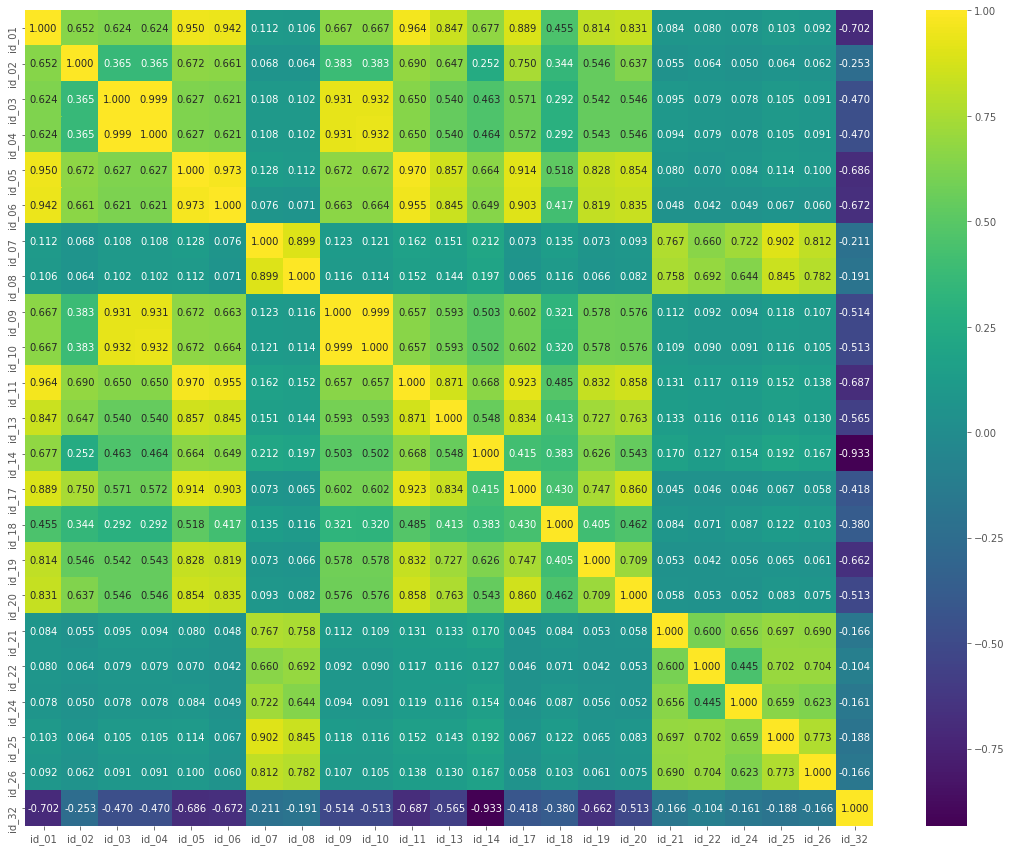

In [70]:
plt.figure(figsize=(25, 25))
sns.heatmap(corrMatrix_id,annot=True, fmt=".3f", cmap='viridis')

In [71]:
high_corr_var_id=np.where(corrMatrix_id > 0.8)
high_corr_var_id=[(corrMatrix_id.index[x],corrMatrix_id.columns[y]) for x,y in zip(*high_corr_var_id) if x!=y and x<y]

In [72]:
high_corr_var_id

[('id_01', 'id_05'),
 ('id_01', 'id_06'),
 ('id_01', 'id_11'),
 ('id_01', 'id_13'),
 ('id_01', 'id_17'),
 ('id_01', 'id_19'),
 ('id_01', 'id_20'),
 ('id_03', 'id_04'),
 ('id_03', 'id_09'),
 ('id_03', 'id_10'),
 ('id_04', 'id_09'),
 ('id_04', 'id_10'),
 ('id_05', 'id_06'),
 ('id_05', 'id_11'),
 ('id_05', 'id_13'),
 ('id_05', 'id_17'),
 ('id_05', 'id_19'),
 ('id_05', 'id_20'),
 ('id_06', 'id_11'),
 ('id_06', 'id_13'),
 ('id_06', 'id_17'),
 ('id_06', 'id_19'),
 ('id_06', 'id_20'),
 ('id_07', 'id_08'),
 ('id_07', 'id_25'),
 ('id_07', 'id_26'),
 ('id_08', 'id_25'),
 ('id_09', 'id_10'),
 ('id_11', 'id_13'),
 ('id_11', 'id_17'),
 ('id_11', 'id_19'),
 ('id_11', 'id_20'),
 ('id_13', 'id_17'),
 ('id_17', 'id_20')]

In [73]:

corrMatrix_restvar = df_train_restvar.corr()

In [74]:
corrMatrix_restvar

isFraud  TransactionAmt     addr1     addr2
isFraud         1.000000        0.011320 -0.081107 -0.161120
TransactionAmt  0.011320        1.000000  0.066175  0.138177
addr1          -0.081107        0.066175  1.000000  0.529115
addr2          -0.161120        0.138177  0.529115  1.000000

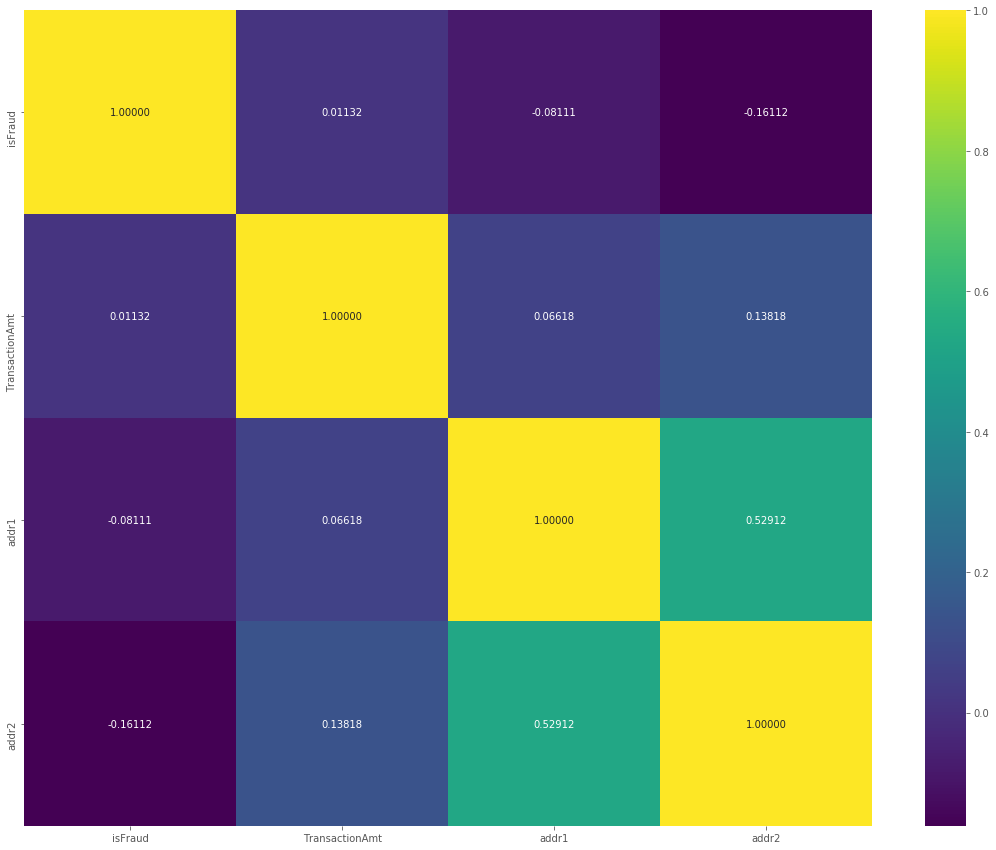

In [75]:
plt.figure(figsize=(25, 25))
sns.heatmap(corrMatrix_restvar,annot=True, fmt=".5f", cmap='viridis')

In [76]:
high_corr_var_restvar=np.where(corrMatrix_restvar > 0.8)
high_corr_var_restvar=[(corrMatrix_restvar.index[x],corrMatrix_restvar.columns[y]) for x,y in zip(*high_corr_var_restvar) if x!=y and x<y]

In [77]:
high_corr_var_restvar

[]

In [78]:
## df_train_C 0-100
corrMatrix_V1 = df_train_V[df_train_V.columns[0:100]].corr()

In [79]:
corrMatrix_V1.head()25

V1        V2        V3        V4        V5        V6        V7  \
V1  1.000000  0.999999  0.999998  0.999997  0.999996  0.999999  0.999998   
V2  0.999999  1.000000  0.999999  0.999997  0.999996  0.999999  0.999999   
V3  0.999998  0.999999  1.000000  0.999996  0.999996  0.999999  0.999999   
V4  0.999997  0.999997  0.999996  1.000000  0.999999  0.999997  0.999996   
V5  0.999996  0.999996  0.999996  0.999999  1.000000  0.999996  0.999996   

          V8        V9       V10  ...       V91       V92       V93       V94  \
V1  0.999999  0.999999  0.999996  ...  0.440637  0.443171  0.443223  0.442877   
V2  1.000000  0.999999  0.999995  ...  0.440637  0.443171  0.443222  0.442877   
V3  0.999999  0.999999  0.999994  ...  0.440636  0.443171  0.443222  0.442877   
V4  0.999997  0.999997  0.999992  ...  0.440635  0.443170  0.443221  0.442876   
V5  0.999997  0.999997  0.999992  ...  0.440635  0.443170  0.443221  0.442875   

         V95       V96       V97       V98       V99      V100  
V1  0.002857  0.003315  0.003090  0.000893 -0.023027 -0.004517  
V2  0.002856  0.003314  0.003089  0.000892 -0.023032 -0.004518  
V3  0.002855  0.003312  0.003087  0.000891 -0.023022 -0.004513  
V4  0.002860  0.003317  0.003092  0.000896 -0.023052 -0.004518  
V5  0.002857  0.003314  0.003089  0.000895 -0.023037 -0.004512  

[5 rows x 100 columns]

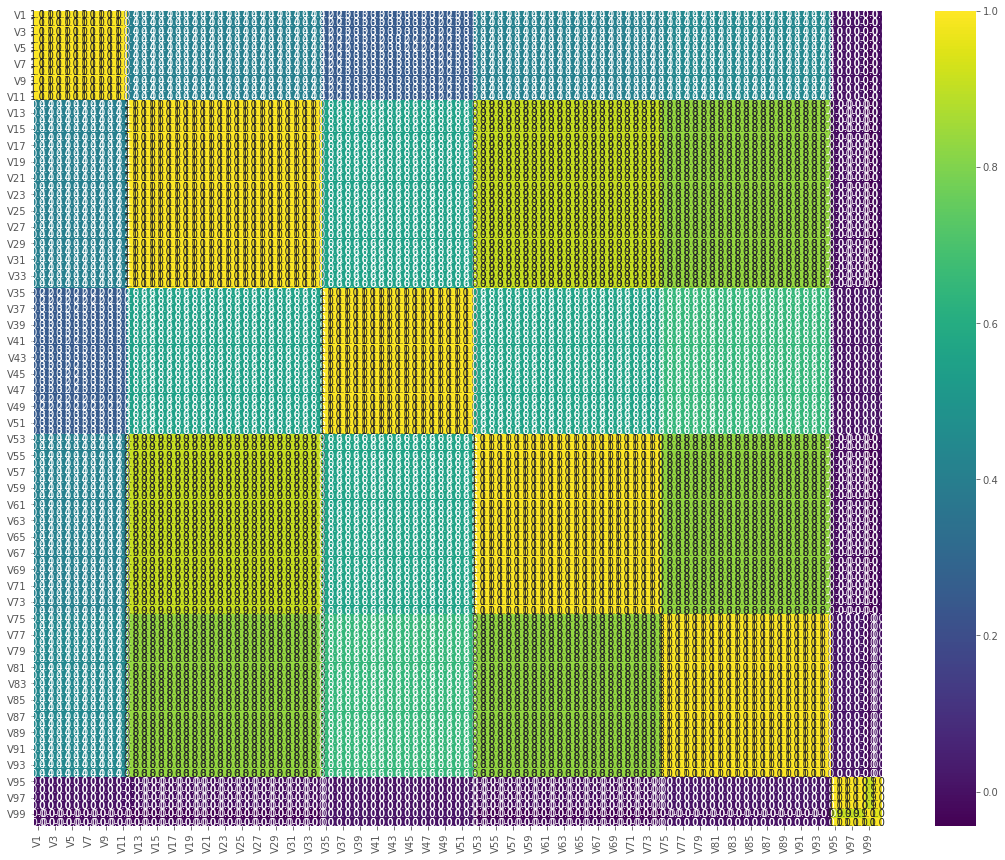

In [80]:
plt.figure(figsize=(25, 19))
sns.heatmap(corrMatrix_V1,annot=True,fmt=".1f", cmap='viridis')

In [81]:
high_corr_var_v1=np.where(corrMatrix_V1 > 0.8)
high_corr_var_v1=[(corrMatrix_V1.index[x],corrMatrix_V1.columns[y]) for x,y in zip(*high_corr_var_v1) if x!=y and x<y]

In [82]:
high_corr_var_v1

[('V1', 'V2'),
 ('V1', 'V3'),
 ('V1', 'V4'),
 ('V1', 'V5'),
 ('V1', 'V6'),
 ('V1', 'V7'),
 ('V1', 'V8'),
 ('V1', 'V9'),
 ('V1', 'V10'),
 ('V1', 'V11'),
 ('V2', 'V3'),
 ('V2', 'V4'),
 ('V2', 'V5'),
 ('V2', 'V6'),
 ('V2', 'V7'),
 ('V2', 'V8'),
 ('V2', 'V9'),
 ('V2', 'V10'),
 ('V2', 'V11'),
 ('V3', 'V4'),
 ('V3', 'V5'),
 ('V3', 'V6'),
 ('V3', 'V7'),
 ('V3', 'V8'),
 ('V3', 'V9'),
 ('V3', 'V10'),
 ('V3', 'V11'),
 ('V4', 'V5'),
 ('V4', 'V6'),
 ('V4', 'V7'),
 ('V4', 'V8'),
 ('V4', 'V9'),
 ('V4', 'V10'),
 ('V4', 'V11'),
 ('V5', 'V6'),
 ('V5', 'V7'),
 ('V5', 'V8'),
 ('V5', 'V9'),
 ('V5', 'V10'),
 ('V5', 'V11'),
 ('V6', 'V7'),
 ('V6', 'V8'),
 ('V6', 'V9'),
 ('V6', 'V10'),
 ('V6', 'V11'),
 ('V7', 'V8'),
 ('V7', 'V9'),
 ('V7', 'V10'),
 ('V7', 'V11'),
 ('V8', 'V9'),
 ('V8', 'V10'),
 ('V8', 'V11'),
 ('V9', 'V10'),
 ('V9', 'V11'),
 ('V10', 'V11'),
 ('V12', 'V13'),
 ('V12', 'V14'),
 ('V12', 'V15'),
 ('V12', 'V16'),
 ('V12', 'V17'),
 ('V12', 'V18'),
 ('V12', 'V19'),
 ('V12', 'V20'),
 ('V12', 'V21'),
 (

In [83]:
## df_train_C 100-200

corrMatrix_V2 = df_train_V[df_train_V.columns[100:200]].corr()

In [84]:
corrMatrix_V2.head()

V101      V102      V103      V104      V105      V106      V107  \
V101  1.000000  0.999931  0.999980  0.994866  0.872628  0.957930  0.999901   
V102  0.999931  1.000000  0.999974  0.995480  0.877739  0.960599  0.999711   
V103  0.999980  0.999974  1.000000  0.995163  0.874885  0.959220  0.999850   
V104  0.994866  0.995480  0.995163  1.000000  0.906913  0.978577  0.993960   
V105  0.872628  0.877739  0.874885  0.906913  1.000000  0.970086  0.867117   

          V108      V109      V110  ...      V191      V192      V193  \
V101  0.999812  0.999669  0.999770  ...  0.006872  0.006875  0.006872   
V102  0.999622  0.999480  0.999580  ...  0.006115  0.006117  0.006115   
V103  0.999760  0.999617  0.999718  ...  0.006522  0.006524  0.006522   
V104  0.993924  0.993775  0.993882  ... -0.002224 -0.002225 -0.002225   
V105  0.867079  0.867044  0.867085  ... -0.032373 -0.032404 -0.032390   

          V194      V195      V196      V197      V198      V199      V200  
V101  0.001018  0.001019  0.006870  0.001017  0.001016  0.006870  0.001017  
V102  0.000263  0.000264  0.006113  0.000262  0.000262  0.006113  0.000262  
V103  0.000669  0.000670  0.006520  0.000668  0.000667  0.006520  0.000668  
V104 -0.008036 -0.008034 -0.002226 -0.008036 -0.008037 -0.002208 -0.008037  
V105 -0.037395 -0.037396 -0.032379 -0.037397 -0.037399 -0.032370 -0.037428  

[5 rows x 100 columns]

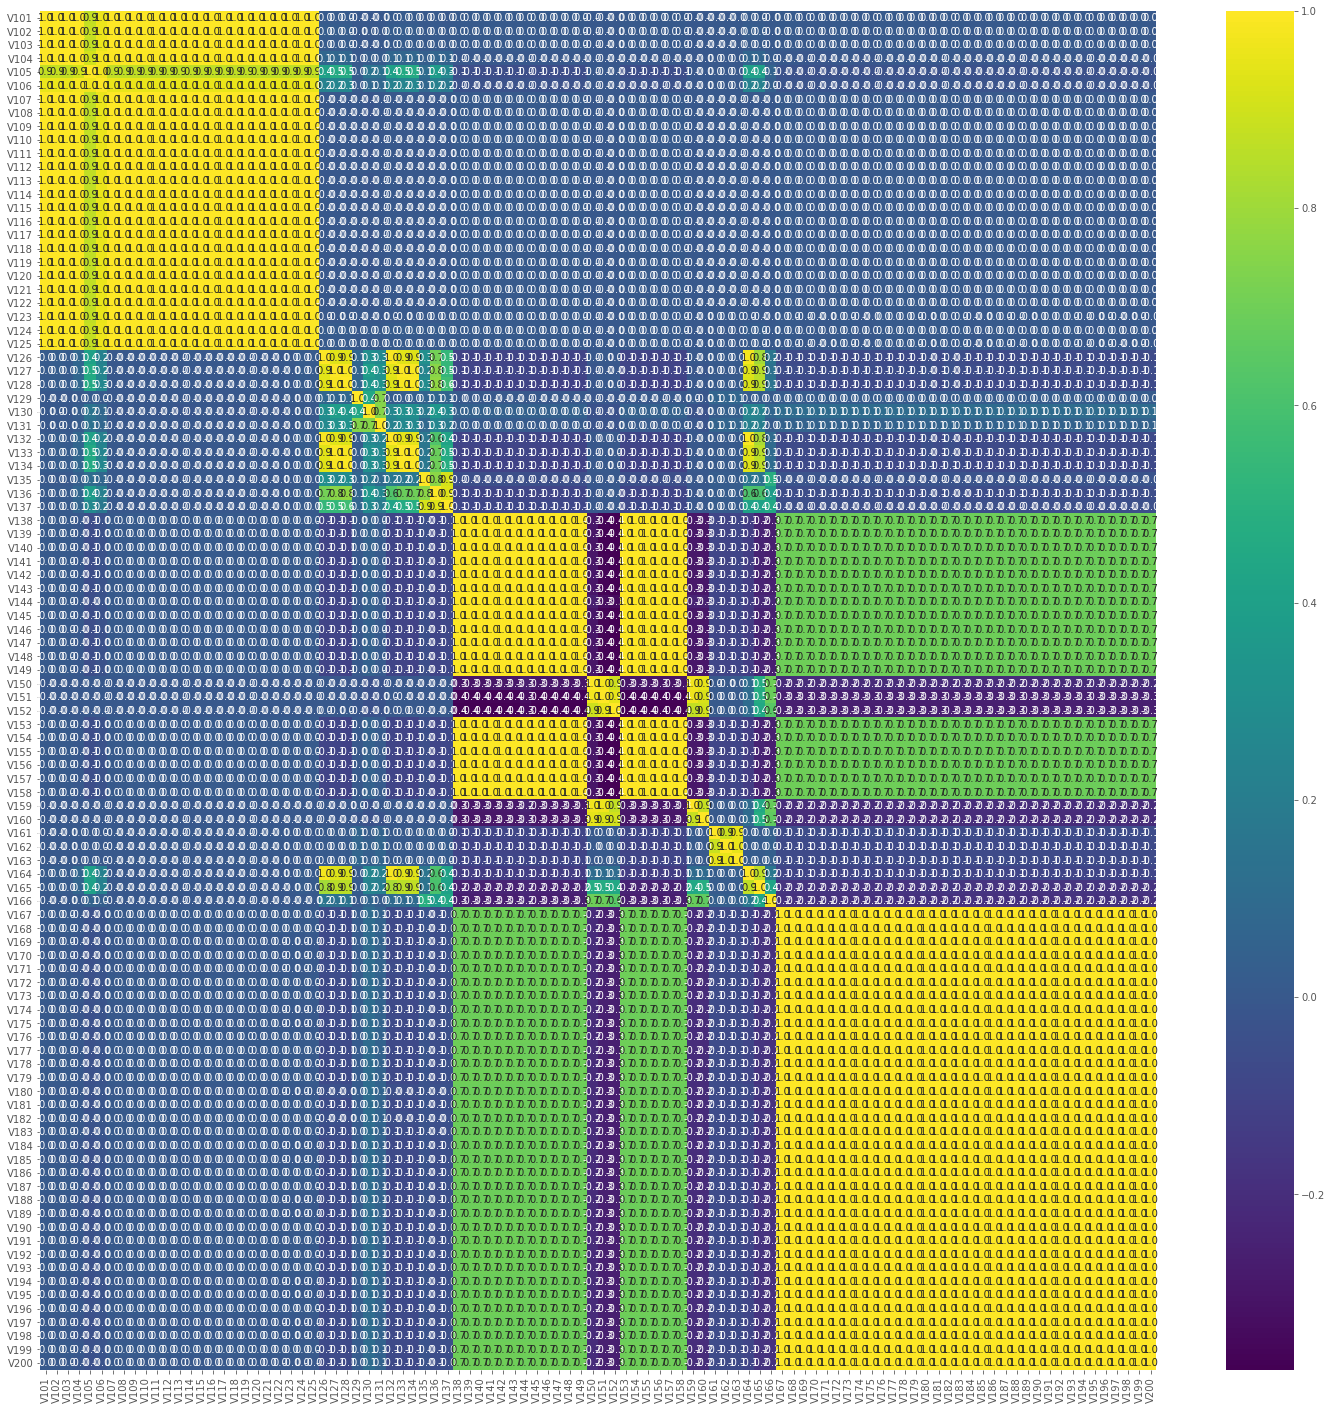

In [85]:
plt.figure(figsize=(25, 25))
sns.heatmap(corrMatrix_V2,annot=True,fmt=".1f", cmap='viridis')

In [86]:
## df_train_C 100-150
corrMatrix_V3 = df_train_V[df_train_V.columns[200:300]].corr()

In [87]:
corrMatrix_V3.head()

V201      V202      V203      V204      V205      V206      V207  \
V201  1.000000 -0.082629 -0.103000 -0.098761 -0.062447 -0.032765 -0.069210   
V202 -0.082629  1.000000  0.865489  0.927369  0.096149  0.050905  0.145628   
V203 -0.103000  0.865489  1.000000  0.964704  0.304555  0.062752  0.494229   
V204 -0.098761  0.927369  0.964704  1.000000  0.219106  0.057978  0.353178   
V205 -0.062447  0.096149  0.304555  0.219106  1.000000  0.762776  0.764771   

          V208      V209      V210  ...      V216      V217      V218  \
V201 -0.144299 -0.124098 -0.152743  ... -0.091733  0.943069  0.943071   
V202  0.129024  0.599365  0.429718  ...  0.455312  0.000487  0.000496   
V203  0.118841  0.739084  0.419944  ...  0.515295  0.013261  0.013268   
V204  0.137052  0.709634  0.463939  ...  0.526526  0.006525  0.006535   
V205  0.208889  0.314761  0.172173  ...  0.171140 -0.017235 -0.017233   

          V219      V220      V221      V222      V223      V224      V225  
V201  0.943070  0.985104  0.985124  0.985124  0.943083  0.943210  0.943144  
V202  0.000493 -0.082018 -0.082013 -0.082013  0.000507  0.001076  0.000707  
V203  0.013266 -0.102167 -0.102123 -0.102123  0.013276  0.013695  0.013421  
V204  0.006532 -0.098041 -0.098020 -0.098020  0.006546  0.007107  0.006745  
V205 -0.017234 -0.061599 -0.061780 -0.061780 -0.017083 -0.016999 -0.017055  

[5 rows x 25 columns]

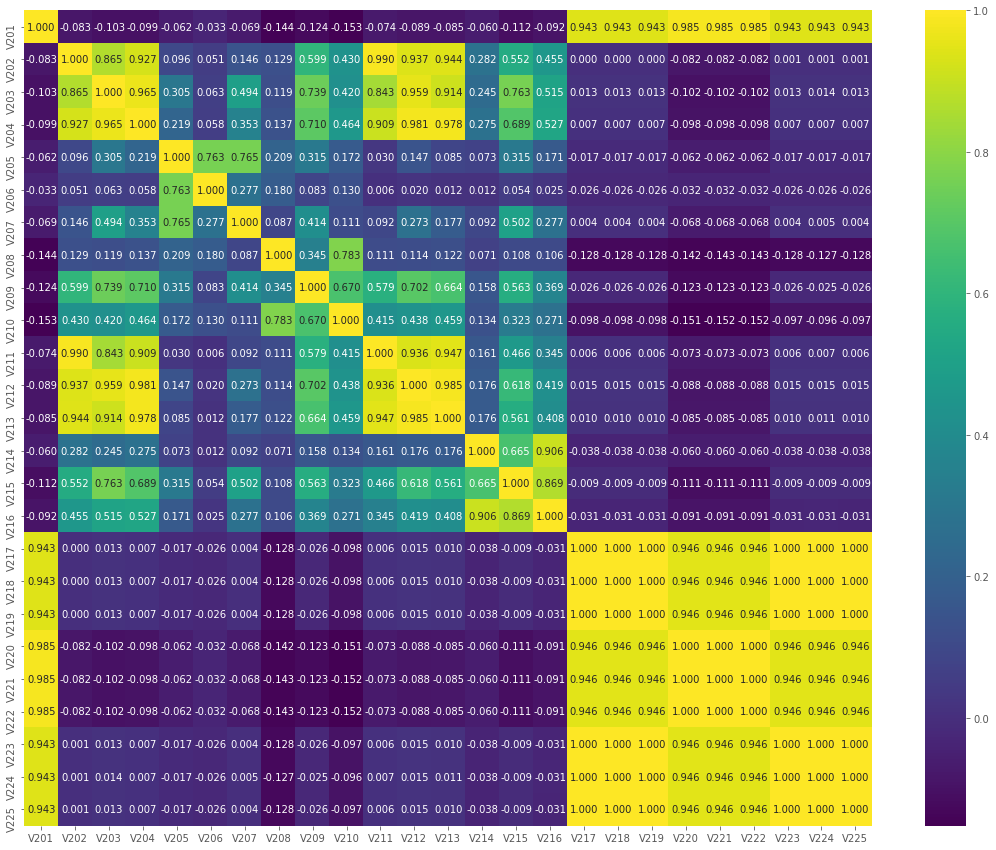

In [88]:
plt.figure(figsize=(25, 25))
sns.heatmap(corrMatrix_V3,annot=True, fmt=".3f", cmap='viridis')

In [89]:
## df_train_C 150-200
corrMatrix_V4 = df_train_V[df_train_V.columns[300:]].corr()

In [90]:
corrMatrix_V4.head()

V301      V302      V303      V304      V305      V306      V307  \
V301  1.000000  0.001506  0.000391  0.001070 -0.006892 -0.000731 -0.003241   
V302  0.001506  1.000000  0.972605  0.993410 -0.798828  0.053533  0.047748   
V303  0.000391  0.972605  1.000000  0.985398 -0.761311  0.133309  0.157263   
V304  0.001070  0.993410  0.985398  1.000000 -0.787043  0.087740  0.093781   
V305 -0.006892 -0.798828 -0.761311 -0.787043  1.000000  0.000157  0.000427   

          V308      V309      V310  ...      V330      V331      V332  \
V301 -0.001900 -0.001224 -0.014743  ...  0.012143 -0.001591 -0.001954   
V302  0.054804 -0.003343 -0.037801  ... -0.242920  0.056430  0.058237   
V303  0.153198 -0.000776 -0.011226  ... -0.251559  0.135391  0.149688   
V304  0.100125 -0.001610 -0.024862  ... -0.247715  0.090571  0.101596   
V305  0.000283  0.000280  0.002553  ... -0.001047  0.000112  0.000119   

          V333      V334      V335      V336      V337      V338      V339  
V301 -0.001909 -0.000551 -0.002516 -0.001658  0.001956 -0.000308  0.000681  
V302  0.060294  0.012993  0.058611  0.040354  0.027753  0.057679  0.048953  
V303  0.152215  0.017694  0.132960  0.085382  0.046959  0.135158  0.104650  
V304  0.104576  0.015827  0.095102  0.063800  0.037307  0.097690  0.078214  
V305  0.000123  0.000043  0.000149  0.000104  0.000082  0.000134  0.000120  

[5 rows x 39 columns]

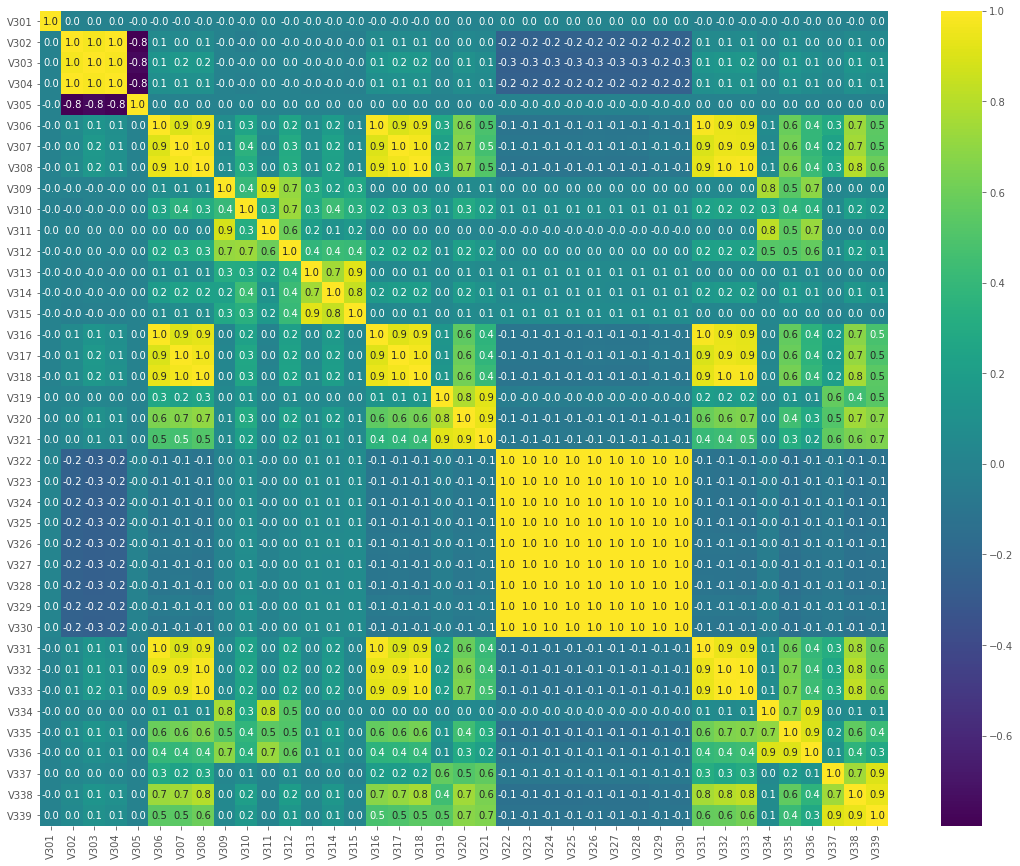

In [91]:
plt.figure(figsize=(25, 25))
sns.heatmap(corrMatrix_V4,annot=True, fmt=".1f", cmap='viridis')

## Correlation between categorial variables

Cramer's V - a correlation measure for categorial variables based on ChiSquare
Reference:
Wikipedia - https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

In [92]:
from scipy.stats import chi2_contingency

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [93]:
df_train_category.columns


Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'],
      dtype='object')

In [94]:
# P_emaildomain ~ R_emaildomain

chi2_emaildomain = pd.crosstab(df_train_category['P_emaildomain'], df_train_category['R_emaildomain'])

chi_val,p_val,dof,exp_val=chi2_contingency(chi2_emaildomain)
print("Chi square test\nChi squared = %f\np           = %f\nDOF         = %d"%(chi_val,p_val,dof))

Chi square test
Chi squared = 3566693.988455
p           = 0.000000
DOF         = 3364


In [95]:
# ProductCD ~ DeviceInfo

chi2_ProductCD_DeviceInfo = pd.crosstab(df_train_category['ProductCD'], df_train_category['DeviceInfo'])

chi_val,p_val,dof,exp_val=chi2_contingency(chi2_ProductCD_DeviceInfo)
print("Chi square test\nChi squared = %f\np           = %f\nDOF         = %d"%(chi_val,p_val,dof))

Chi square test
Chi squared = 8141.878465
p           = 0.000000
DOF         = 7140


In [96]:
# ProductCD ~ DeviceType

chi2_ProductCD_DeviceType = pd.crosstab(df_train_category['ProductCD'], df_train_category['DeviceType'])

chi_val,p_val,dof,exp_val=chi2_contingency(chi2_ProductCD_DeviceType)
print("Chi square test\nChi squared = %f\np           = %f\nDOF         = %d"%(chi_val,p_val,dof))

Chi square test
Chi squared = 50.937438
p           = 0.000000
DOF         = 4


In [97]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


import sys

## Save results in a csv file

df_cor_v = get_top_abs_correlations(df_train_V, 350)  
df_cor_v.to_csv("C:/Data Sciene/DS-Git/Data Science GIT/DataScience/project/df_cor_v.csv")

## Save results in a csv file

df_cor_c = get_top_abs_correlations(df_train_C, 250)  
df_cor_c.to_csv("C:/Data Sciene/DS-Git/Data Science GIT/DataScience/project/df_cor_c.csv")

## Save results in a csv file

df_cor_d = get_top_abs_correlations(df_train_D, 350)  
df_cor_d.to_csv("C:/Data Sciene/DS-Git/Data Science GIT/DataScience/project/df_cor_d.csv")

## Missingness ##

### Dealing with Missing Values

In [98]:
df_train.isnull().sum().sort_values(ascending=False)

id_23            585371
id_27            585371
id_33            517251
id_30            512975
id_34            512735
                  ...  
V228                  0
V229                  0
V230                  0
V231                  0
TransactionID         0
Length: 436, dtype: int64

In [99]:
df_test.isnull().sum().sort_values(ascending=False)

id-23            501629
id-27            501629
id-30            436032
id-33            436020
id-34            434516
                  ...  
V228                  0
V229                  0
V230                  0
V231                  0
TransactionID         0
Length: 433, dtype: int64

In [100]:
df_train.isnull().sum().sort_values(ascending=False).head(31)

id_23            585371
id_27            585371
id_33            517251
id_30            512975
id_34            512735
DeviceInfo       471874
id_16            461200
R_emaildomain    453249
id_31            450258
DeviceType       449730
id_29            449562
id_28            449562
id_15            449555
id_35            449555
id_36            449555
id_37            449555
id_38            449555
id_12            446307
M5               350482
M7               346265
M9               346252
M8               346252
M4               281444
M2               271100
M3               271100
M1               271100
M6               169360
P_emaildomain     94456
card4              1577
card6              1571
V95                   0
dtype: int64

In [101]:
df_test.isnull().sum().sort_values(ascending=False).head(31)

id-23            501629
id-27            501629
id-30            436032
id-33            436020
id-34            434516
DeviceInfo       391634
id-16            380944
R_emaildomain    370821
id-31            370066
id-28            369913
id-29            369913
DeviceType       369760
id-38            369714
id-35            369714
id-37            369714
id-15            369714
id-36            369714
id-12            364784
M5               309632
M4               237745
M7               235018
M8               235004
M9               235004
M2               176639
M1               176639
M3               176639
M6               158939
P_emaildomain     69192
card4              3086
card6              3007
V145                  0
dtype: int64

we have 31 variables with missing values in df_test

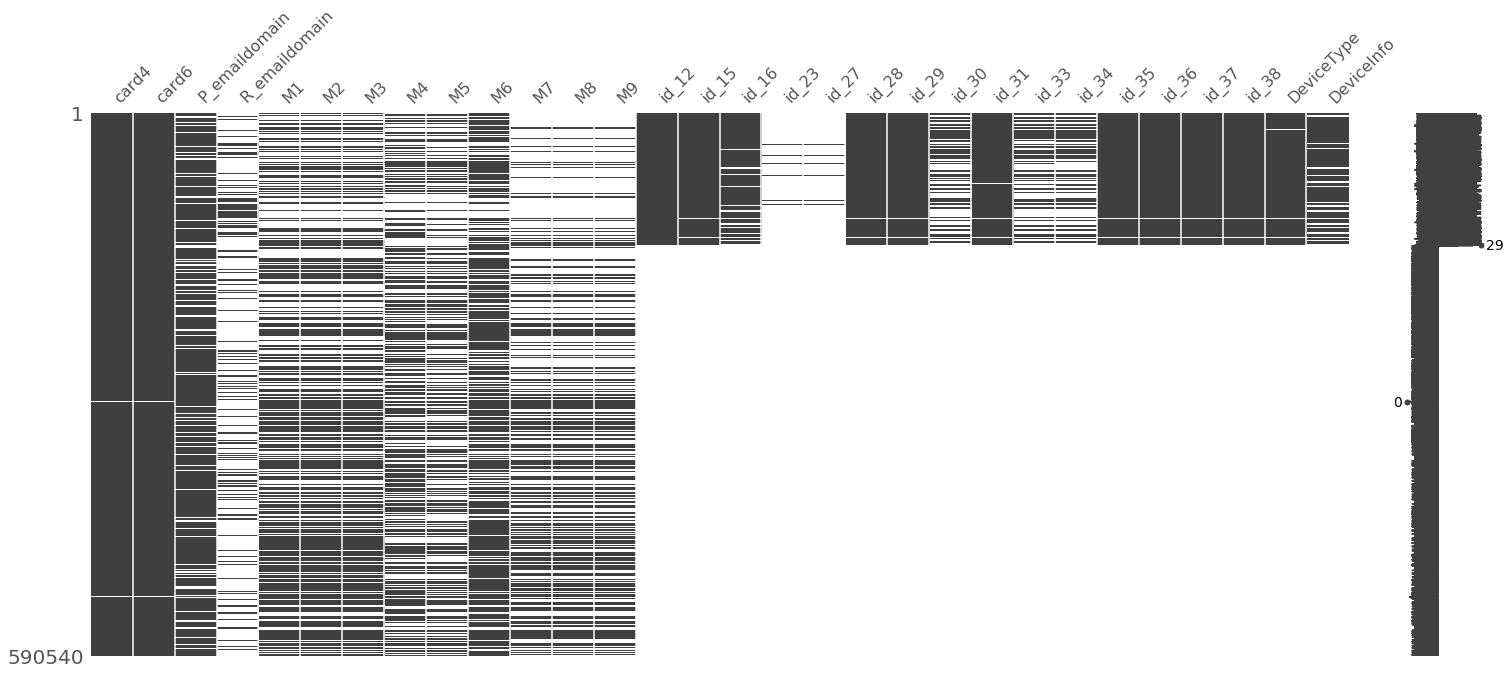

In [102]:
### pip install missingno
import missingno as msno

### plot the missingness (nullity) matrix
missingdata_df = df_train.columns[df_train.isnull().any()].tolist()
msno.matrix(df_train[missingdata_df])


# Outliers #

trying converting R to python

In [210]:
rscript = """
outlierMatrix <- function(data,threshold=1.5) {
    vn <- names(data)
    outdata <- data.frame(row1=1:nrow(data))
    for(v in vn) {
        if(is.numeric(data[[v]])) {
            outlow <- quantile(data[[v]],probs = 0.25,na.rm = T) 
            outhigh <- quantile(data[[v]],probs = 0.75, na.rm = T)
            irq_level <- (outhigh - outlow) * threshold
            outlow <- outlow - irq_level
            outhigh <- outhigh +  irq_level
            mv <- ifelse(data[[v]] < outlow | data[[v]] > outhigh, 1, 0)
            outdata[v] <- mv
        } else {
            mv <- rep(0,nrow(data))
        }
    }
    outdata$row1 <- NULL
    return(outdata)
}
"""

In [222]:
!pip3 install pyensae

Processing c:\users\eladl\appdata\local\pip\cache\wheels\df\69\f1\014404b18215c9db0e6809f00de55a3bb489c046bd4d17da12\pyensae-1.3.884-py3-none-any.whl
  Using cached pyquickhelper-1.9.3418-py3-none-any.whl (2.2 MB)
Processing c:\users\eladl\appdata\local\pip\cache\wheels\95\38\e1\8b62337a8ecf5728bdc1017e828f253f7a9cf25db999861bec\fire-0.3.1-py2.py3-none-any.whl
Processing c:\users\eladl\appdata\local\pip\cache\wheels\3f\e3\ec\8a8336ff196023622fbcb36de0c5a5c218cbb24111d1d4c7f2\termcolor-1.1.0-py3-none-any.whl
  Attempting uninstall: numpy
    Found existing installation: numpy 1.16.5
    Uninstalling numpy-1.16.5:
      Successfully uninstalled numpy-1.16.5


You should consider upgrading via the 'c:\users\eladl\appdata\local\continuum\anaconda3\python.exe -m pip install --upgrade pip' command.


In [226]:
pip install antlr4-python2-runtime

  Created wheel for antlr4-python2-runtime: filename=antlr4_python2_runtime-4.9-py3-none-any.whl size=140485 sha256=02e16c7a7548497689f16415c0bfa49b8eb0e401b35e9516608e27645c3a0c20
  Stored in directory: c:\users\eladl\appdata\local\pip\cache\wheels\33\76\ce\72e6366f72fd588ec08cfdf55aed537cf2f8deaa8a7de01136
Successfully built antlr4-python2-runtime
Note: you may need to restart the kernel to use updated packages.


In [236]:
import builtins

In [254]:
try:
    import builtins
except ImportError:
    import __builtin__ as builtins

In [281]:
from pyensae.languages import r2python

#print(r2python(rscript, pep8=True))

ModuleNotFoundError: No module named '__builtin__'

In [276]:
conda install -c r rpy2 


Note: you may need to restart the kernel to use updated packages.


Traceback (most recent call last):
  File "C:\Users\ELADL\Anaconda3\Scripts\conda-script.py", line 11, in <module>
    from conda.cli import main
ModuleNotFoundError: No module named 'conda'


In [279]:
conda install -c r r-essentials


Note: you may need to restart the kernel to use updated packages.


Traceback (most recent call last):
  File "C:\Users\ELADL\Anaconda3\Scripts\conda-script.py", line 11, in <module>
    from conda.cli import main
ModuleNotFoundError: No module named 'conda'


In [280]:
conda install -c r rpy2


Note: you may need to restart the kernel to use updated packages.


Traceback (most recent call last):
  File "C:\Users\ELADL\Anaconda3\Scripts\conda-script.py", line 11, in <module>
    from conda.cli import main
ModuleNotFoundError: No module named 'conda'


In [282]:
from rpy2.robjects import r, pandas2ri

pandas2ri.activate()

ModuleNotFoundError: No module named 'rpy2'

In [103]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range


In [104]:
lowerbound,upperbound = outlier_treatment(df_train_numeric['addr1'])

This code will go through each columns in data-frame and work one by one by filtering the outliers alone, instead of going through all the values in rows for finding outliers.

In [105]:
def mod_outlier(df):
        df1 = df.copy()
        df = df._get_numeric_data()

        q1 = df.quantile(0.25)
        q3 = df.quantile(0.75)

        iqr = q3 - q1

        lower_bound = q1 -(1.5 * iqr) 
        upper_bound = q3 +(1.5 * iqr)

        for col in df.columns:
            for i in range(0,len(df[col])):
                if df[col][i] < lower_bound[col]:            
                    df[col][i] = lower_bound[col]

                if df[col][i] > upper_bound[col]:            
                    df[col][i] = upper_bound[col]    

        for col in df.columns:
            df1[col] = df[col]

        return(df1)

df = mod_outlier(df_train_numeric)

In [108]:
df.to_csv("C:/Data Sciene/DS-Git/Data Science GIT/DataScience/project/df_outliers.csv")

In [107]:
df

TransactionID  isFraud  TransactionDT  TransactionAmt  card1  card2  \
0             2987000        0          86400       68.500000  13926     99   
1             2987001        0          86401       29.000000   2755    404   
2             2987002        0          86469       59.000000   4663    490   
3             2987003        0          86499       50.000000  18132    567   
4             2987004        0          86506       50.000000   4497    514   
...               ...      ...            ...             ...    ...    ...   
590535        3577535        0       15811047       49.000000   6550     99   
590536        3577536        0       15811049       39.500000  10444    225   
590537        3577537        0       15811079       30.950001  12037    595   
590538        3577538        0       15811088      117.000000   7826    481   
590539        3577539        0       15811131      247.518494  15066    170   

        card3  card5  addr1  addr2  ...  id_17  id_18  id_19  id_20  id_21  \
0         150    142    315     87  ...     99      9     99     99     99   
1         150    102    325     87  ...     99      9     99     99     99   
2         150    166    330     87  ...     99      9     99     99     99   
3         150    117    476     87  ...     99      9     99     99     99   
4         150    102    420     87  ...     99      9     99     99     99   
...       ...    ...    ...    ...  ...    ...    ...    ...    ...    ...   
590535    150    226    272     87  ...     99      9     99     99     99   
590536    150    224    204     87  ...     99      9     99     99     99   
590537    150    224    231     87  ...     99      9     99     99     99   
590538    150    224    387     87  ...     99      9     99     99     99   
590539    150    102    299     87  ...     99      9     99     99     99   

        id_22  id_24  id_25  id_26  id_32  
0           9     10     99     99    255  
1           9     10     99     99    255  
2           9     10     99     99    255  
3           9     10     99     99    255  
4           9     10     99     99    255  
...       ...    ...    ...    ...    ...  
590535      9     10     99     99    255  
590536      9     10     99     99    255  
590537      9     10     99     99    255  
590538      9     10     99     99    255  
590539      9     10     99     99    255  

[590540 rows x 403 columns]